In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bcnf.simulation.physics import physics_ODE_simulation, calculate_point_of_impact
from bcnf.camera import record_trajectory

In [2]:
def get_cam2_position(l):
    cam2_x = 25 * np.cos(l)
    cam2_y = 25 * np.sin(l)
    cam2_z = 1.5

    return np.array([cam2_x, cam2_y, cam2_z])

# create function to sample uniformy for the ballisitc parameters

def sample_ballistic_parameters():
    # pos
    x0_x = np.random.uniform(-40, 40)   # person can stand outside the circle, but not too far away
    x0_y = np.random.uniform(-40, 40)
    x0_z = np.random.uniform(1, 2)      # height of the average persones head is somewhere here

    x0 = np.array([x0_x, x0_y, x0_z])

    # velo
    v0_x = np.random.uniform(-25, 25)   # 25 m/s (90 km/h) is very well possible for a handball throw
    v0_y = np.random.uniform(-25, 25)
    v0_z = np.random.uniform(-25, 25)

    v0 = np.array([v0_x, v0_y, v0_z])

    # grav
    g_z = np.random.uniform(-0.08 * 9.81, -2.5 * 9.8) # from ~0.779 up to ~24.79 (Triton to Jupiter)

    g = np.array([0, 0, g_z])

    # wind
    w_x = np.random.uniform(-20, 20)    # includes up to the definition of "stürmischer Wind" (https://de.wikipedia.org/wiki/Windgeschwindigkeit)
    w_y = np.random.uniform(-20, 20)
    w_z = np.random.uniform(-20, 20)

    w = np.array([w_x, w_y, w_z])

    # b
    # density of atmosphere
    rho = np.random.uniform(0, 1.5)     # excluding venus with insane 67 kg/m^3...
    
    # area of thown object
    A = np.random.uniform(0.003, 0.15)  # from a small ball (3 cm radius) to a big ball (20 cm radius)

    # drag coefficient
    Cd = np.random.uniform(0.04, 1.42)  # reference for 3D objects (https://en.wikipedia.org/wiki/Drag_coefficient)

    b = rho * A * Cd    # drag coefficient (do we need a factor of 0.5 here?)

    # mass
    m = np.random.uniform(0.056, 0.62)  # from a tennis ball (56 g) to a basketball (620 g)

    # thrust
    a_x = np.random.uniform(-5, 5)      # thats just wild guessing
    a_y = np.random.uniform(-5, 5)
    a_z = np.random.uniform(-5, 5)

    a = np.array([a_x, a_y, a_z])

    # second cam position
    l = np.random.uniform(0, 2 * np.pi)

    # average radius of ball
    r = (A/np.pi)**0.5

    return x0, v0, g, w, b, m, a, l, r, A, Cd, rho

In [3]:
# sample uniformly while the pandas df has less than 1000 rows


df = pd.DataFrame(columns=[
    'x0_x', 'x0_y', 'x0_z',
    'v0_x', 'v0_y', 'v0_z',
    'g', 
    'w_x', 'w_y', 'w_z',
    'b', 'A', 'Cd', 'rho', 'm', 
    'a_x', 'a_y', 'a_z',
    'l', 'r'])

SPF = 1 / 30
T = 3
cam1_pos = np.array([-25, 0, 1.5])

while df.shape[0] < 100:
    x0, v0, g, w, b, m, a, l, r, A, Cd, rho = sample_ballistic_parameters()
    print('Gen: ', x0, v0, g, w, b, m, a, l, r, A, Cd, rho)
    traj = physics_ODE_simulation(x0, v0, g, w, b, m, a, T, SPF)
    print('Sim')
    
    # check whether ball is thrown further than 5 m
    poi = calculate_point_of_impact(x0, v0, g, w, b, m, a, dt=0.01)[:2]
    print(np.linalg.norm(poi - x0[:2]))
    if np.linalg.norm(poi - x0[:2]) > 5:
        # check if ball is throw less than 100 m
        print('check')
        if np.linalg.norm(poi - x0[:2]) < 100:
            print('check')
            cam2_pos = get_cam2_position(l)

            cam1 = record_trajectory(traj, (16,9), 70.0, cam1_pos, make_gif = False, radius=r)
            cam2 = record_trajectory(traj, (16,9), 70.0, cam2_pos, make_gif = False, radius=r)

            # check whether the ball is visible in at least 80 % of the combined frames
            print(np.sum(cam1 + cam2) / (2 * len(cam1)))
            if np.sum(cam1 + cam2) / (2 * len(cam1)) > 0.8:
                # add parameters to df
                df = pd.concat([
                    df,
                    pd.DataFrame({
                        'x0_x': x0[0],
                        'x0_y': x0[1],
                        'x0_z': x0[2],
                        'v0_x': v0[0],
                        'v0_y': v0[1],
                        'v0_z': v0[2],
                        'g': g[2],
                        'w_x': w[0],
                        'w_y': w[1],
                        'w_z': w[2],
                        'b': b,
                        'A': A,
                        'Cd': Cd,
                        'rho': rho,
                        'm': m,
                        'a_x': a[0],
                        'a_y': a[1],
                        'a_z': a[2],
                        'l': l,
                        'r': r
                    }, index=[0])
                ], ignore_index=True)

Gen:  [ -2.86315213 -31.48697153   1.04327393] [ 23.77226017 -14.48081924  -2.79024503] [  0.           0.         -22.40631398] [-16.10927329  -7.71799965 -14.12286251] 0.008429548423520582 0.19619771307641823 [-2.49977506 -4.56904997  0.13733397] 5.212626001203755 0.13633174645830692 0.058390725199280825 1.106961283218748 0.1304151392143143
Sim
5.029777962550732
check
check
0.0
Gen:  [24.24399041 35.64447318  1.75226246] [ 5.25125138  0.97641734 15.40105876] [  0.           0.         -20.38284998] [-7.92541578  6.87459195  2.23321855] 0.06802950227419836 0.3919788525538447 [ 2.83899652  4.43805597 -1.37306439] 5.233151903433076 0.2162345568373263 0.1468926527265867 0.39324962968657884 1.1776843325262554
Sim
7.096735119190411
check
check
0.0
Gen:  [27.71207838 26.46728923  1.36668646] [ -7.95109812 -11.42360132 -13.80109523] [  0.           0.         -10.23756301] [ 18.80000774 -12.01097423  14.713974  ] 0.0010784418161599069 0.5448178789004728 [-1.81623655  0.91287192  0.72641236] 

C:\Users\Chris\AppData\Local\Temp\ipykernel_9668\22664129.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([


0.5
Gen:  [ -3.18913604 -32.22318216   1.80488699] [-15.41081889 -18.58516105  -7.03766889] [  0.           0.         -19.38763691] [-17.83769186 -12.78231146  10.35992141] 0.023438970639633294 0.05694842447999285 [1.44875171 2.45649954 4.04712397] 0.37743663473671846 0.09694316898279907 0.029524618682440752 0.8921307742010779 0.8898682609882966
Sim
6.82093841335322
check
check
0.48333333333333334
Gen:  [-35.79454786   5.41074472   1.54089196] [ -7.95932059  21.39666497 -23.82987925] [ 0.          0.         -8.08270641] [ 9.78812943 19.9718057   2.90699289] 0.01984580200816161 0.3370206564189261 [ 4.55075561 -0.10074336  2.09077279] 0.365897249946359 0.209329094645707 0.13766041133856166 1.4126872495553633 0.10205013086973297
Sim
1.5073359284371934
Gen:  [ 7.41178759 38.39444566  1.03560989] [23.01856161 -5.23416265 -5.75756539] [ 0.         0.        -6.8378708] [  2.71897359 -12.85041823 -11.61941267] 0.017832773929056116 0.528157157797602 [ 3.68470936 -1.73876623 -3.02042989] 5.97

In [4]:
print(df)

         x0_x       x0_y      x0_z       v0_x       v0_y       v0_z  \
0   -1.036985  -5.636575  1.141157  24.863697   0.089168  10.787154   
1   25.583947 -20.535597  1.040521  21.613700   5.579744  19.913451   
2   -1.981277  14.112768  1.155896  11.188189  -3.973542   7.102542   
3   -2.562148  12.114572  1.470170  24.233160  19.523807   2.640955   
4   -2.806278 -22.354911  1.932085  -3.355022  21.830191   3.360582   
..        ...        ...       ...        ...        ...        ...   
95  16.010983   3.467833  1.308174  -5.112680   0.795761  23.113690   
96   8.000508  16.857298  1.377172 -14.519187 -22.022799  24.810342   
97  25.429120 -38.162353  1.117000  19.308892  -4.858568  13.543905   
98  -9.936938  -3.613030  1.198907   9.330667  16.905247   8.493582   
99  11.431908  -4.007365  1.912917  -4.486793 -22.716345  -7.265001   

            g        w_x        w_y        w_z         b         A        Cd  \
0  -24.347475  10.326643   0.318041  -3.919835  0.024333  0.133690 

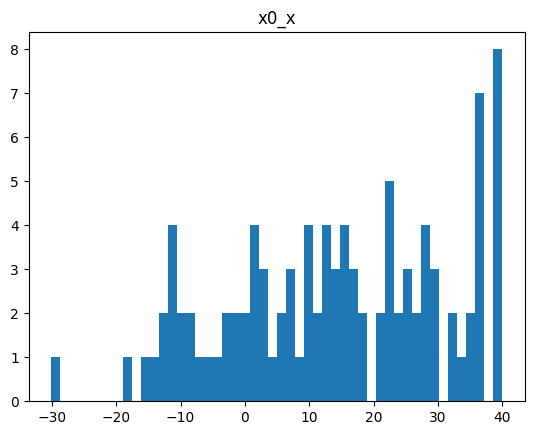

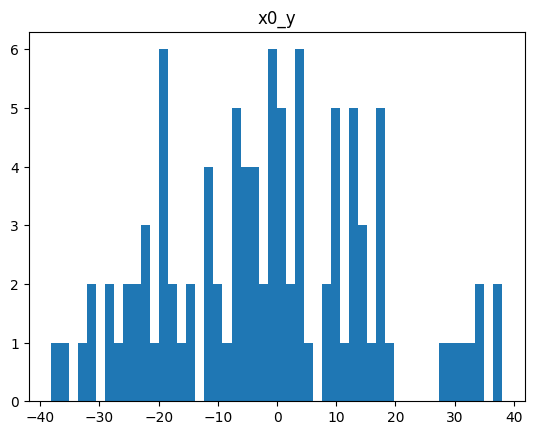

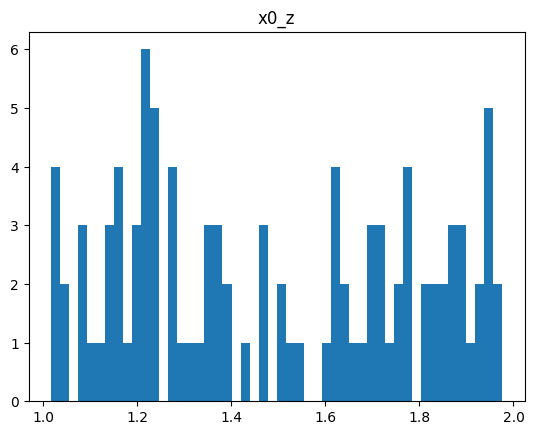

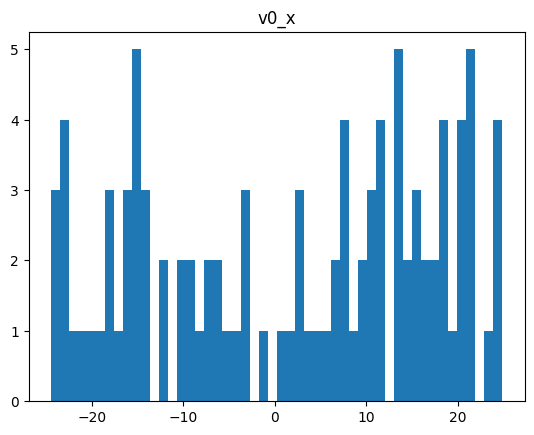

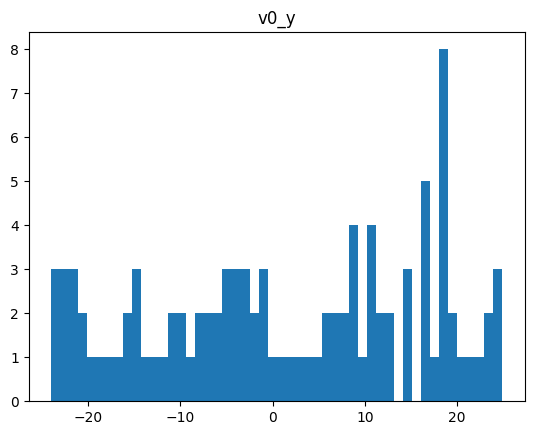

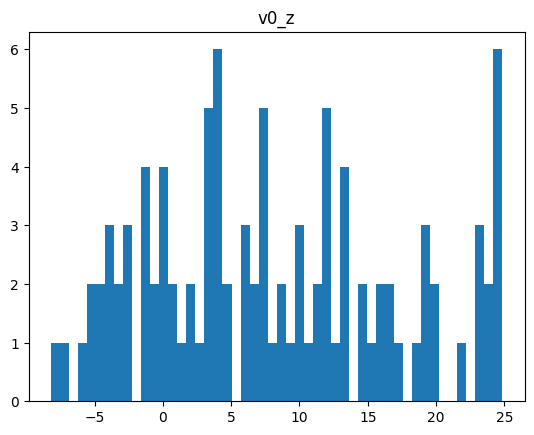

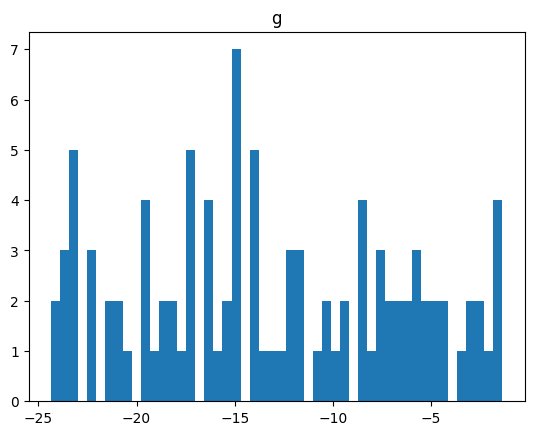

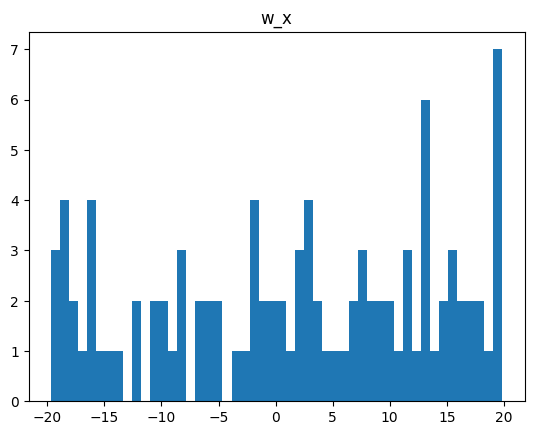

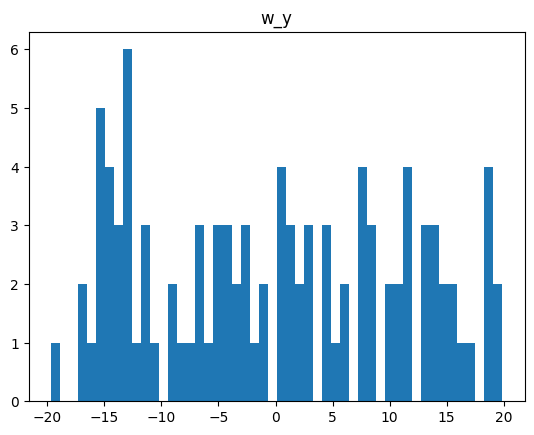

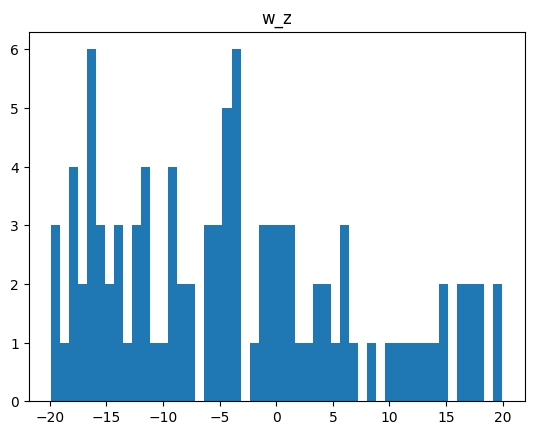

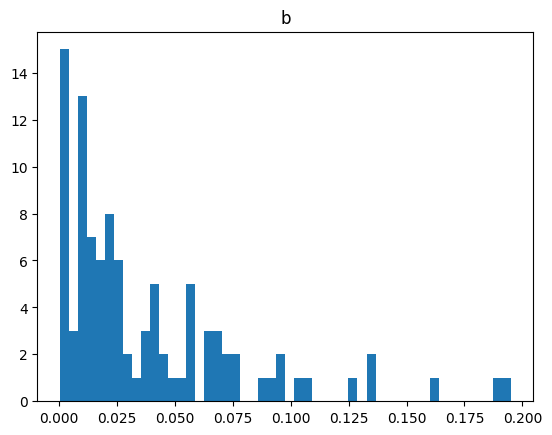

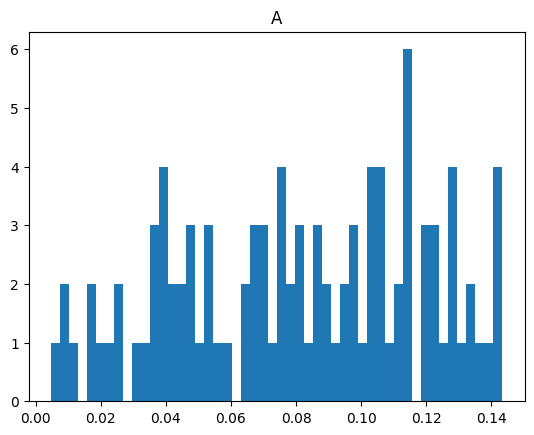

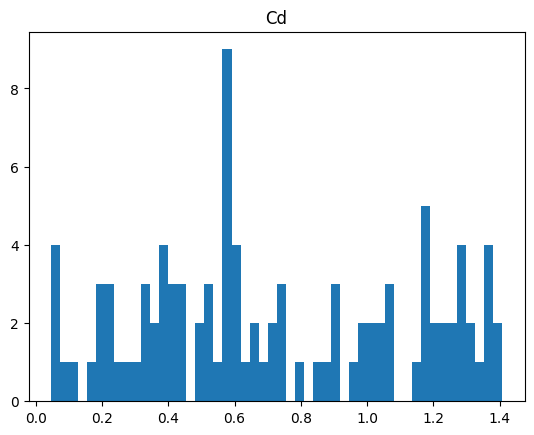

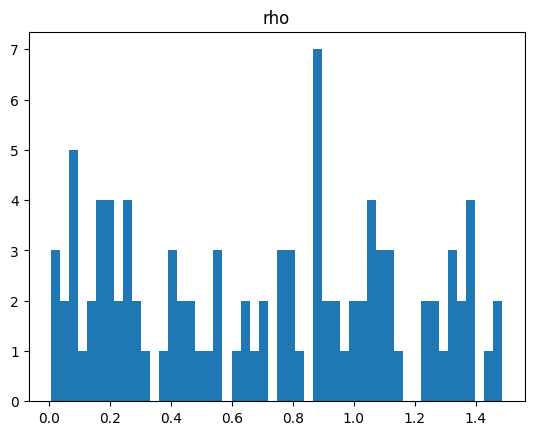

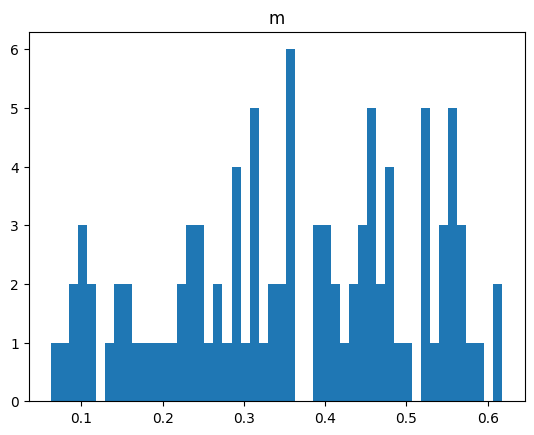

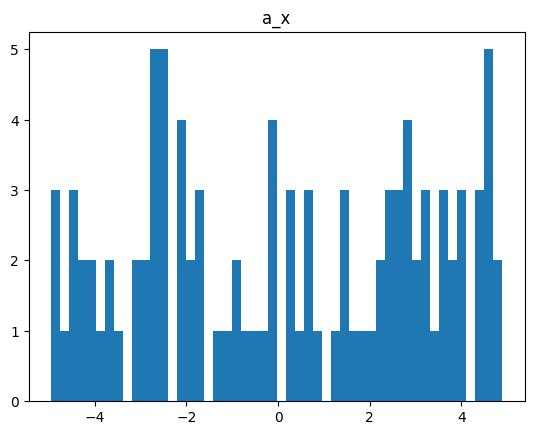

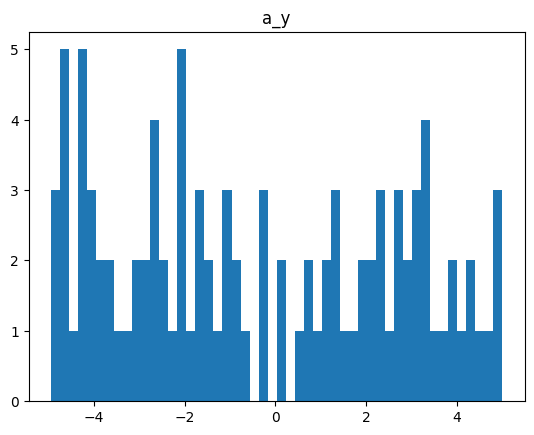

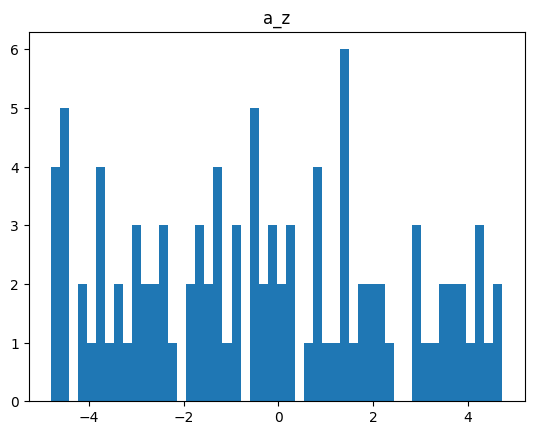

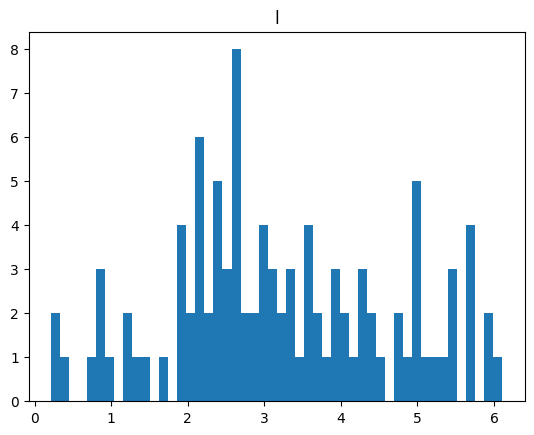

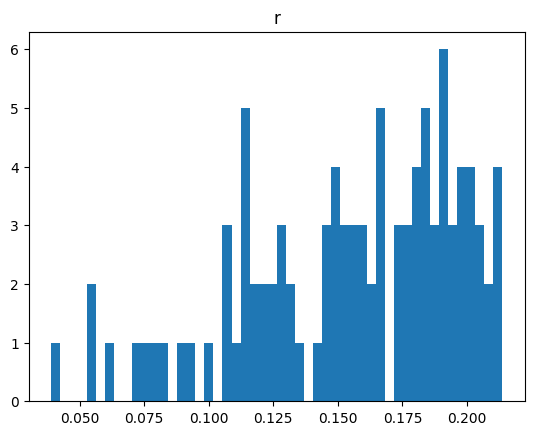

In [5]:
# plot each variable
for col in df.columns:
    plt.hist(df[col], bins=50)
    plt.title(col)
    plt.show()

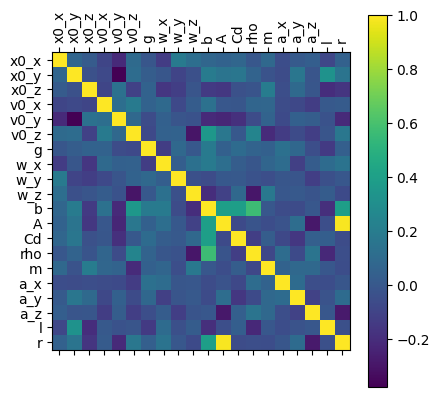

In [6]:
# plot correlation matrix
plt.matshow(df.corr())
plt.xticks(range(df.shape[1]), df.columns, rotation=90)
plt.yticks(range(df.shape[1]), df.columns)
plt.colorbar()
plt.show()

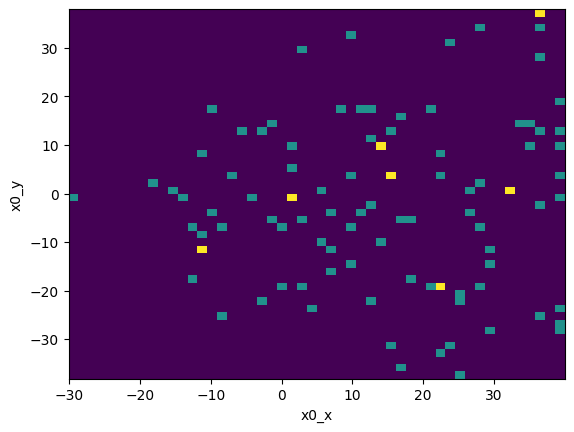

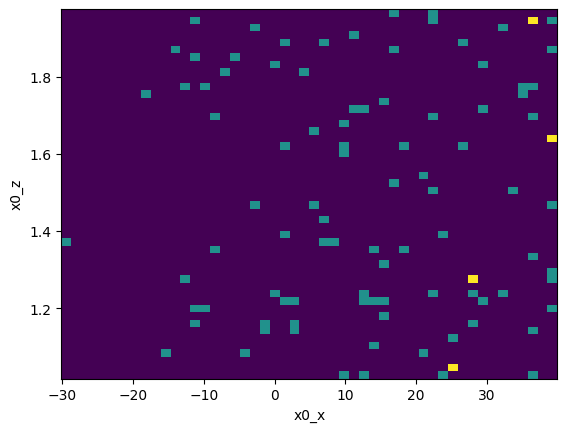

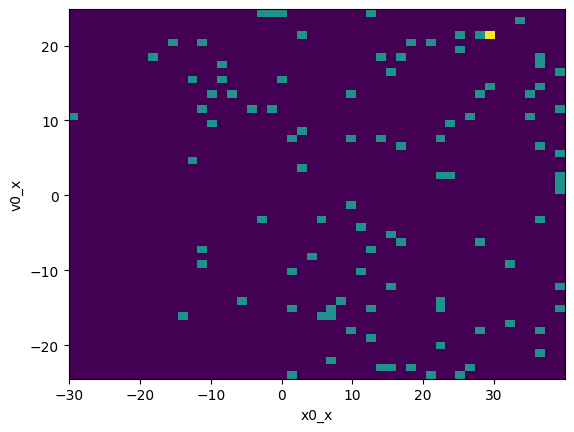

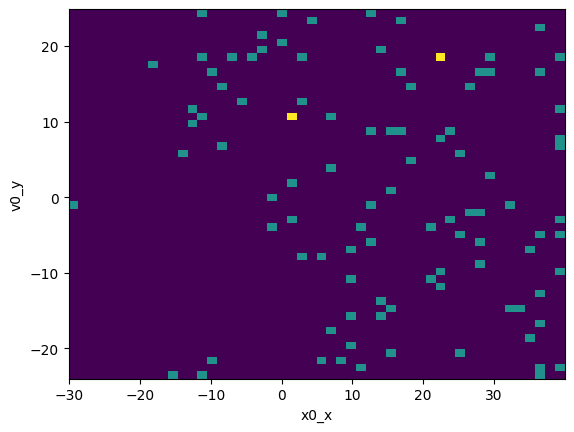

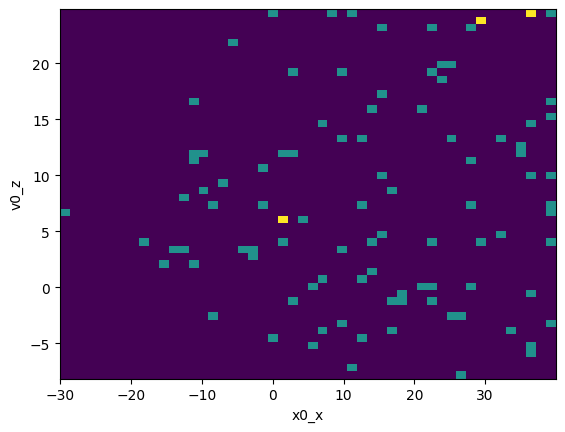

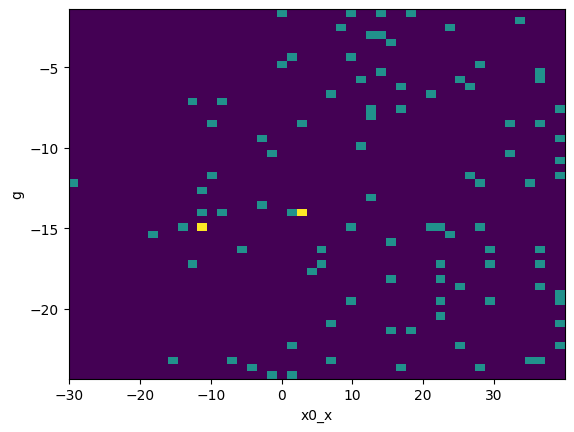

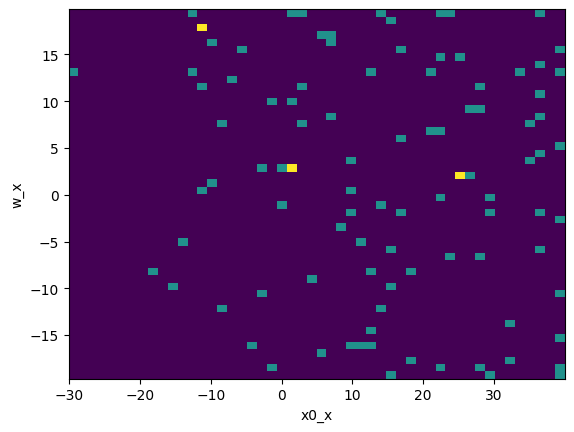

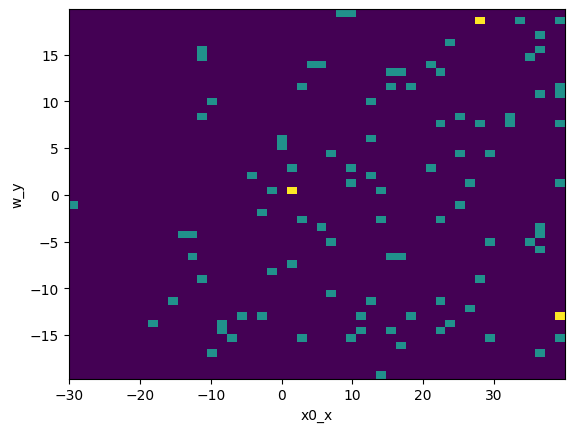

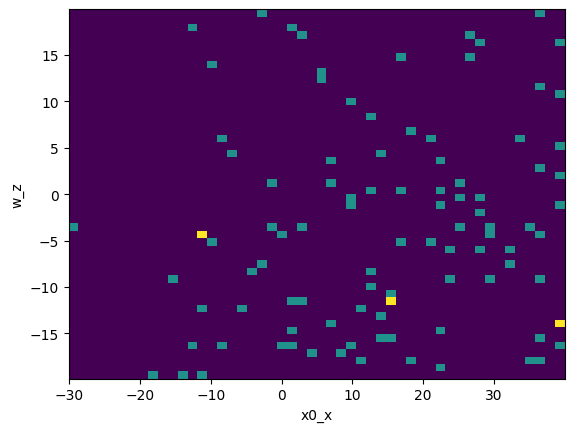

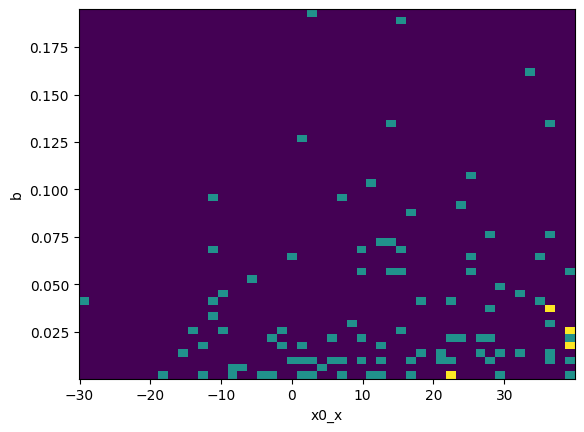

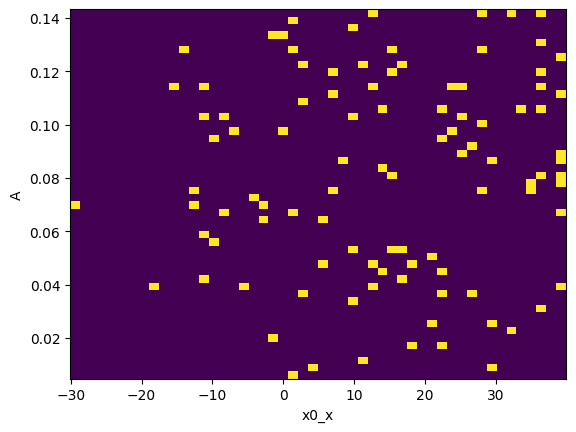

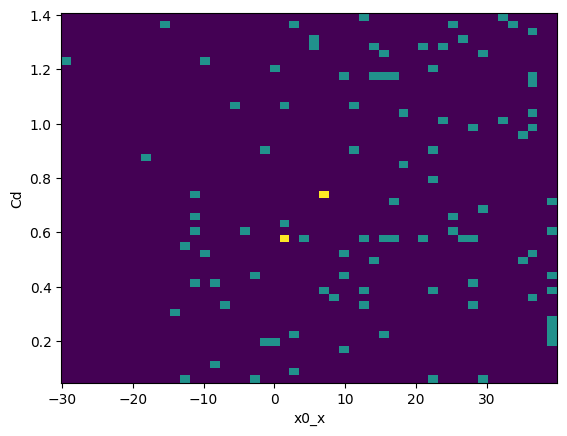

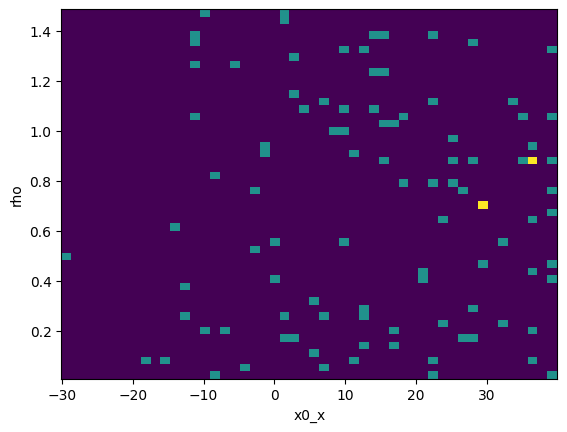

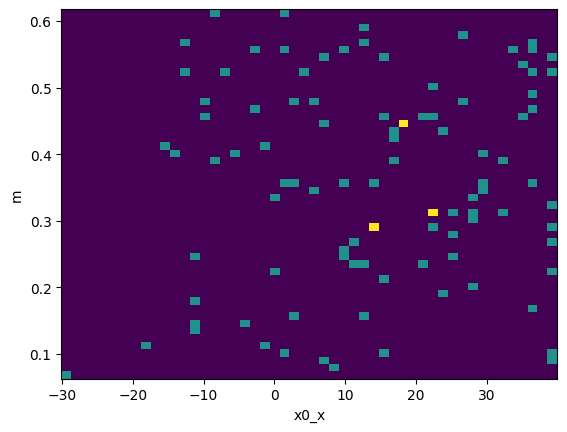

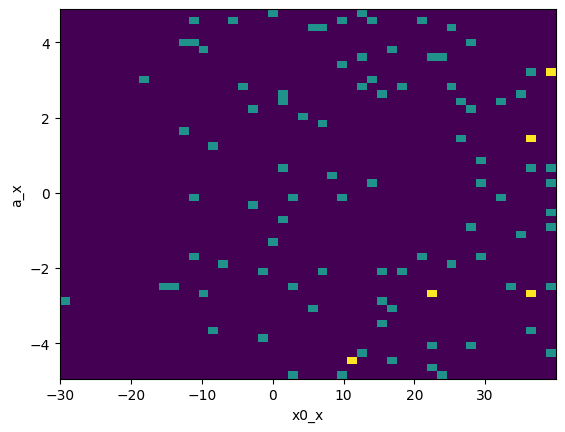

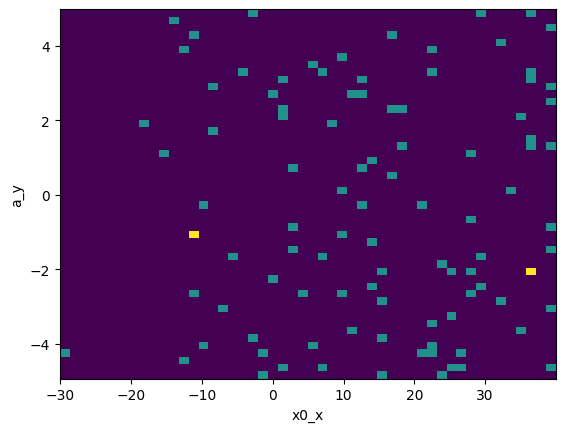

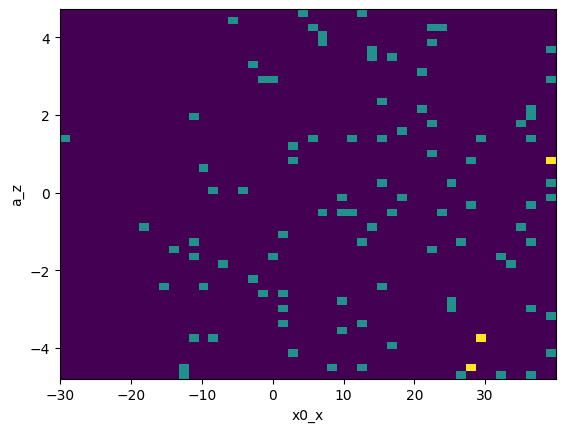

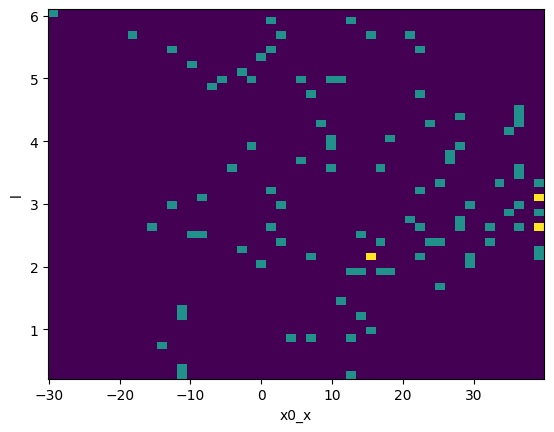

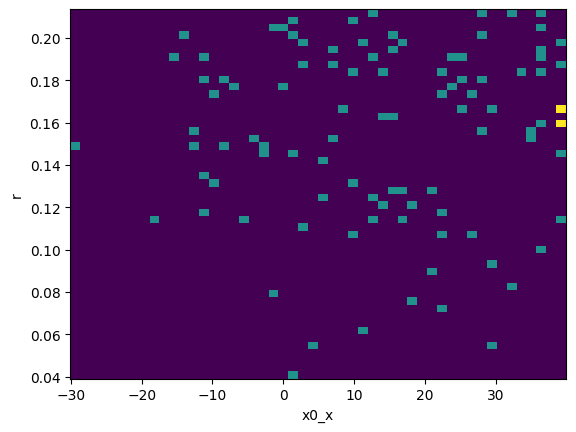

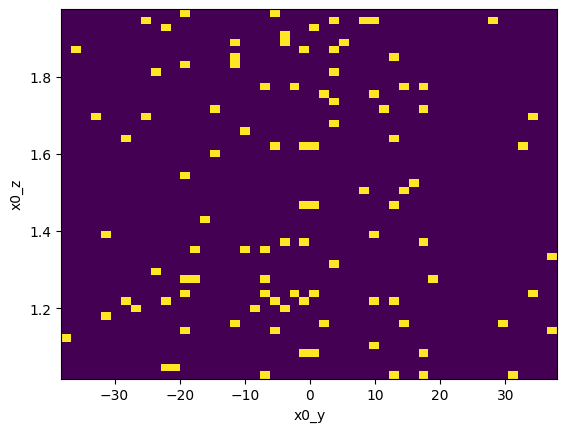

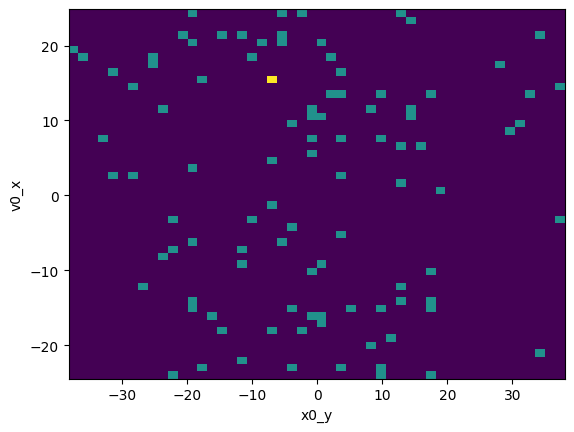

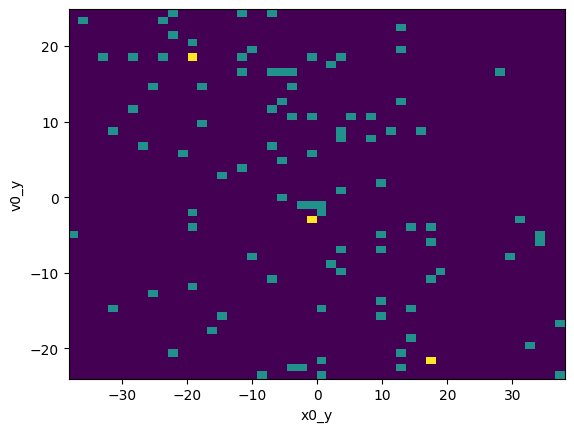

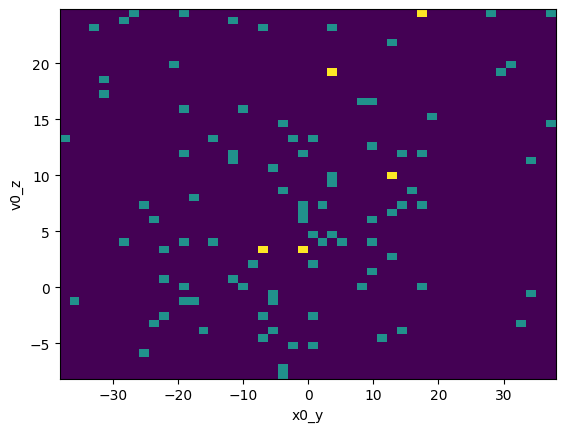

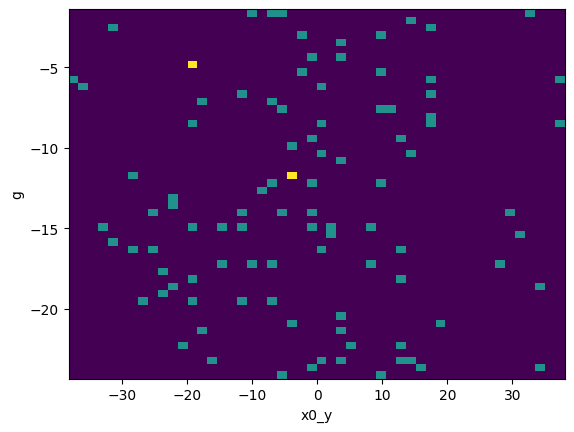

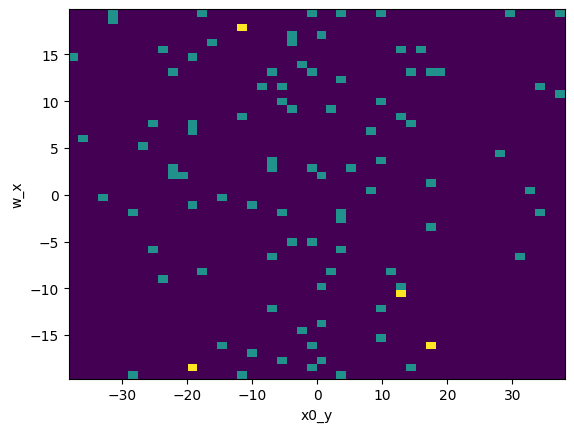

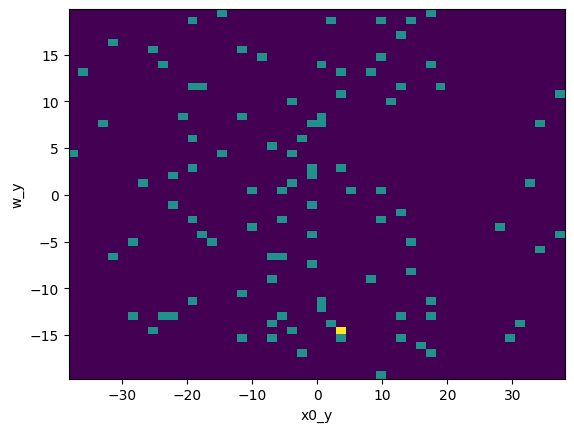

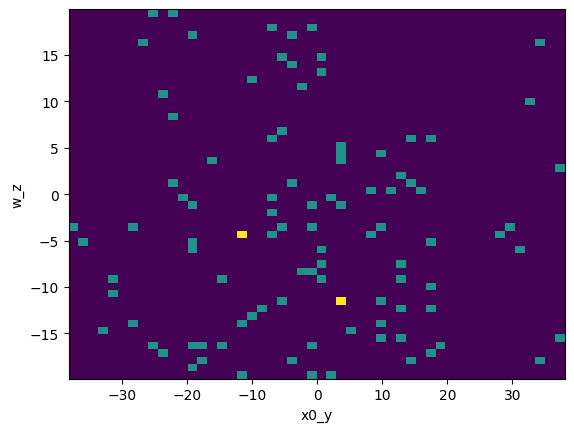

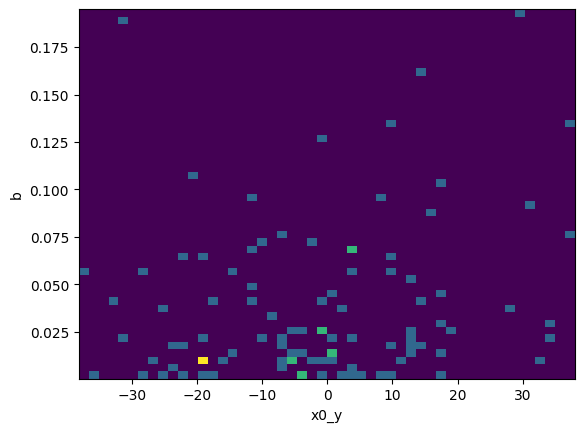

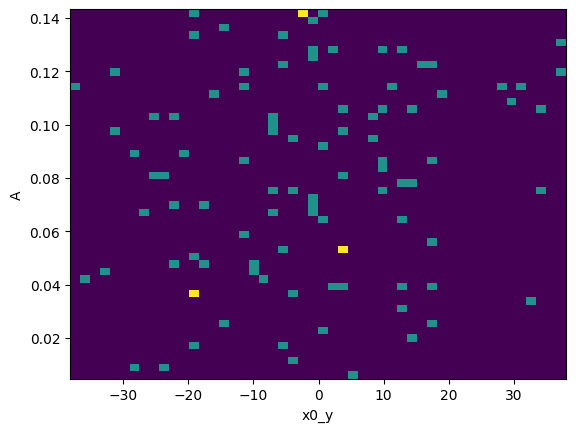

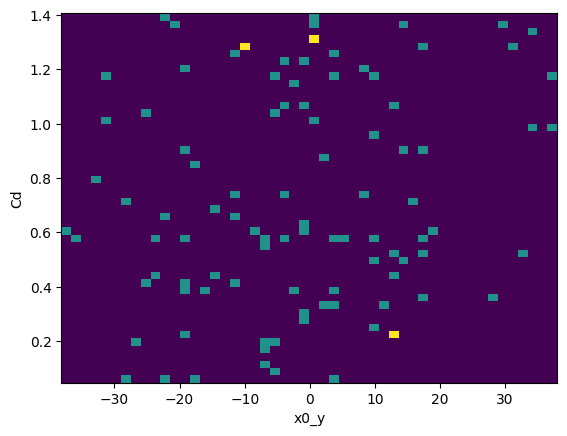

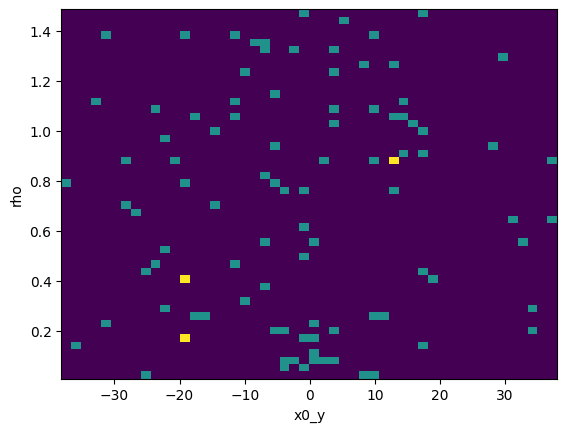

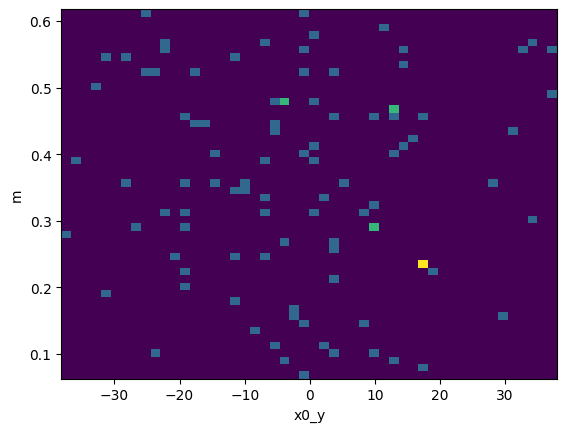

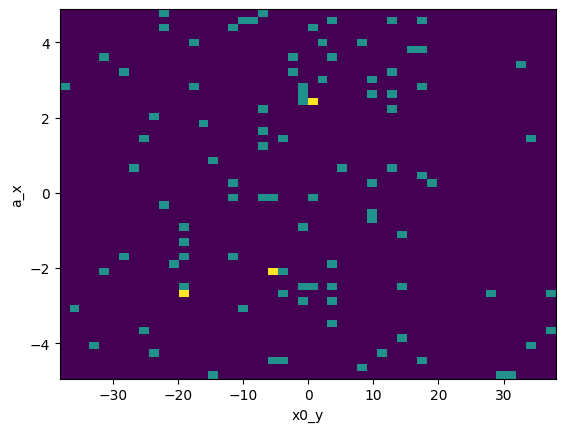

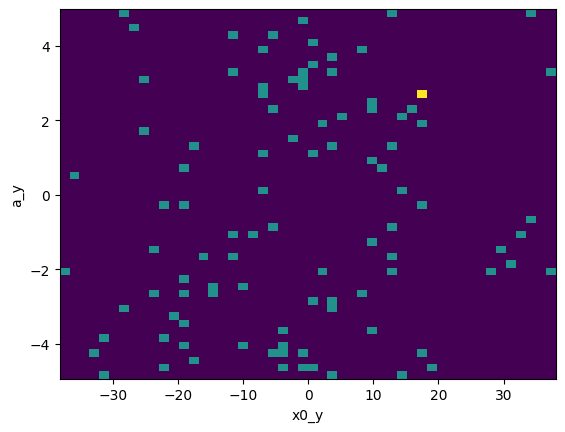

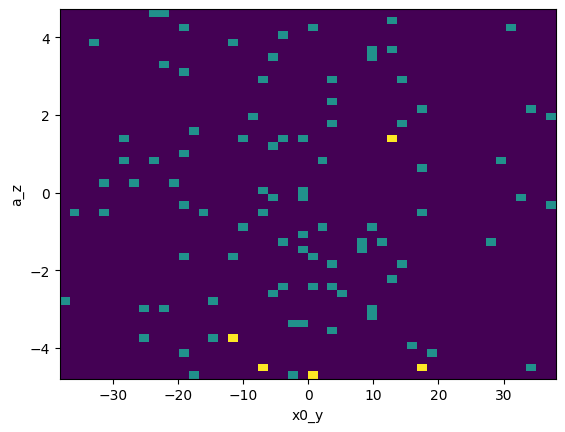

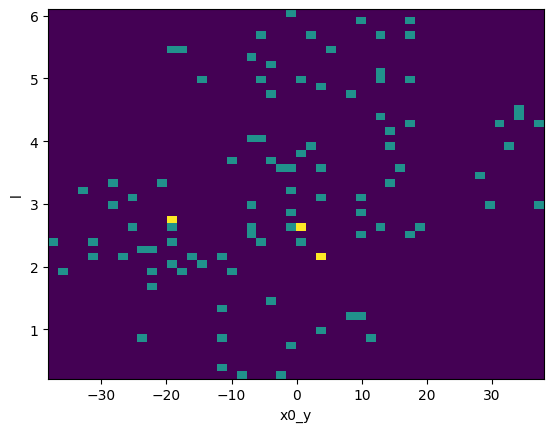

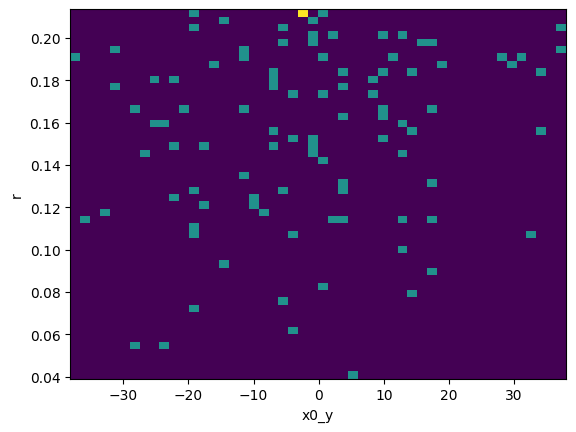

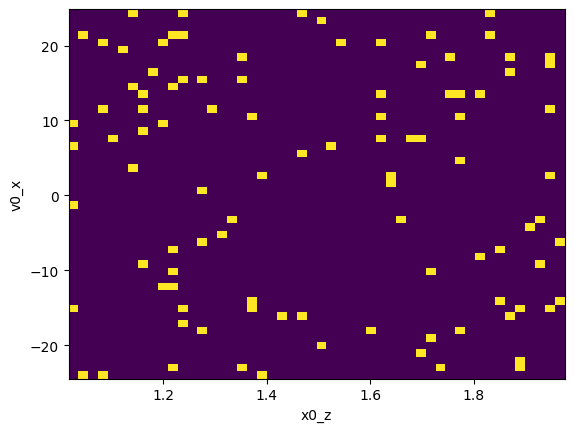

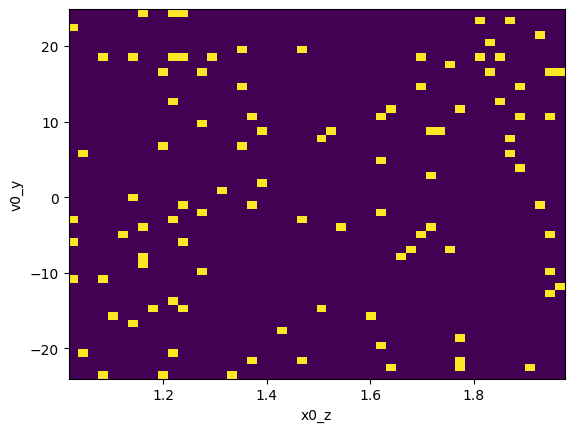

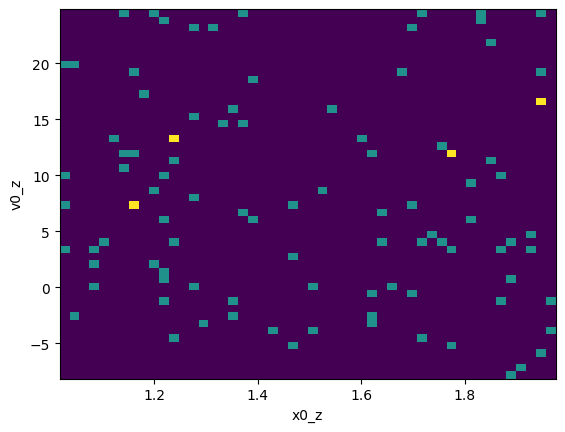

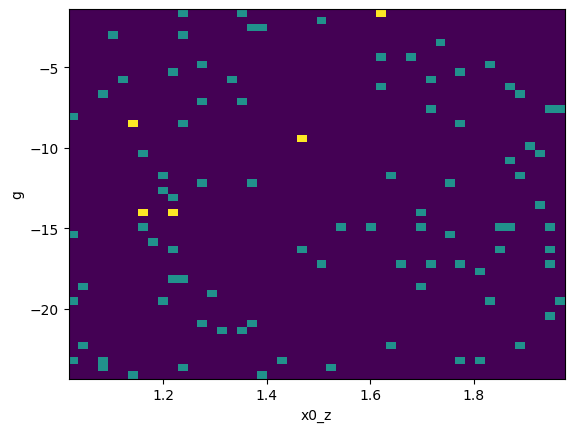

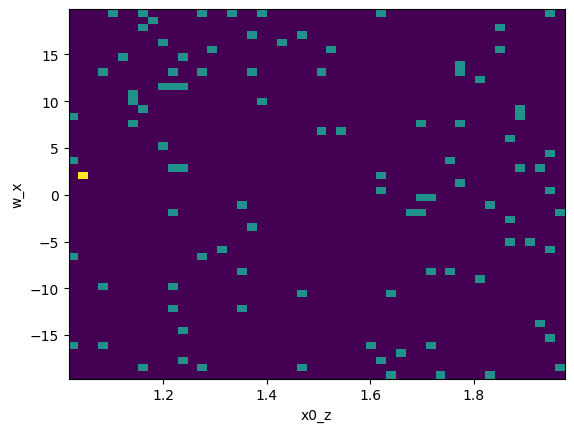

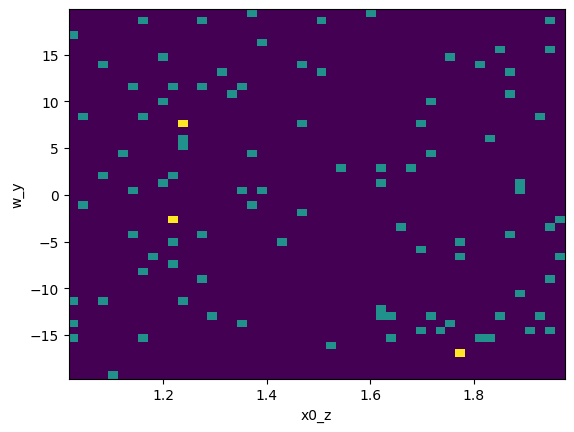

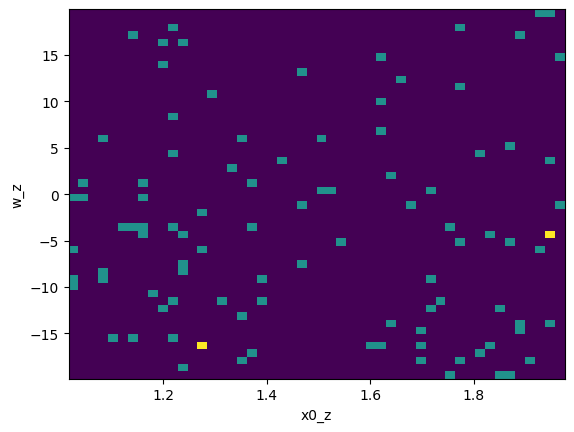

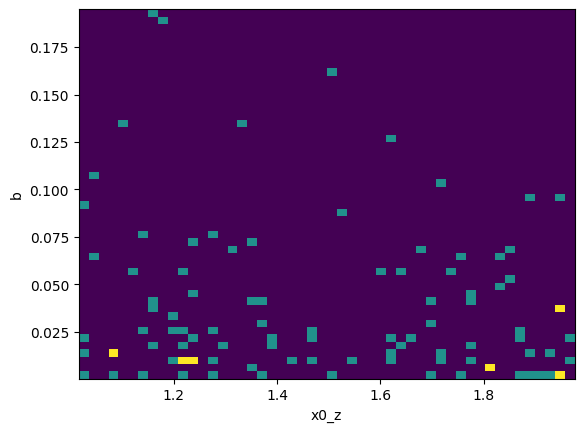

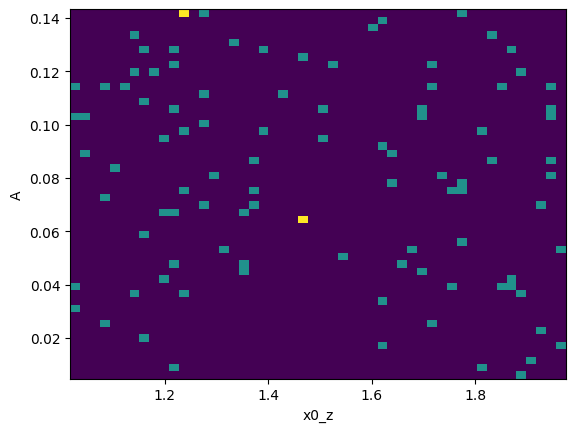

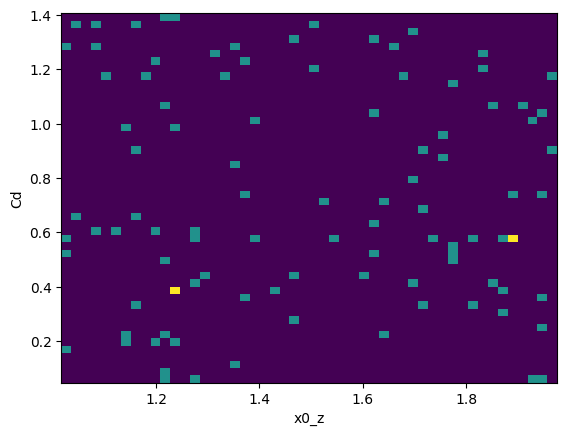

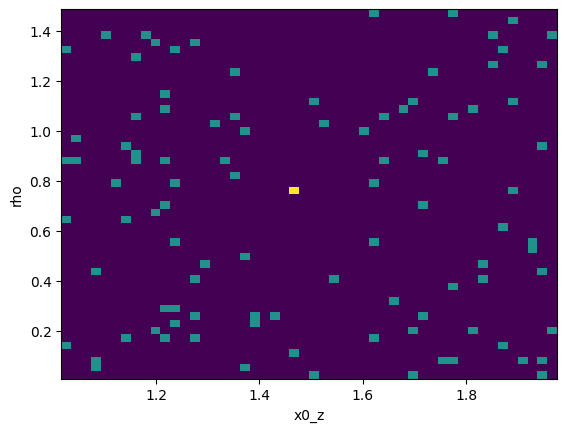

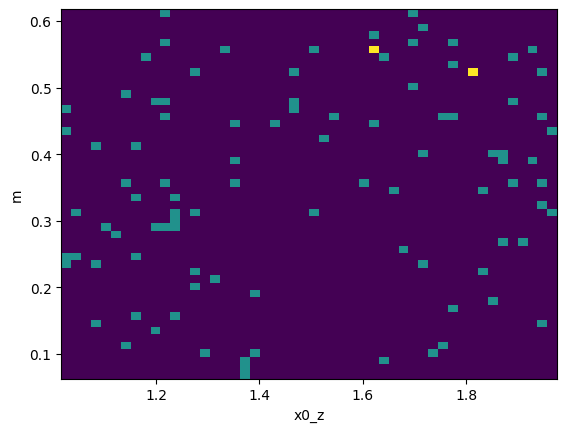

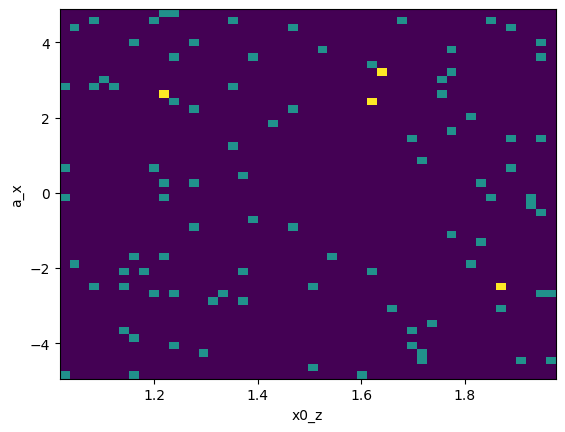

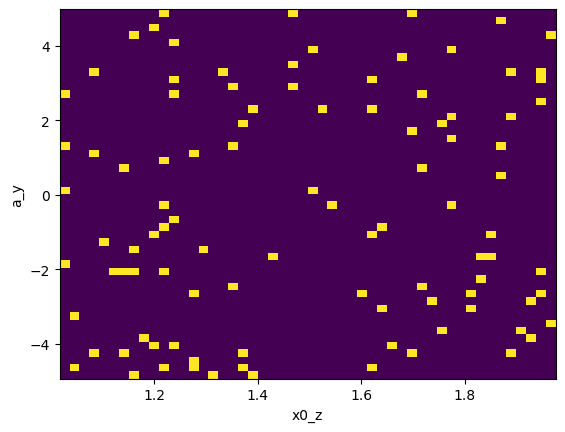

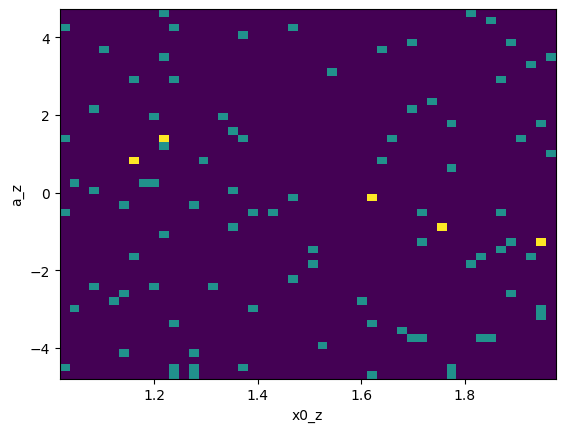

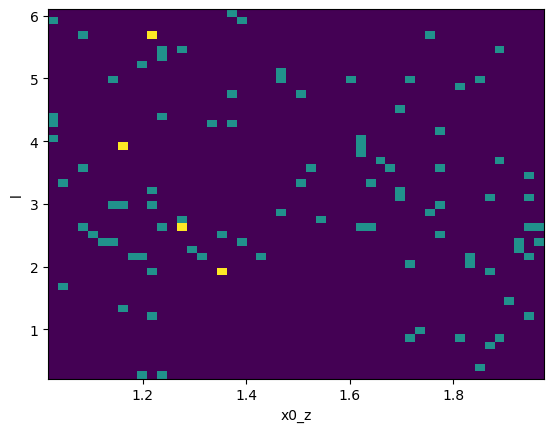

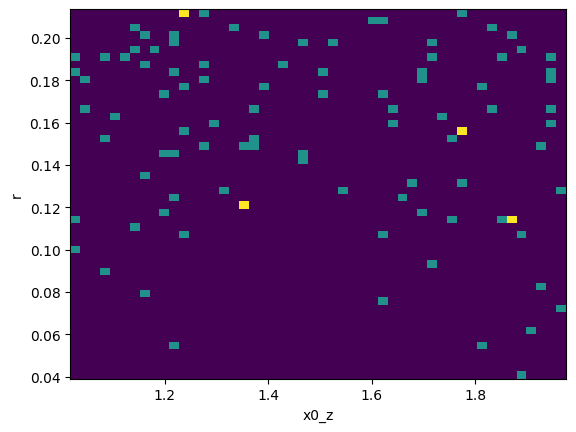

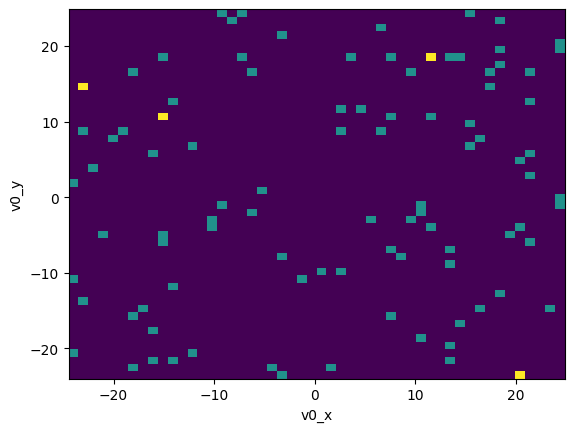

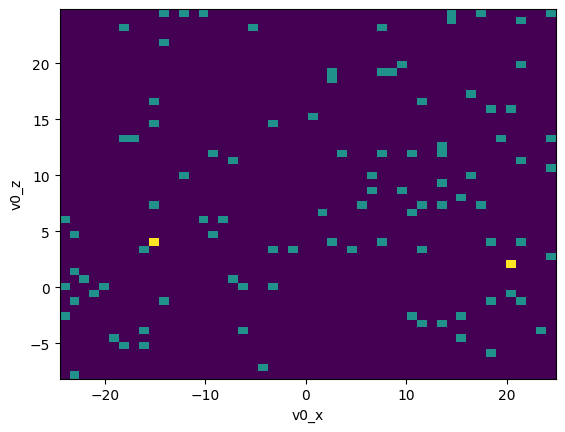

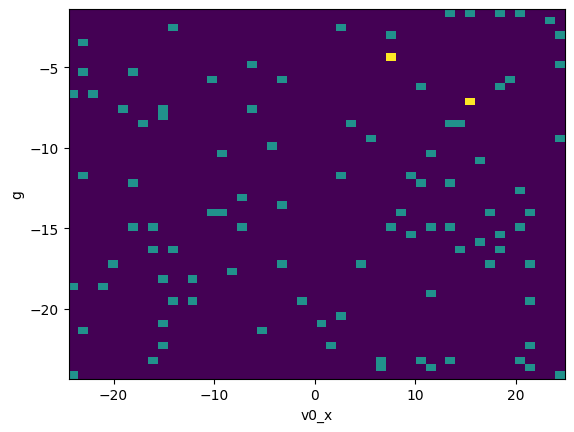

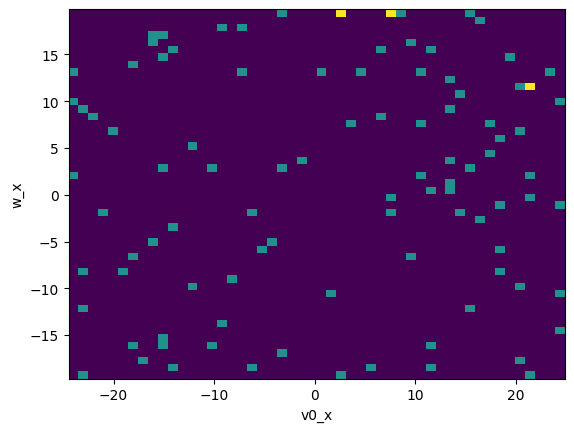

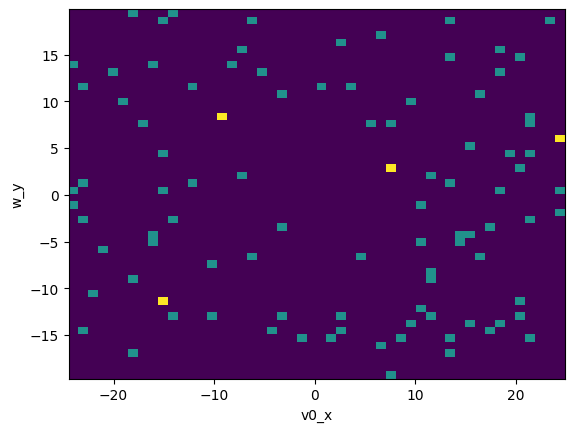

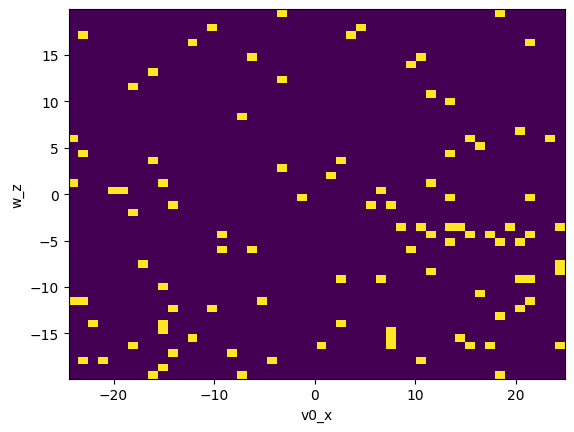

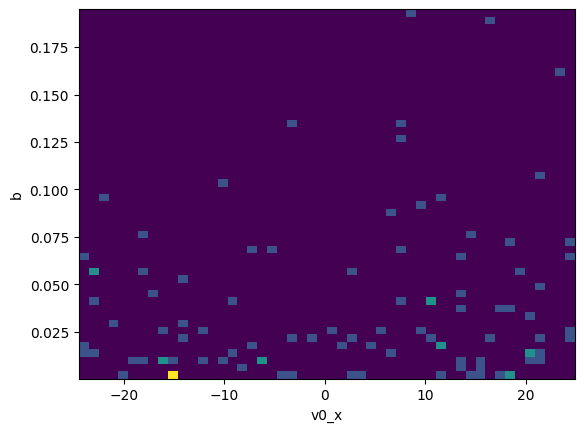

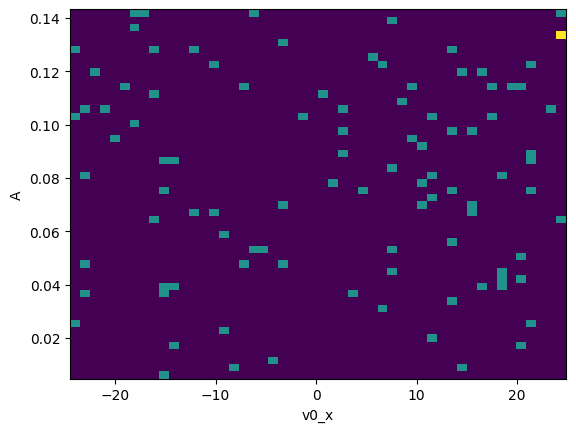

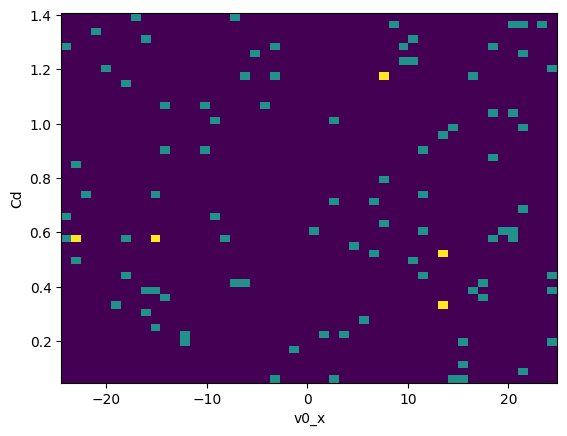

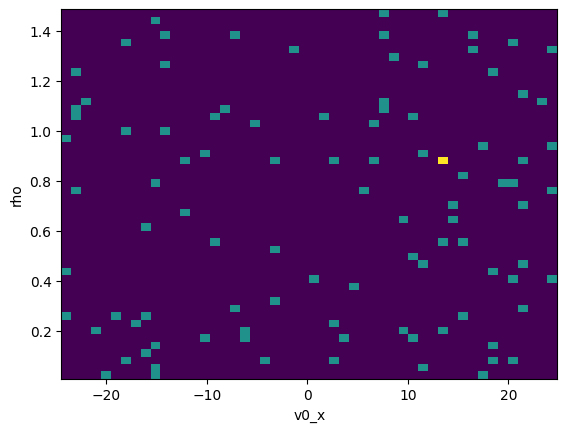

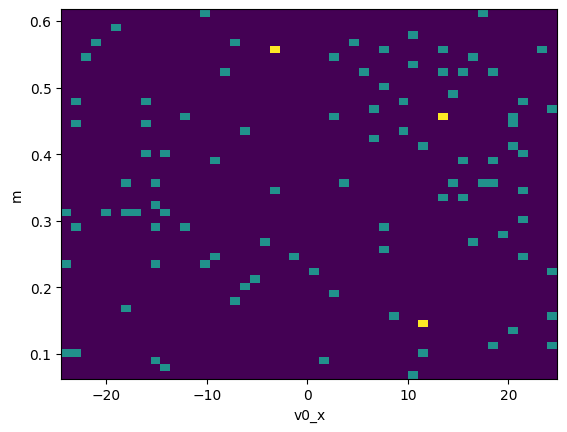

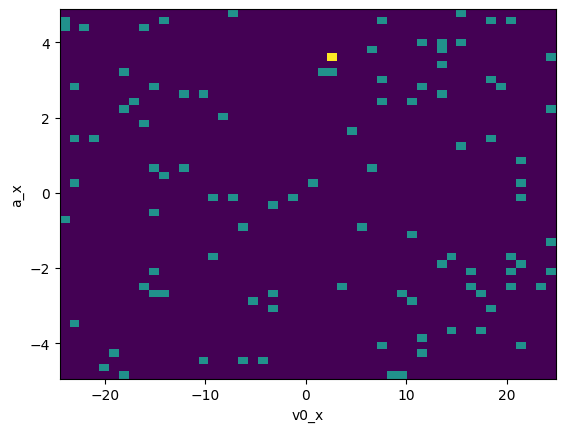

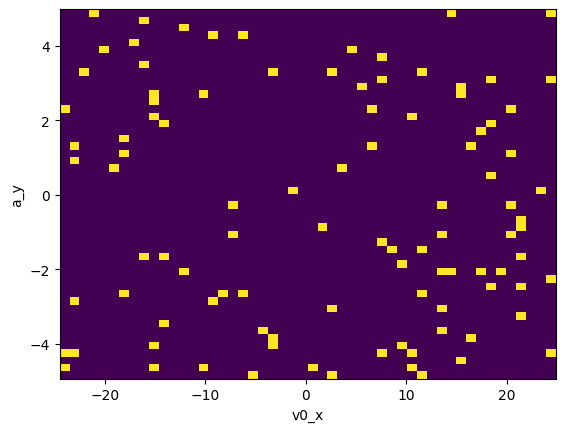

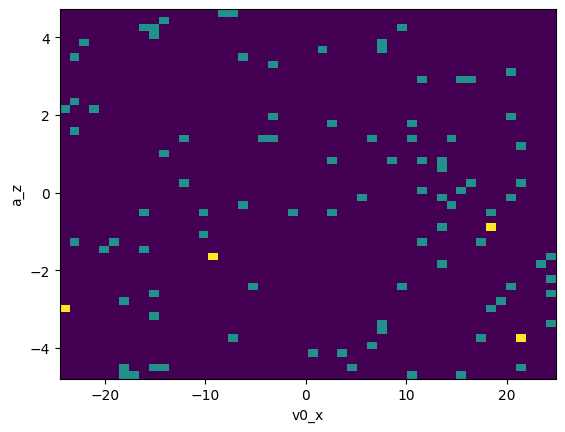

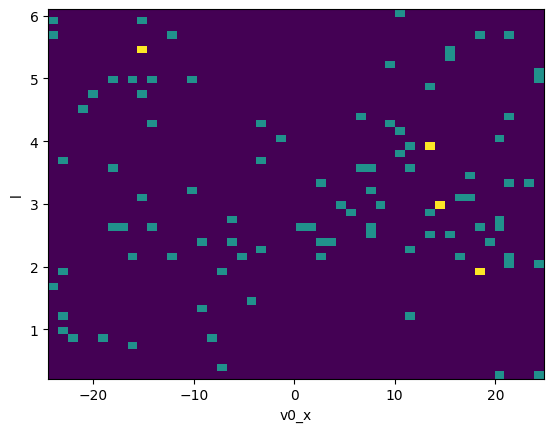

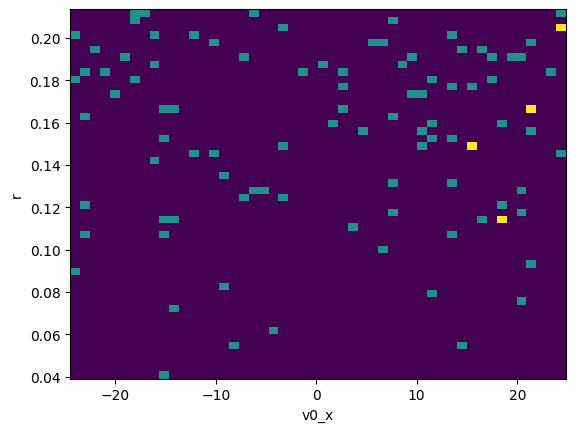

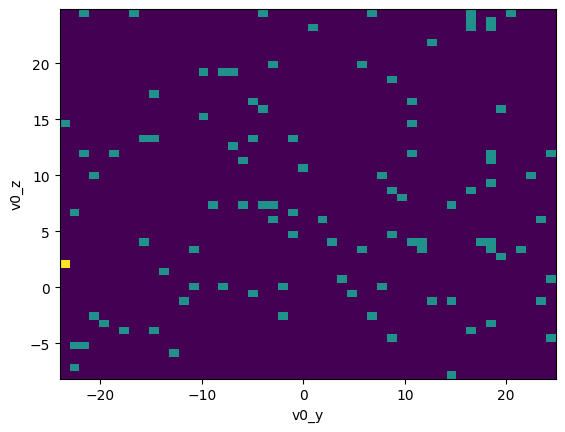

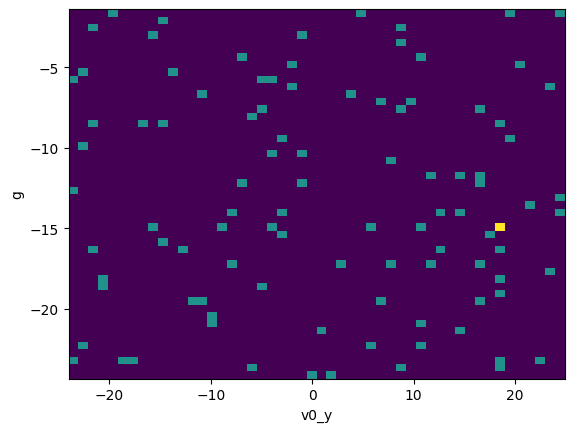

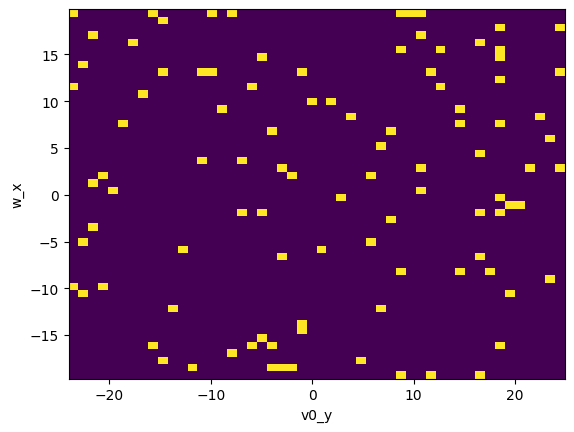

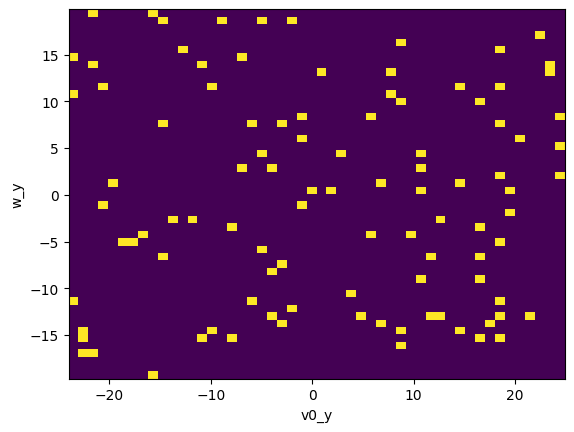

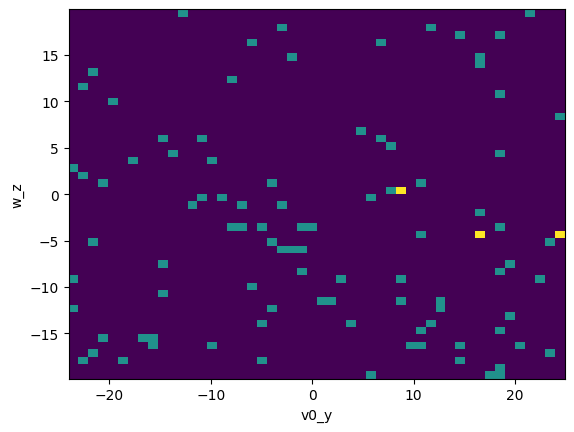

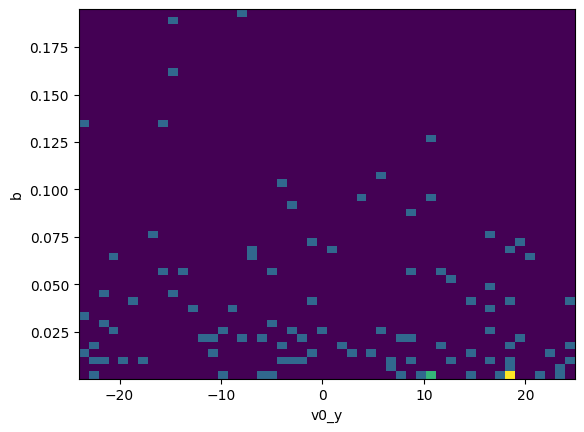

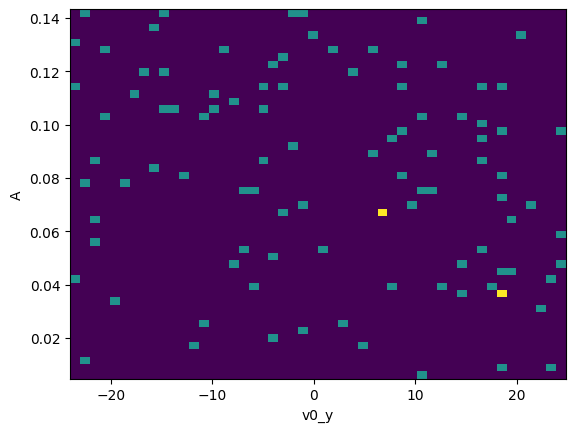

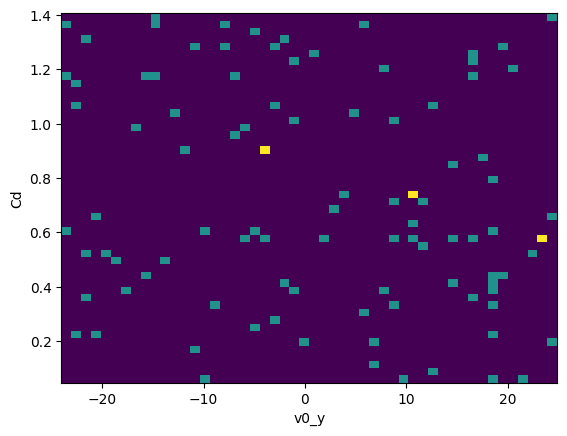

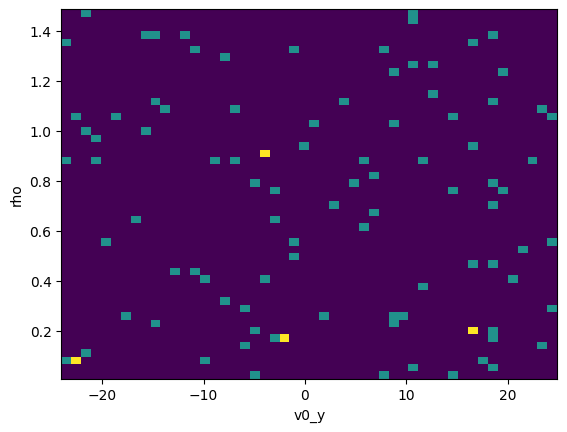

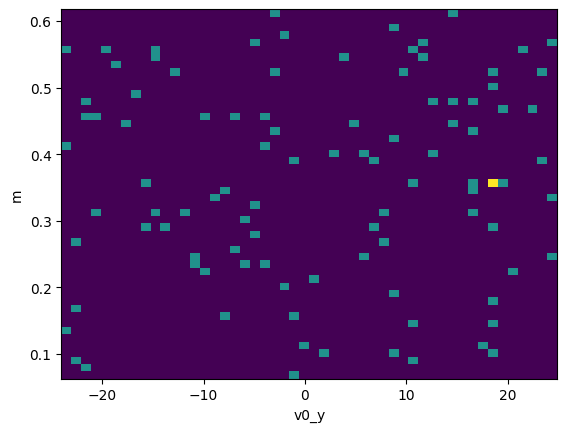

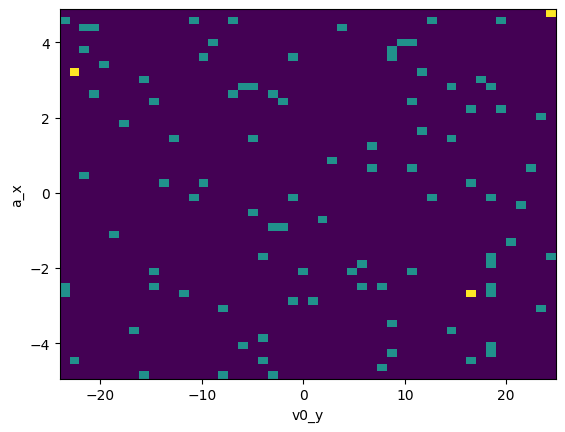

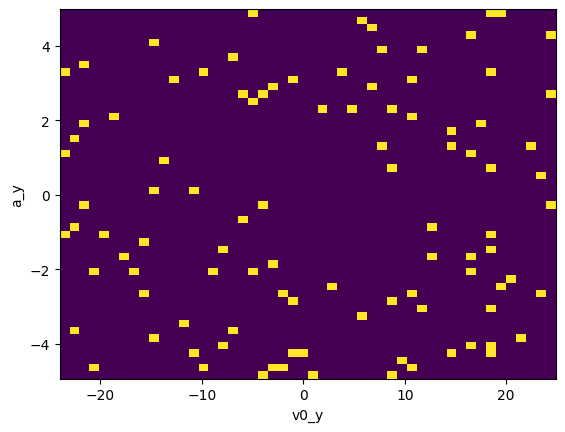

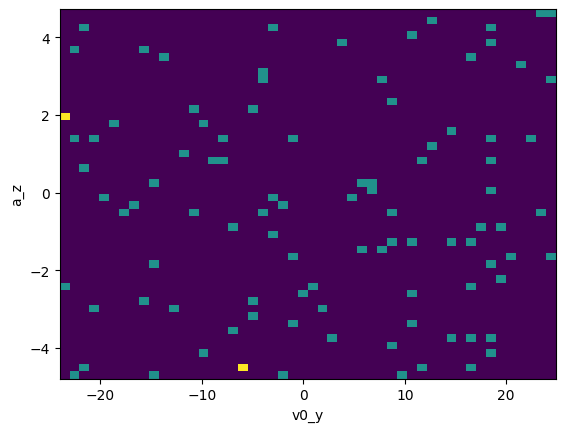

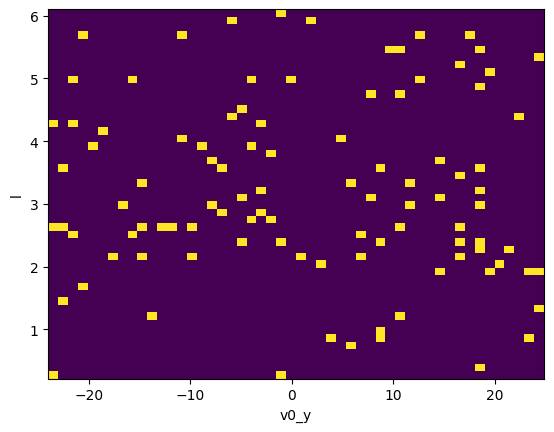

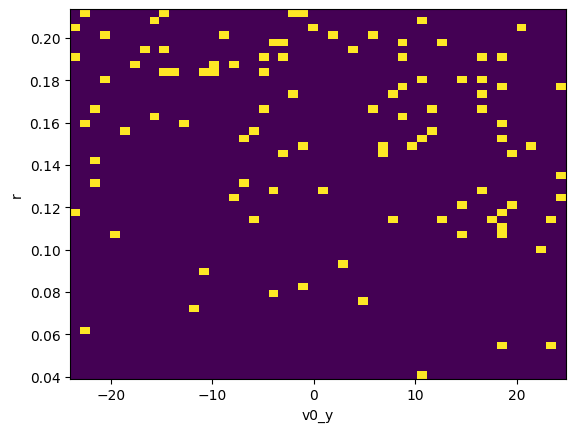

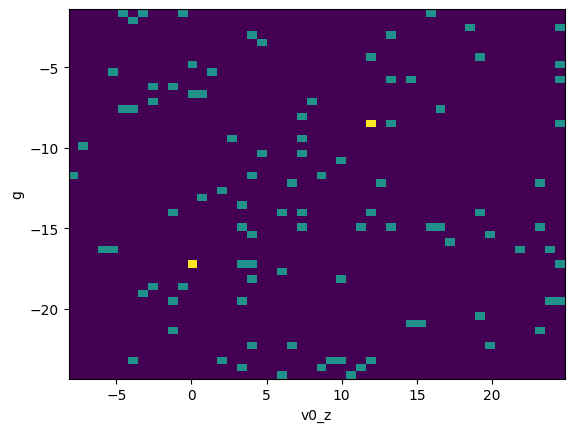

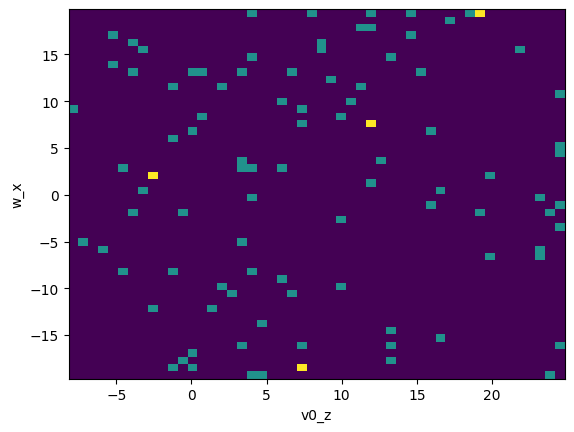

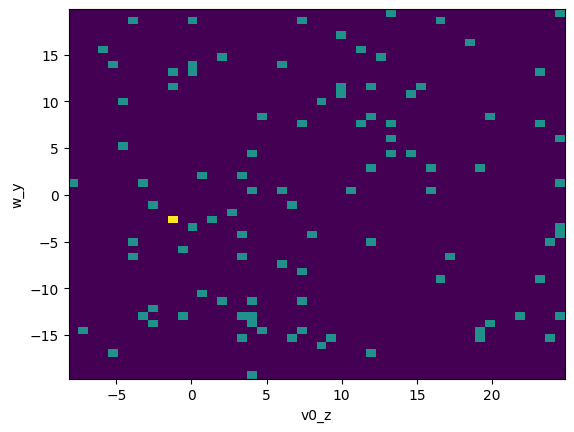

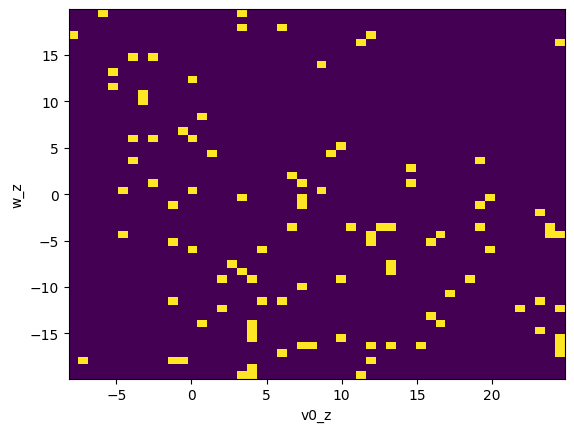

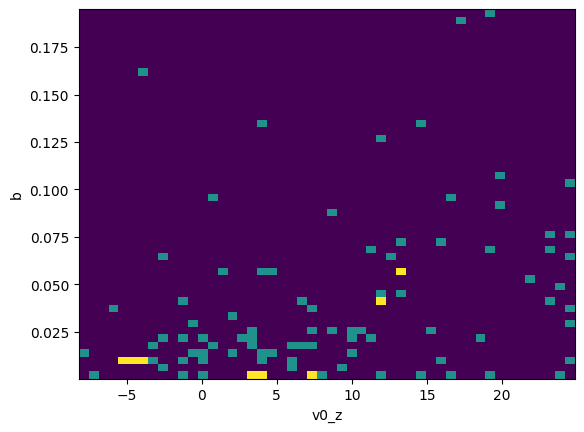

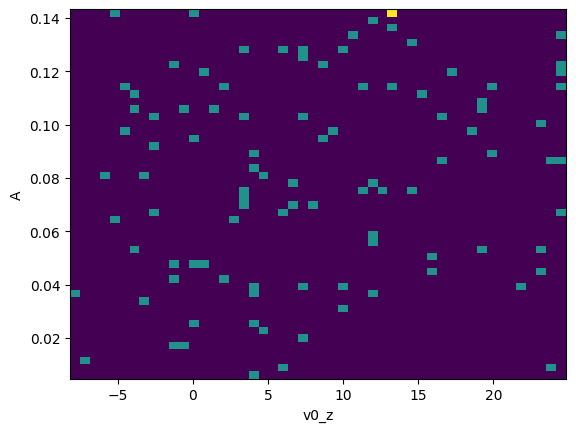

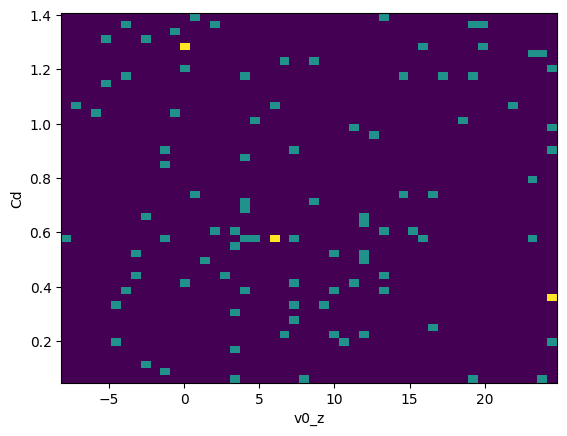

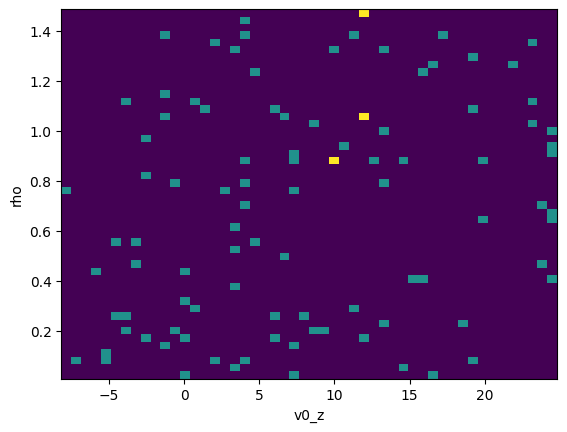

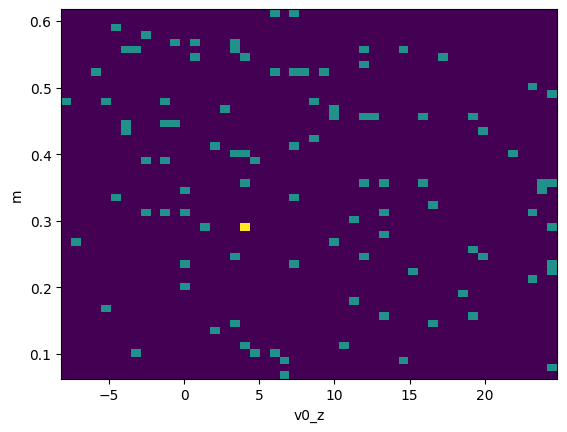

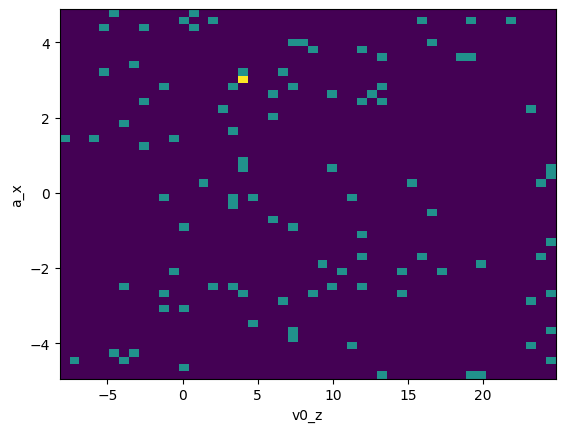

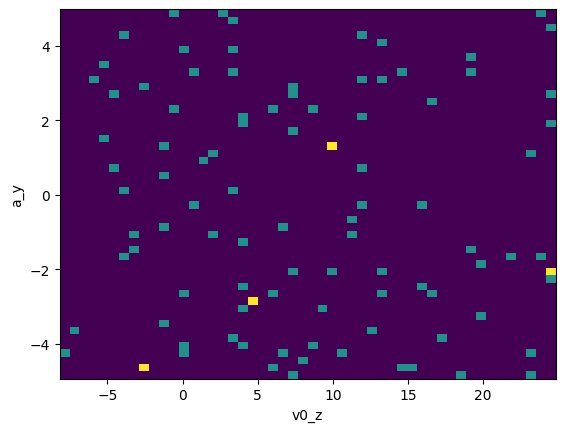

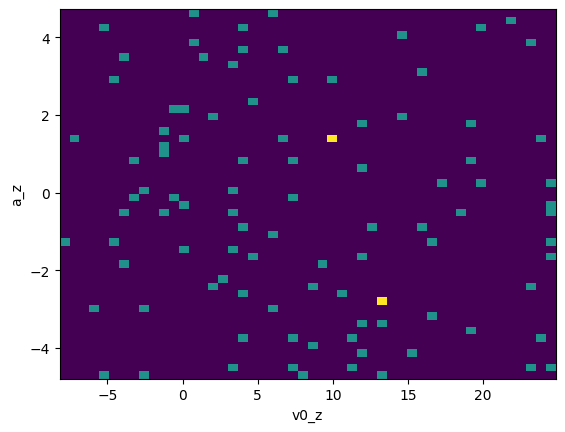

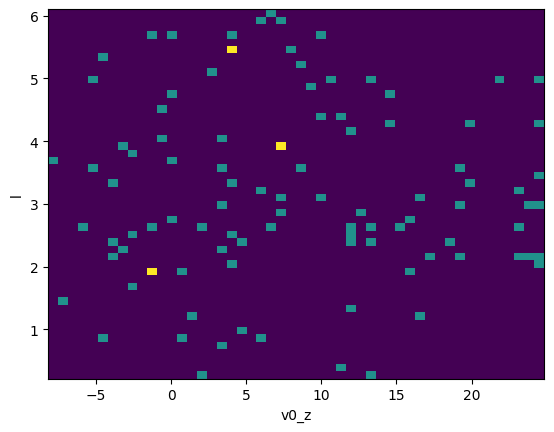

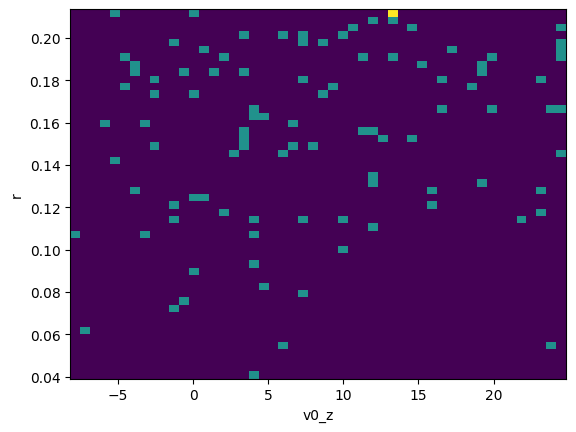

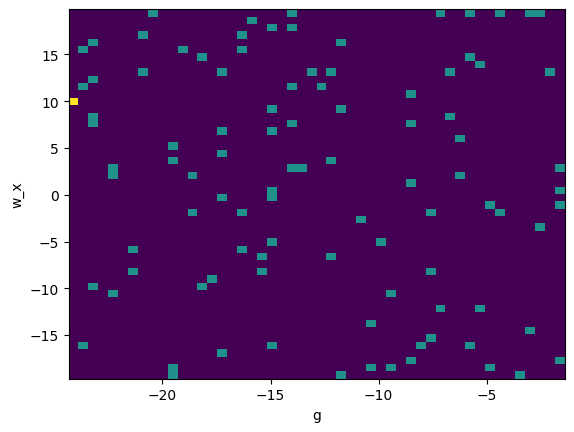

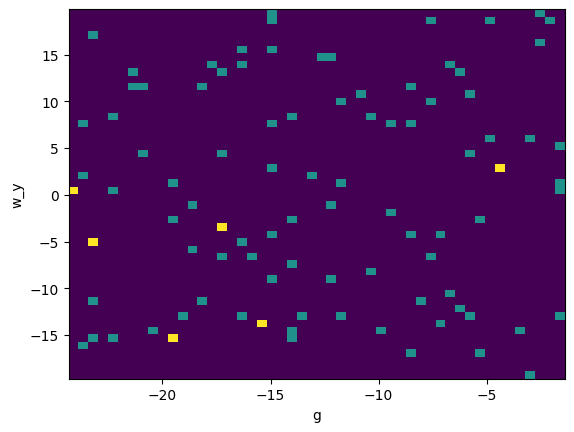

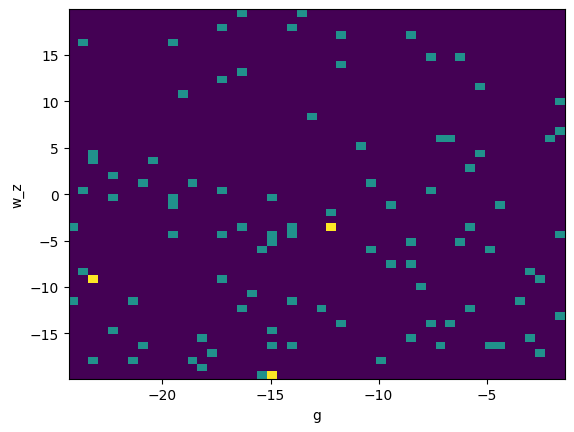

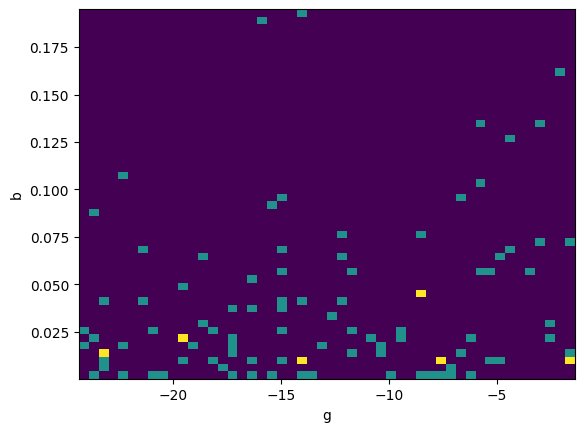

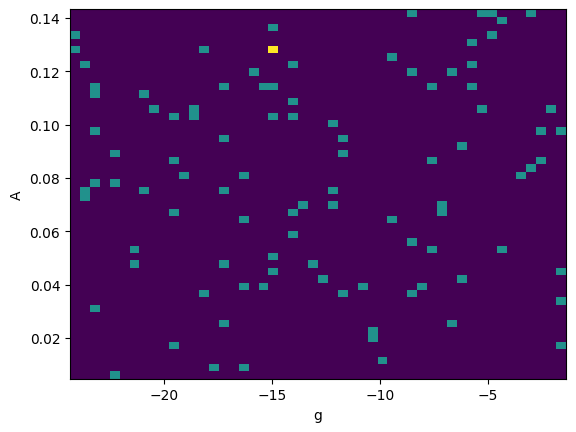

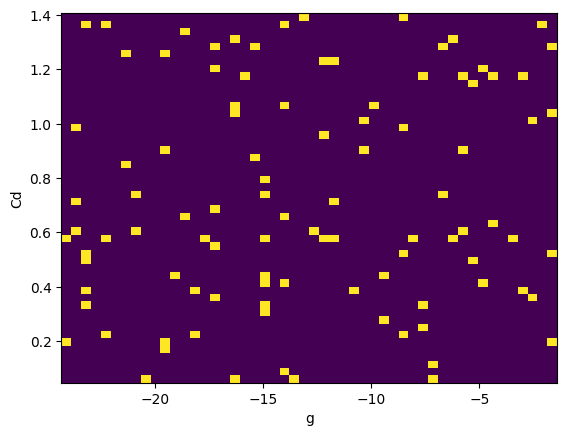

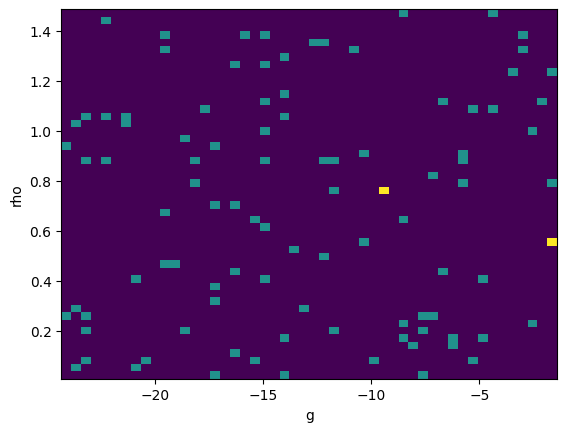

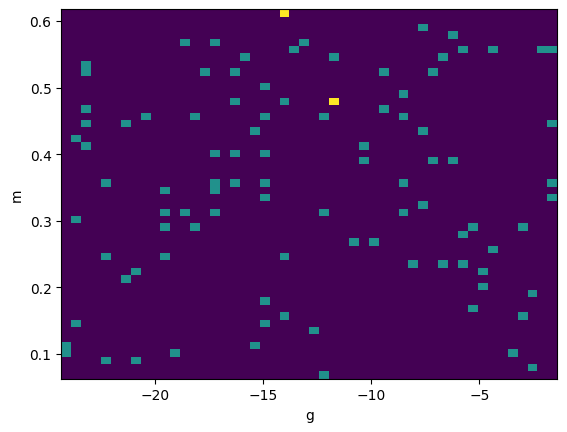

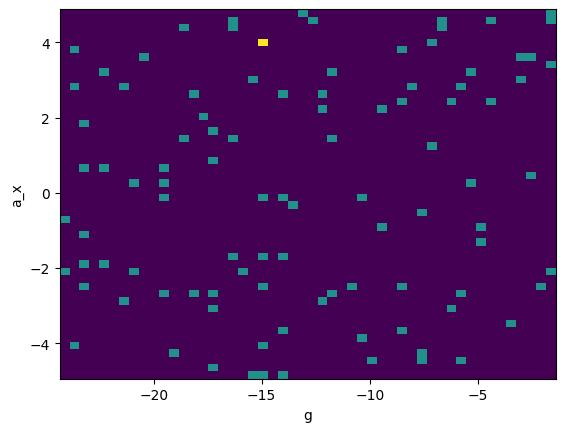

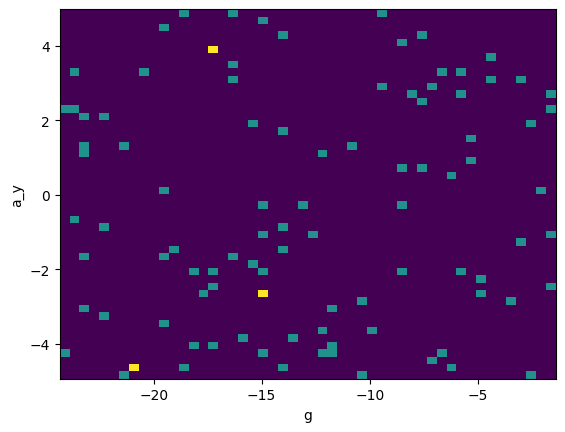

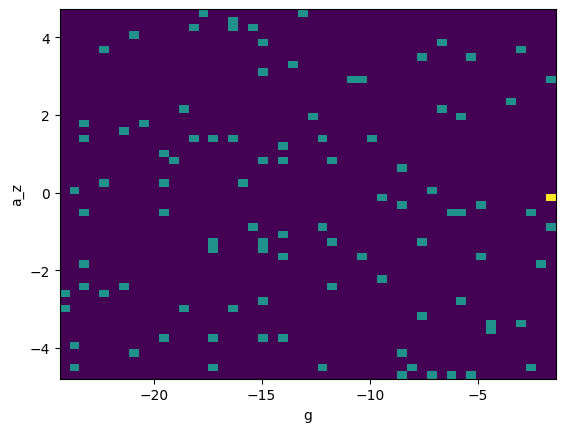

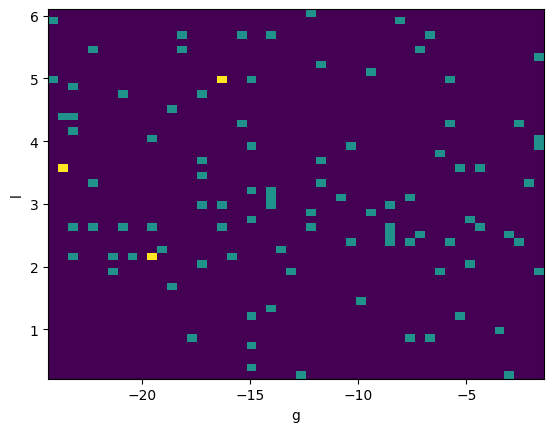

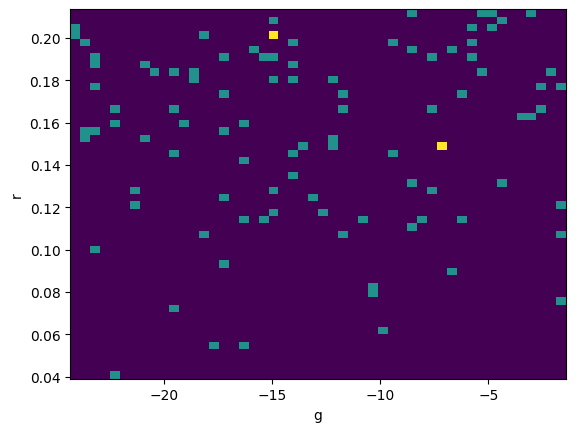

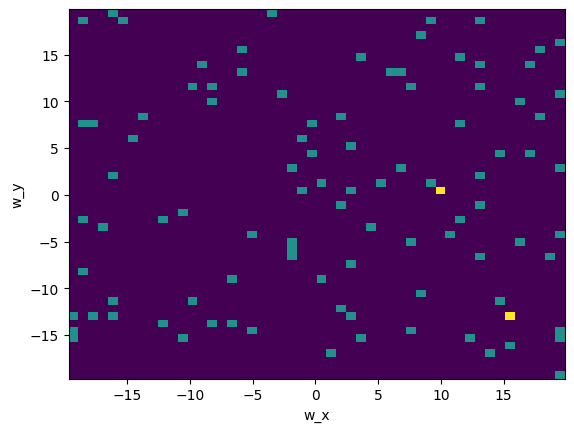

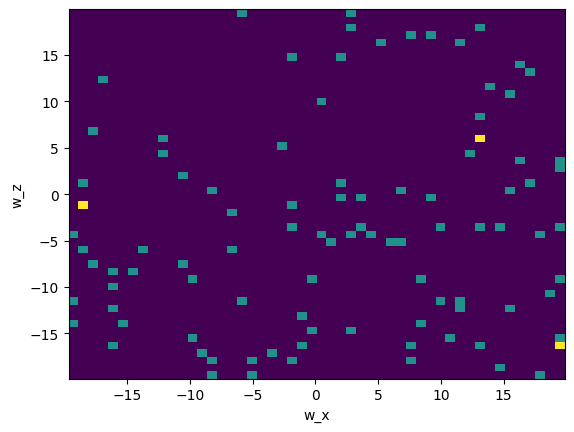

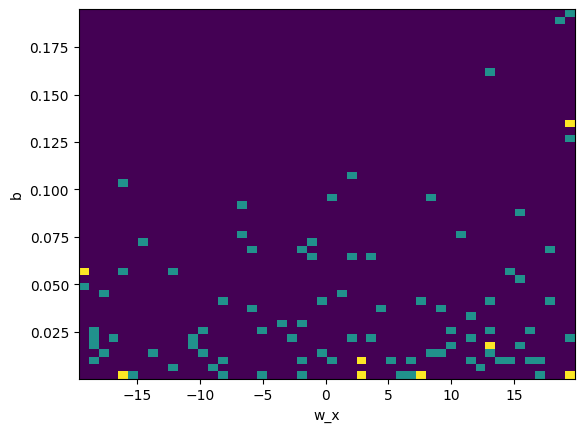

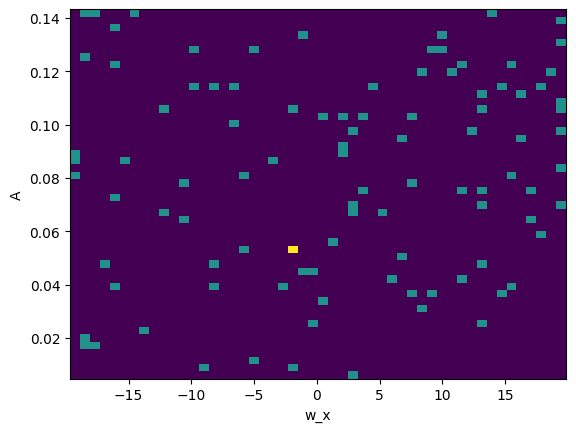

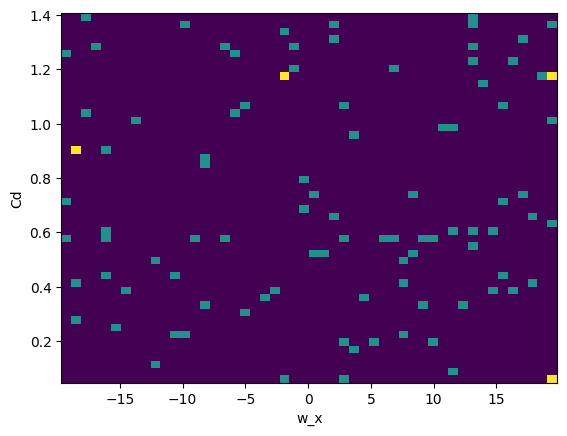

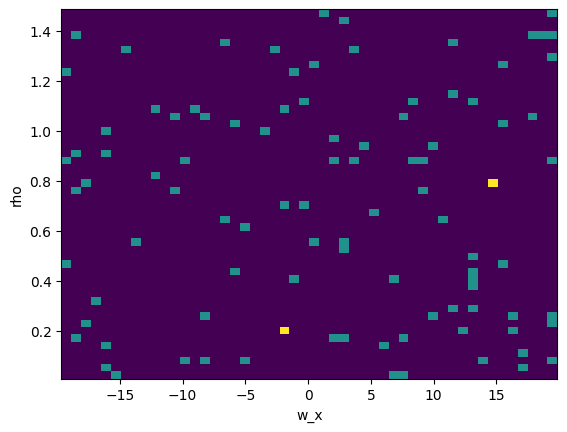

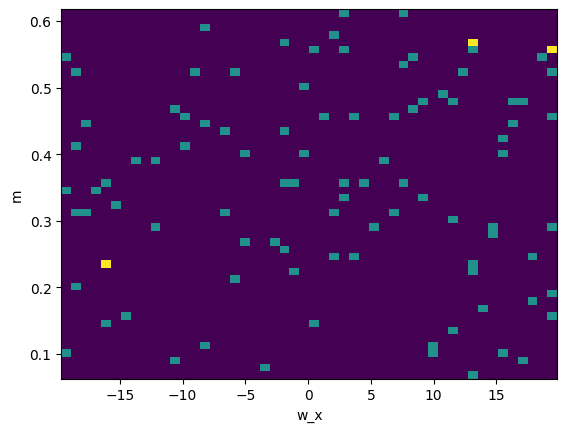

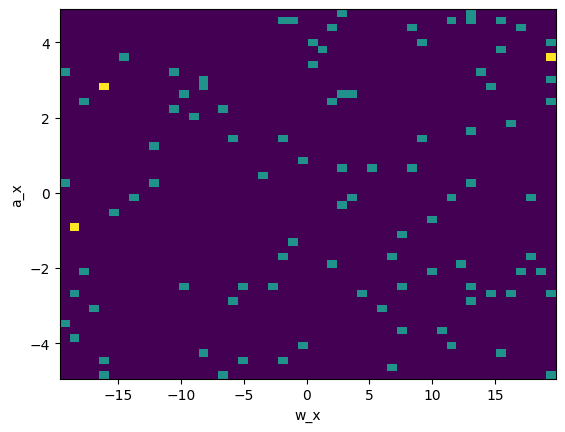

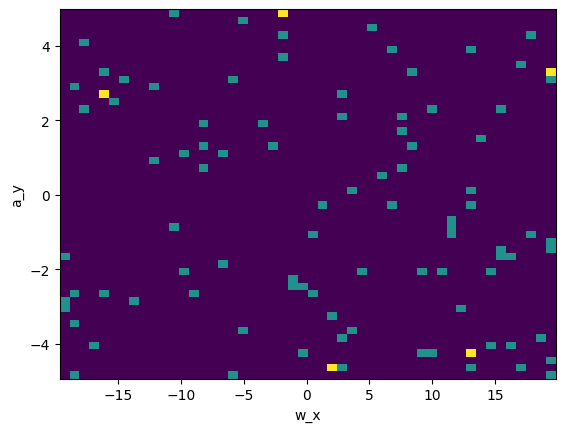

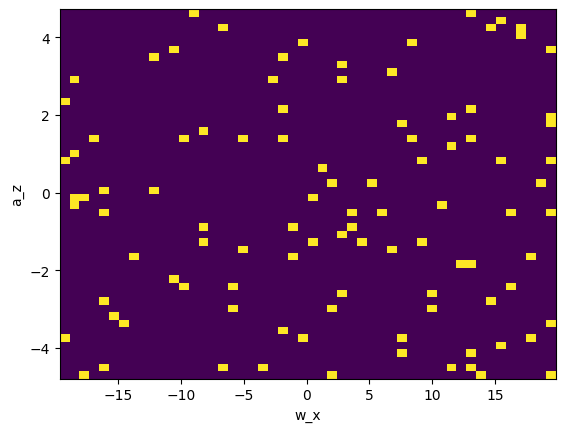

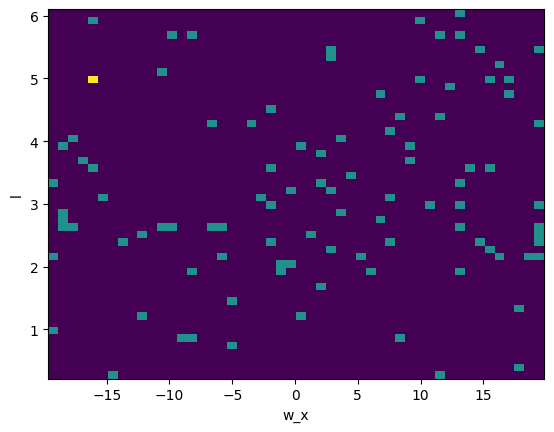

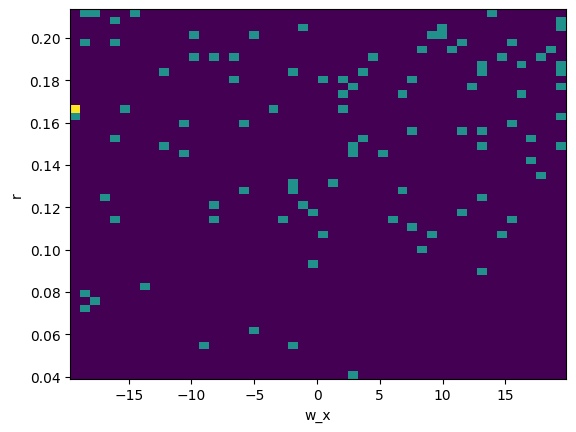

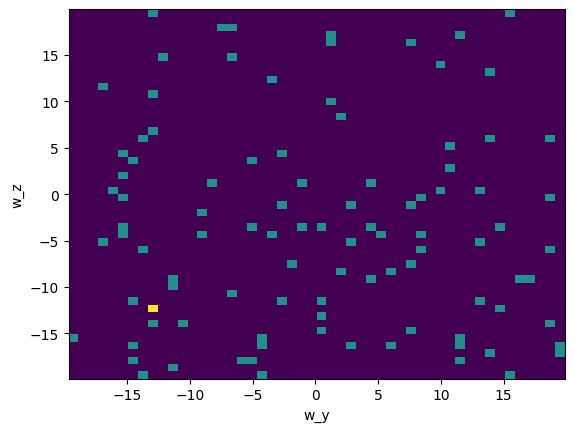

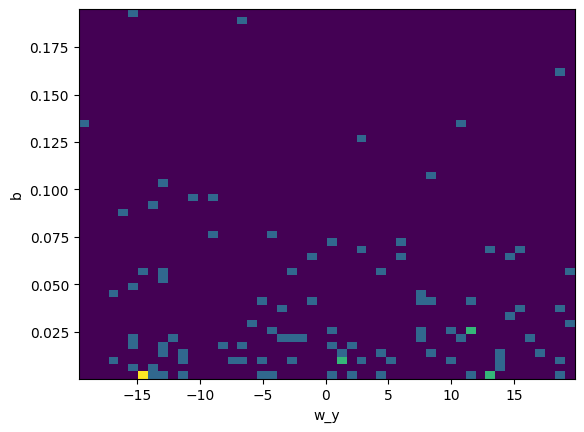

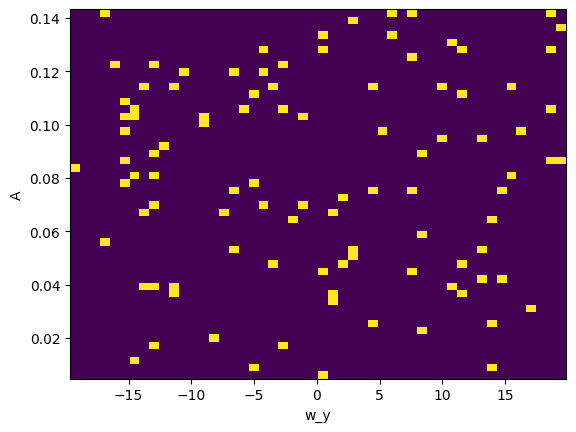

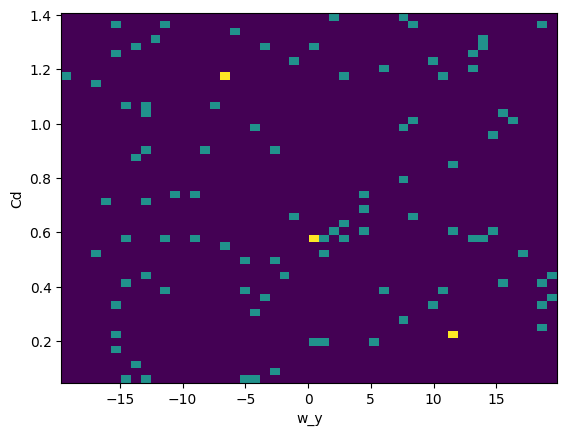

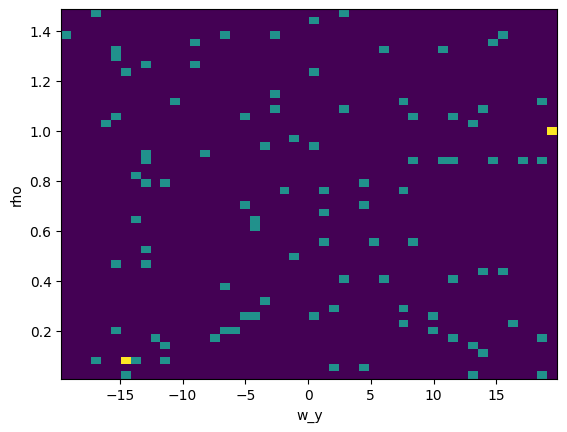

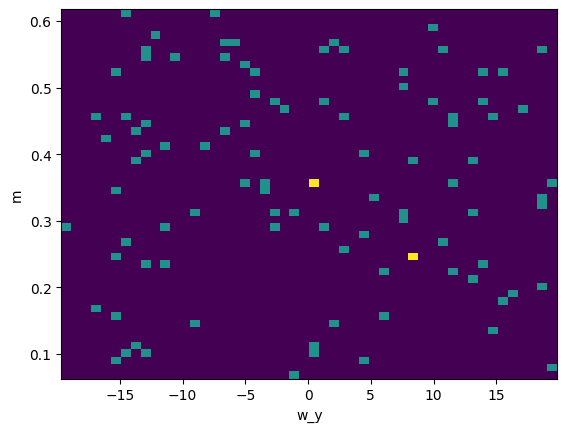

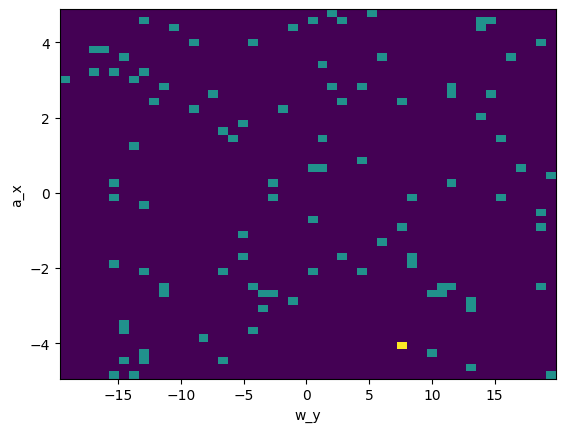

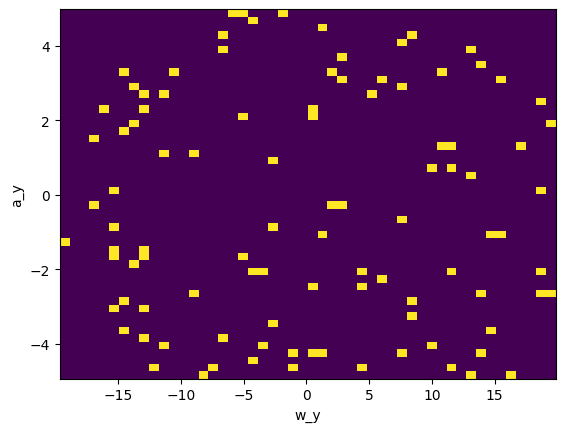

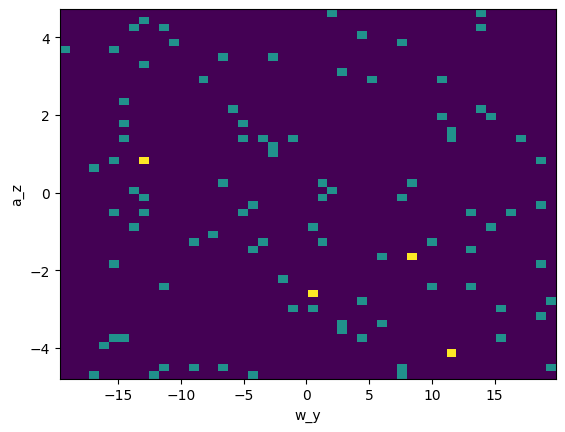

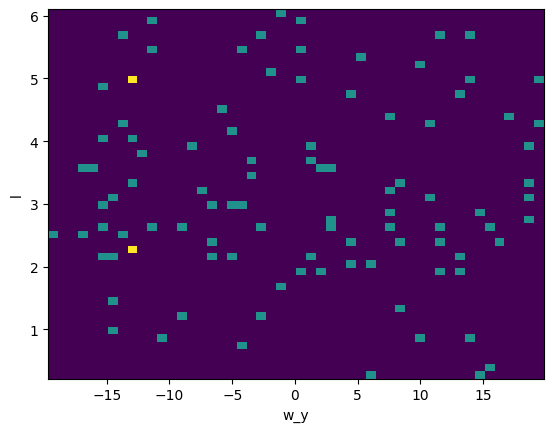

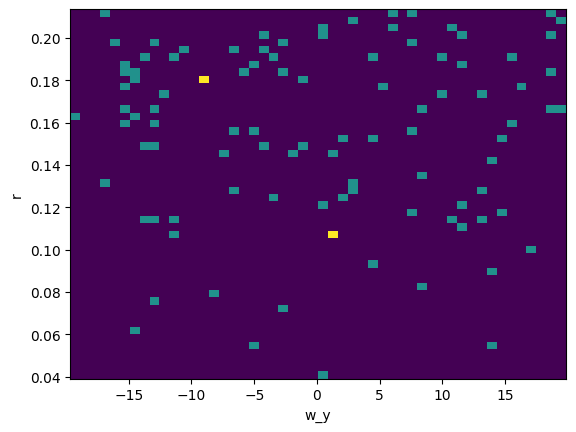

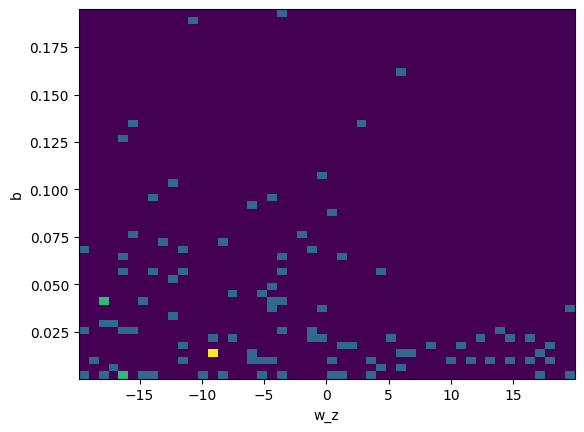

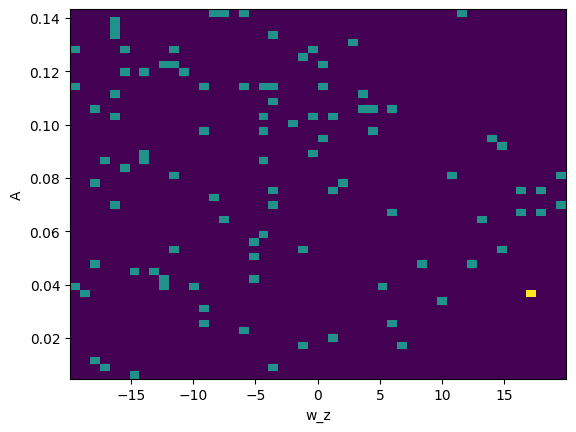

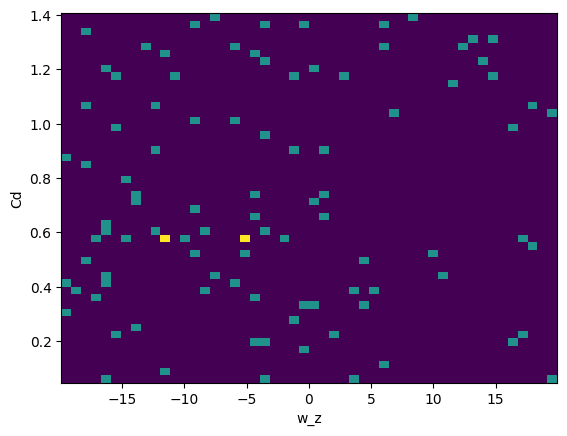

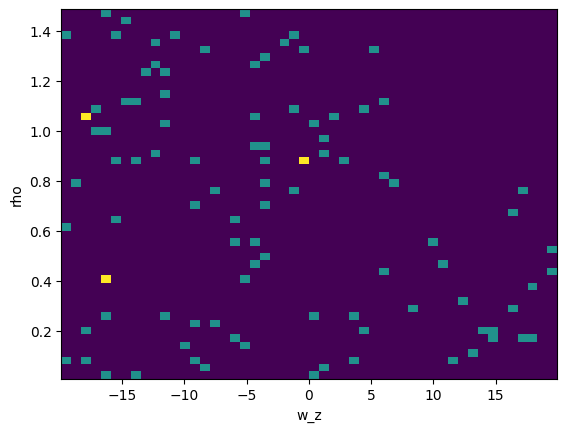

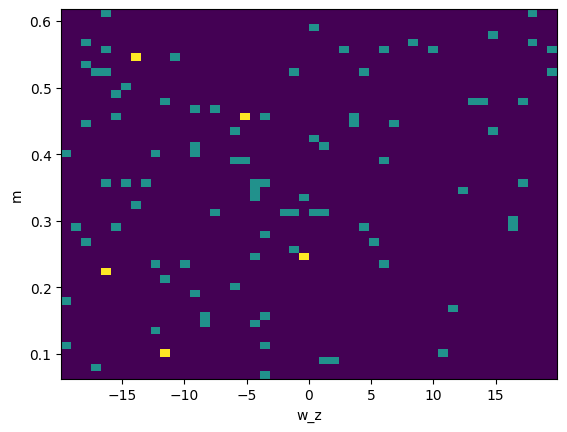

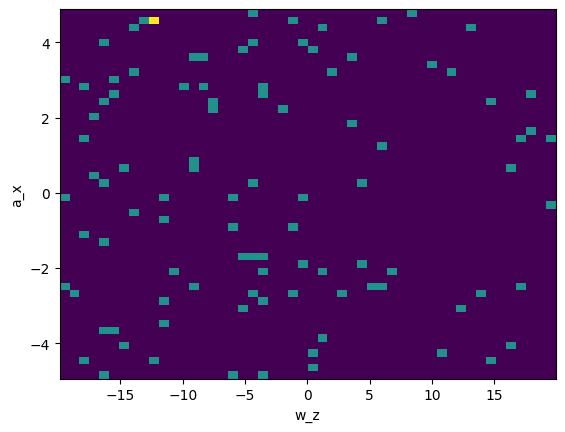

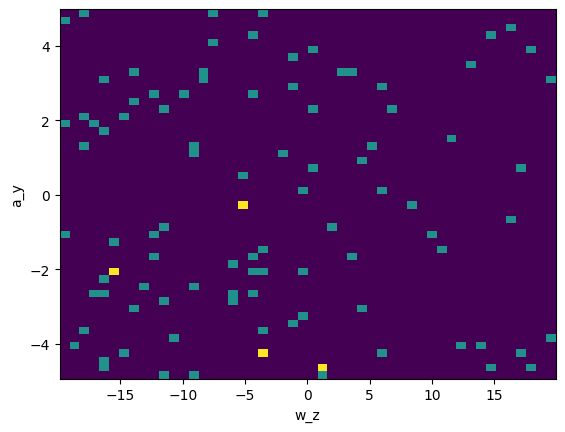

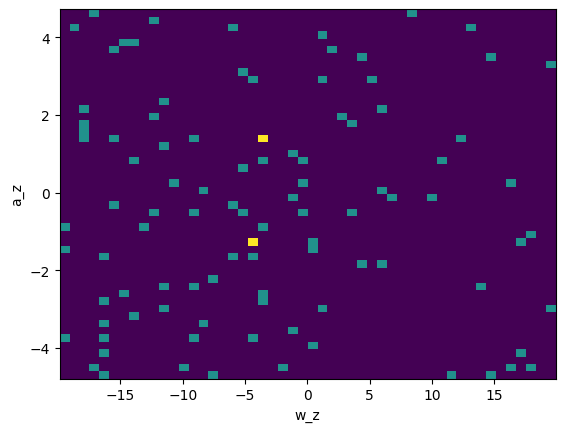

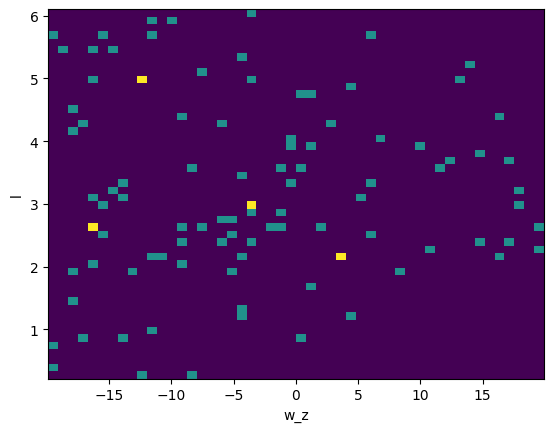

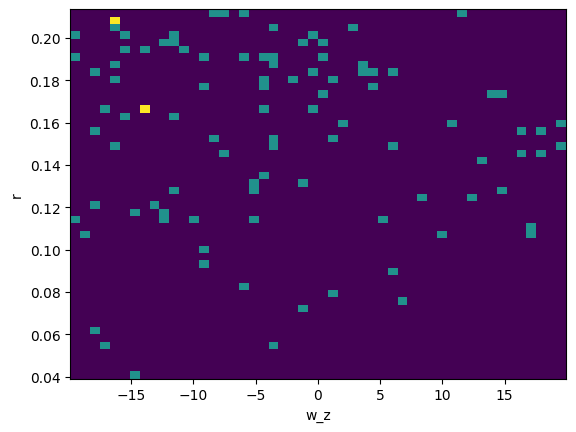

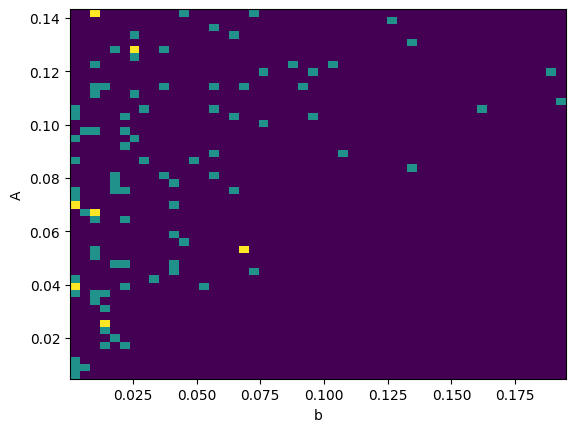

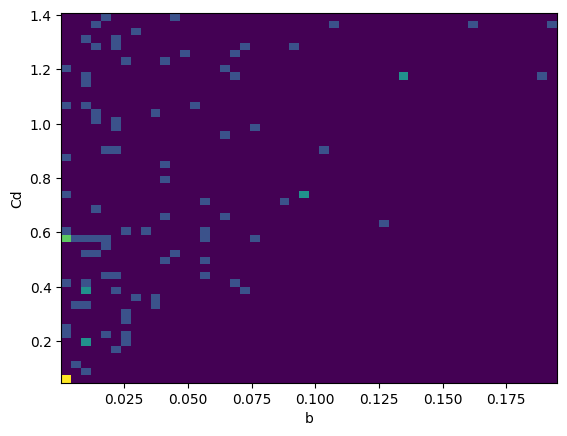

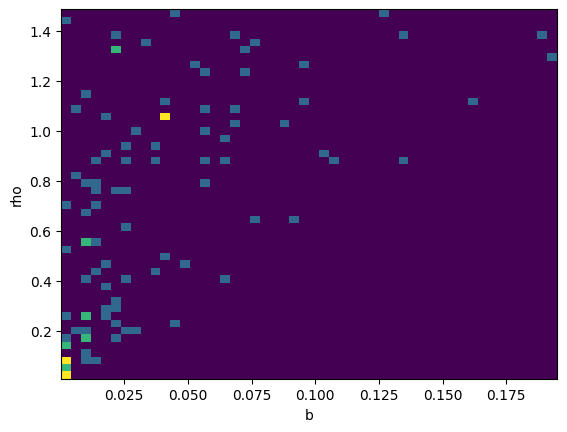

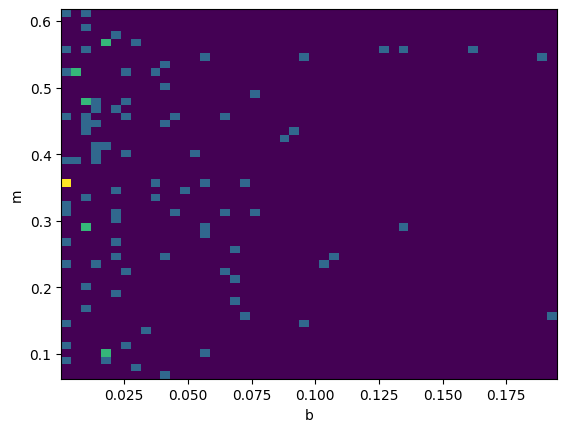

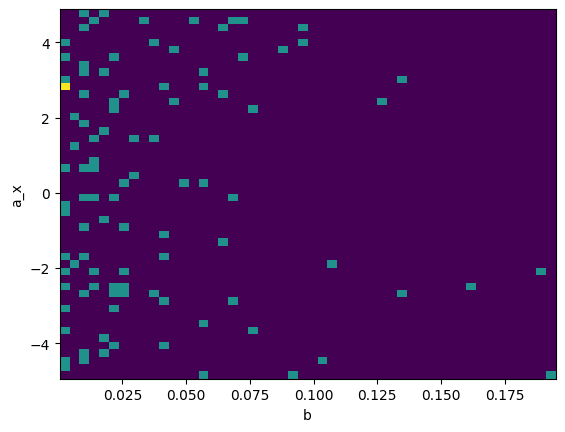

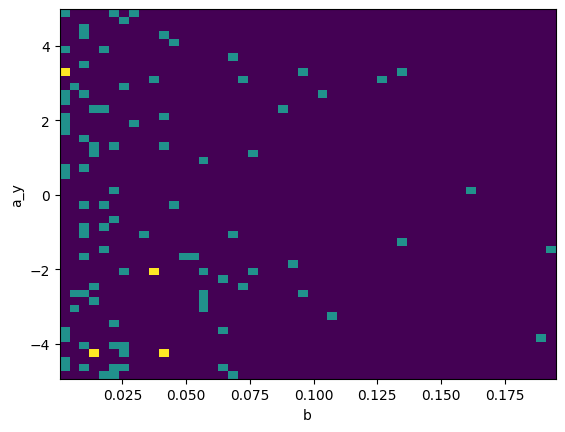

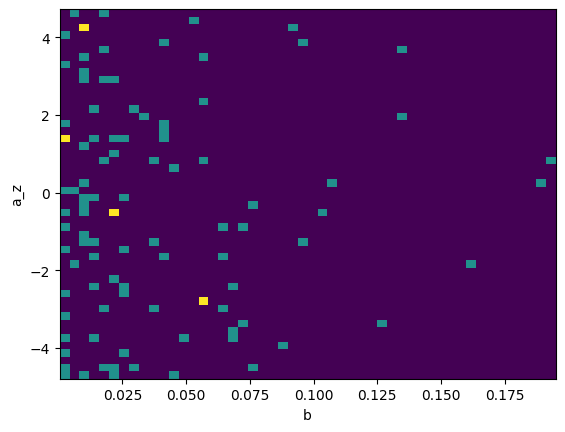

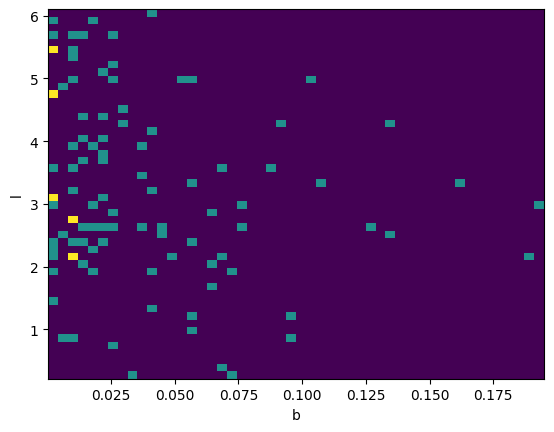

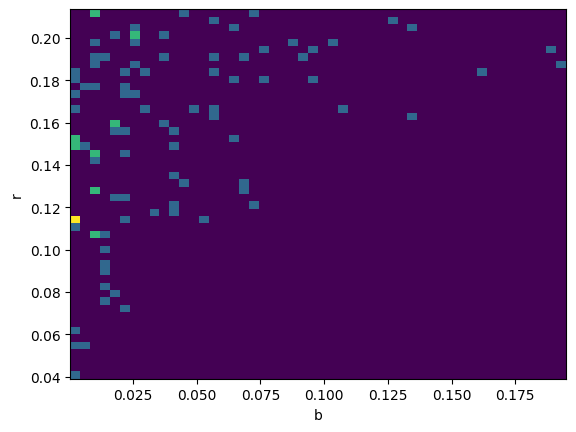

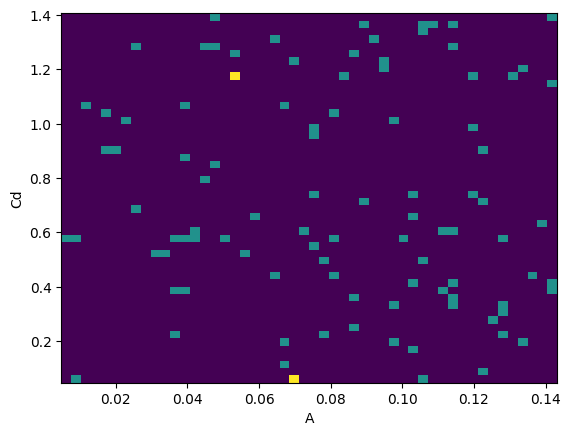

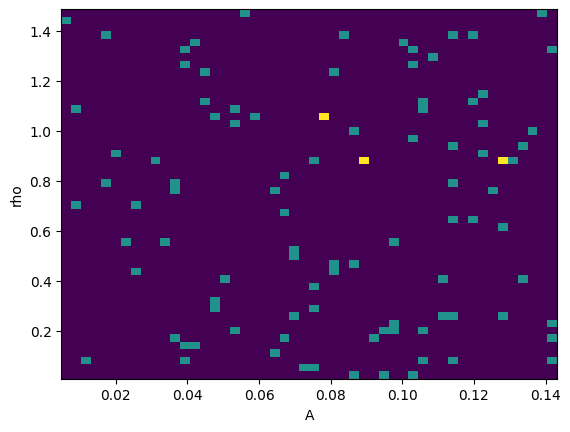

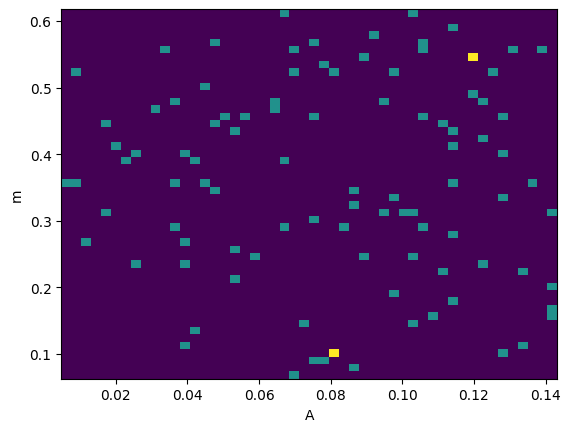

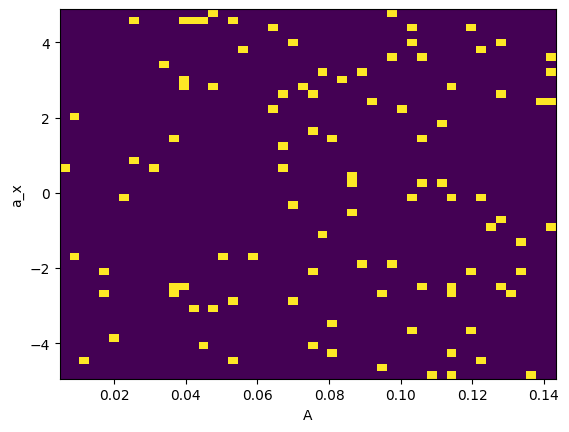

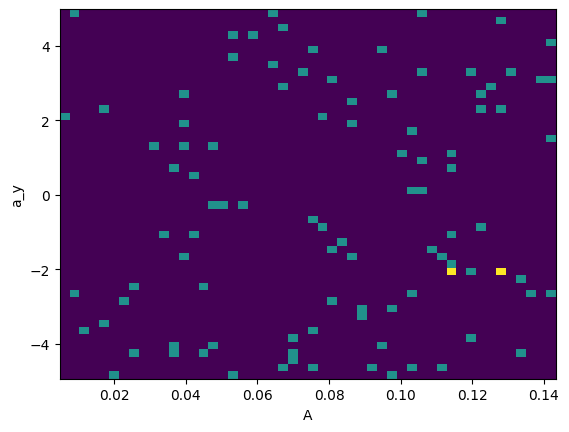

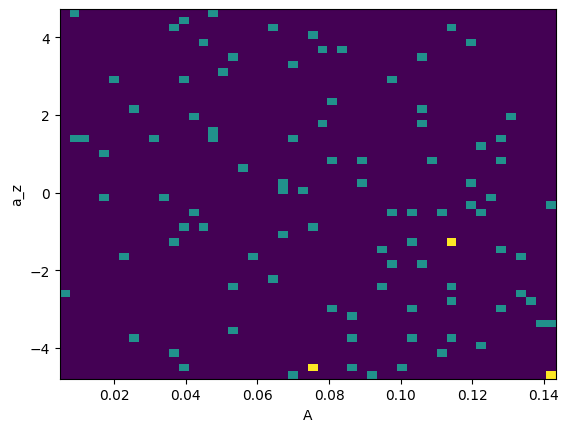

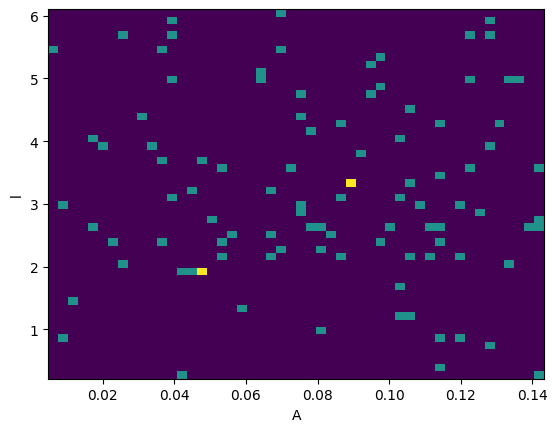

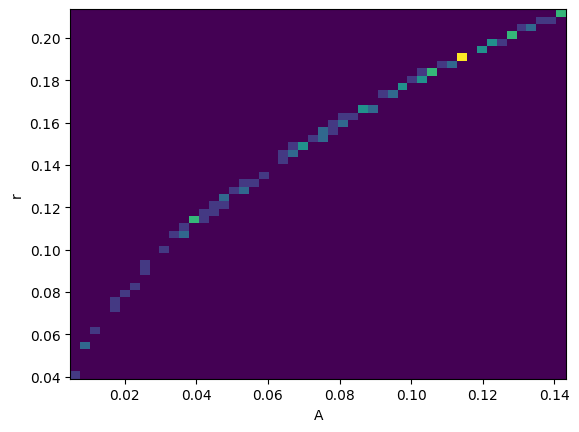

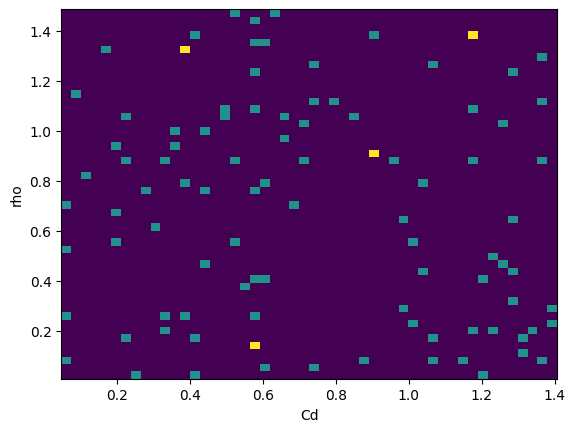

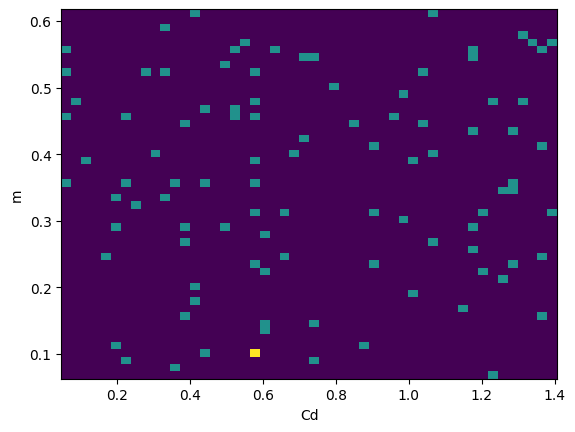

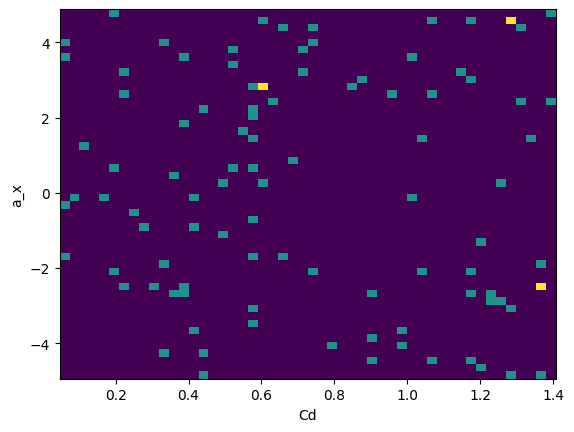

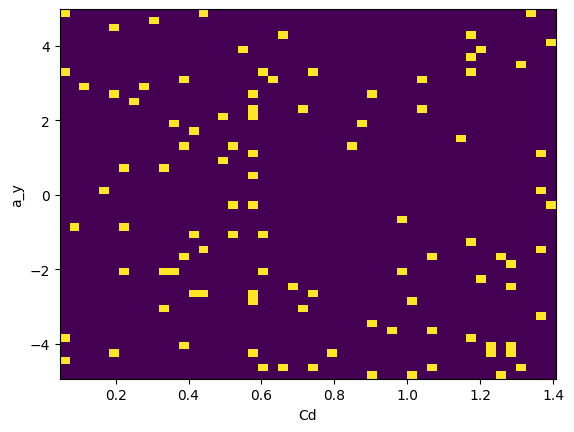

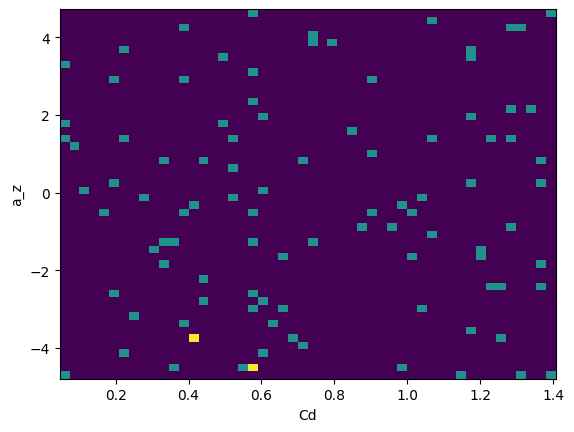

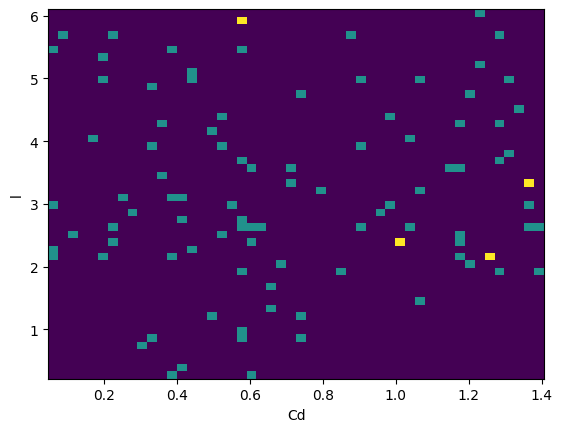

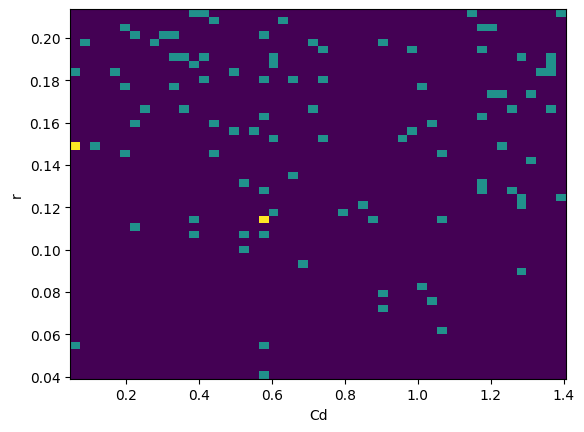

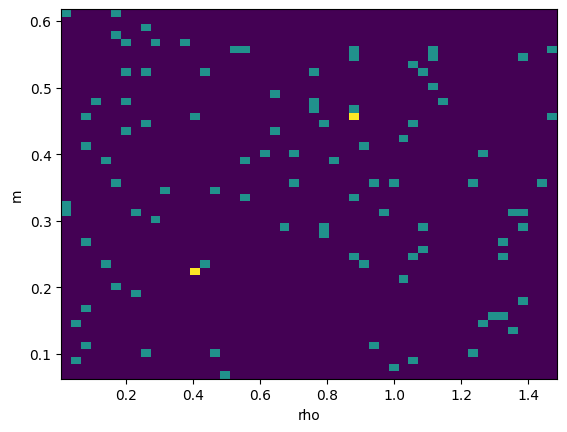

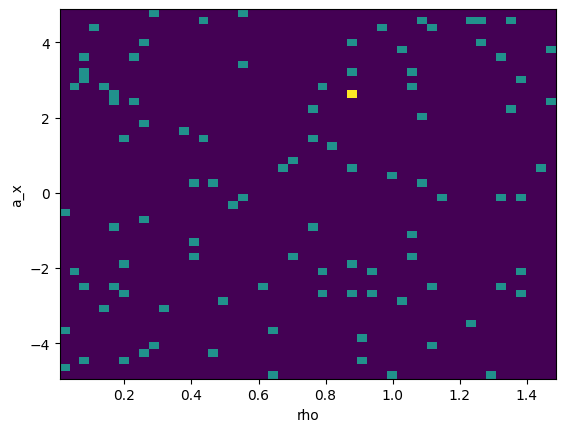

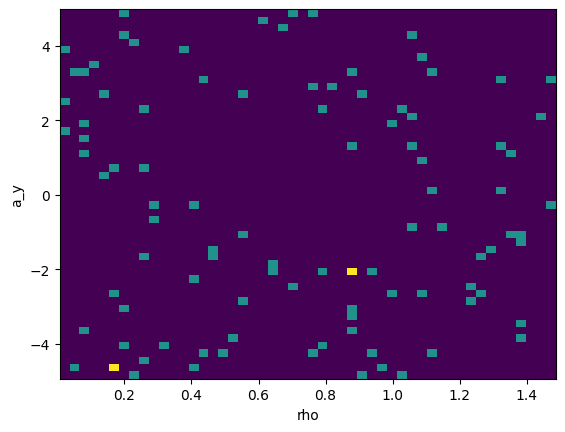

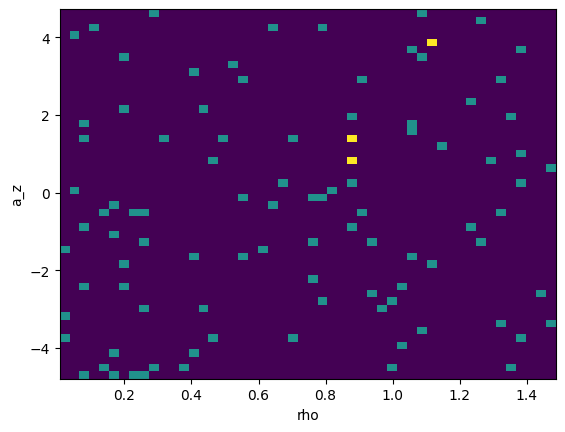

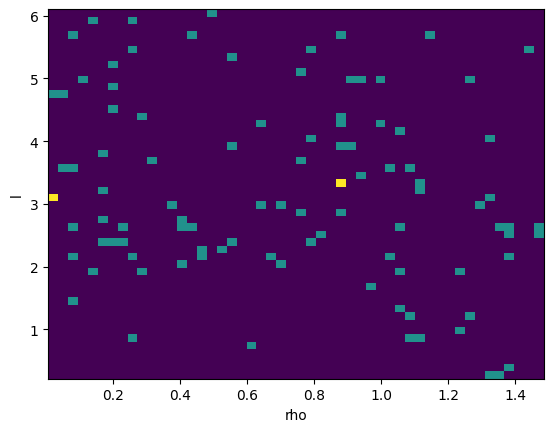

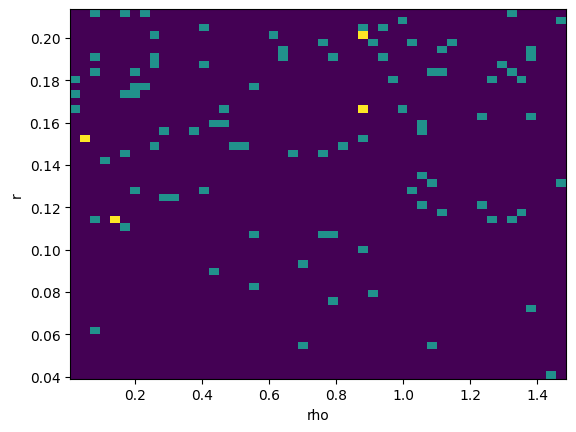

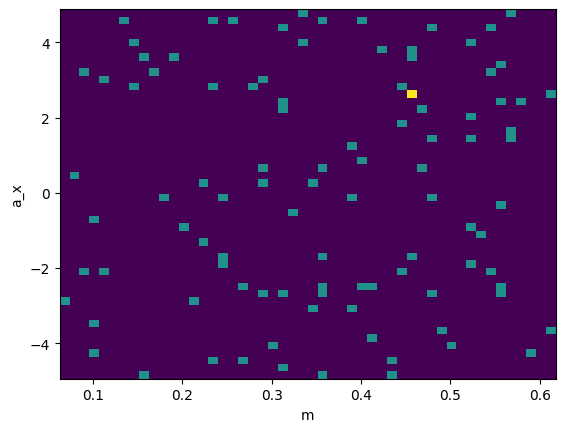

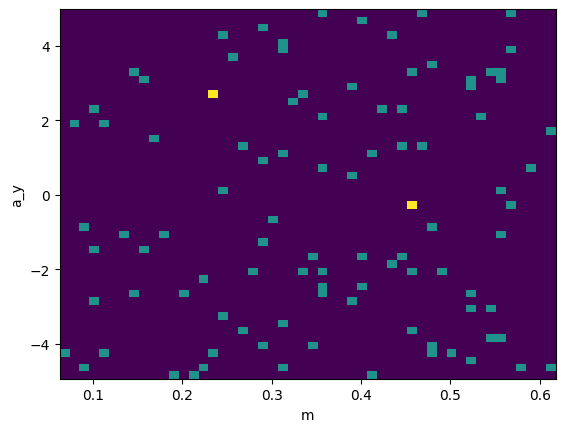

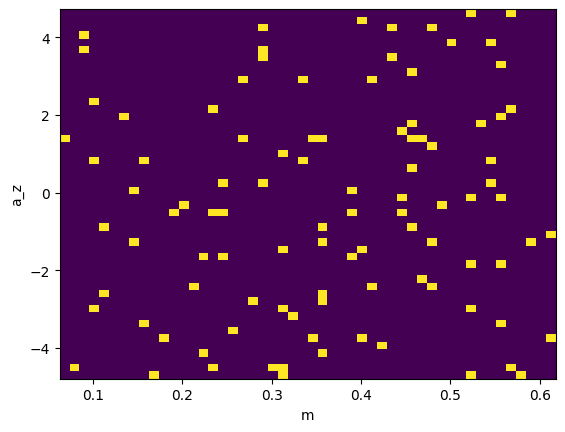

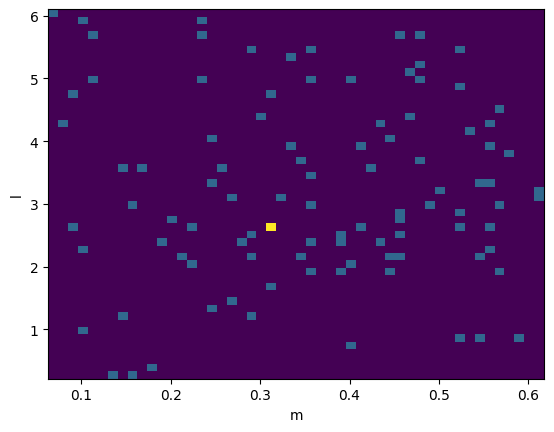

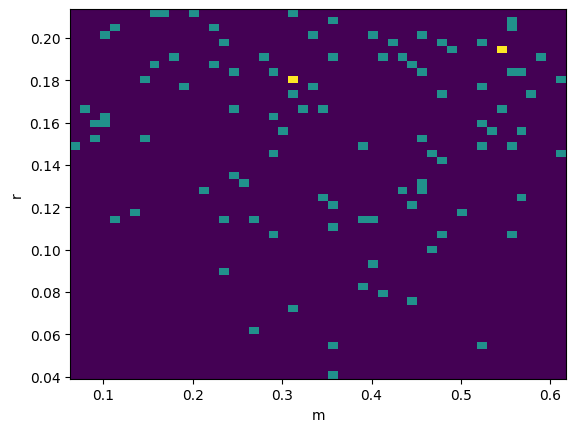

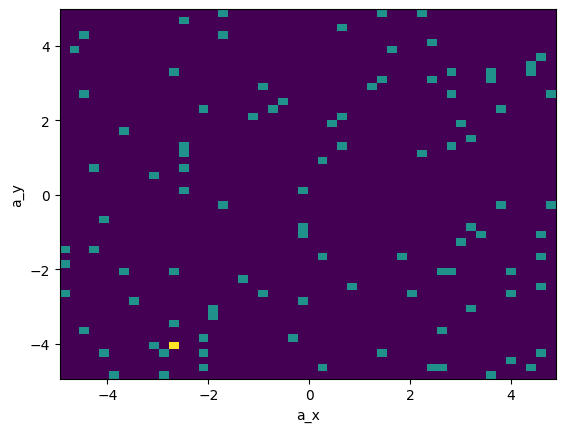

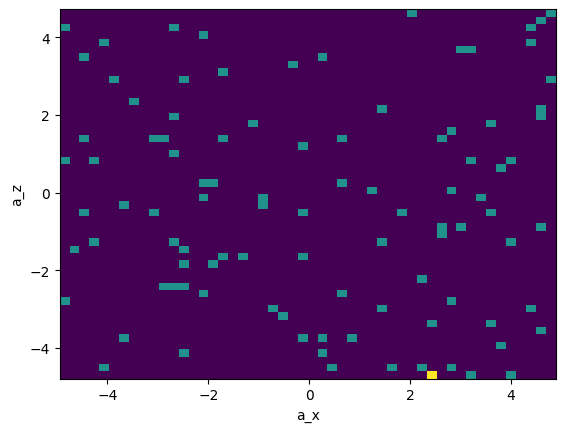

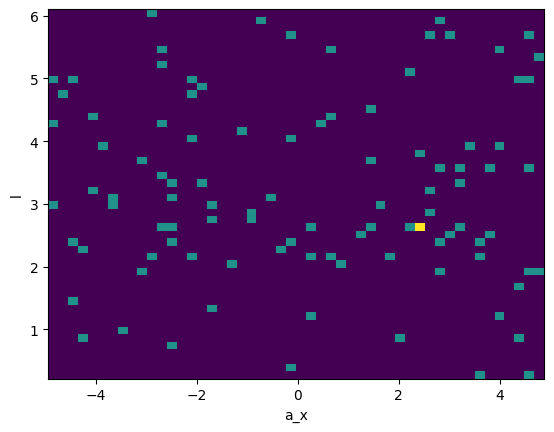

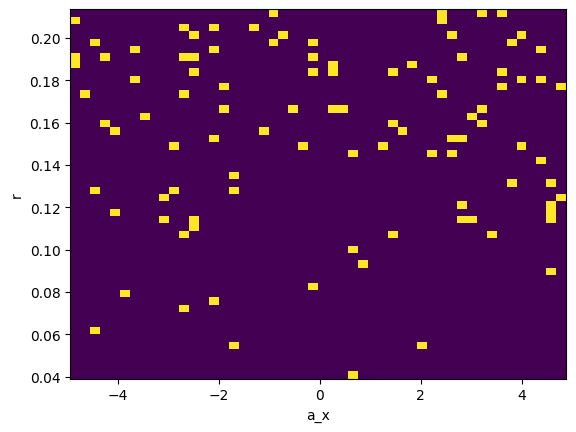

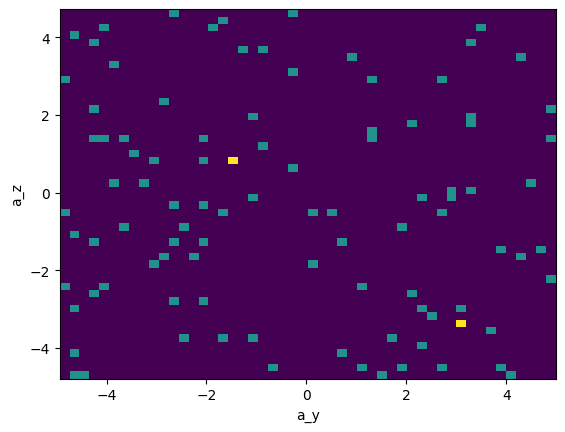

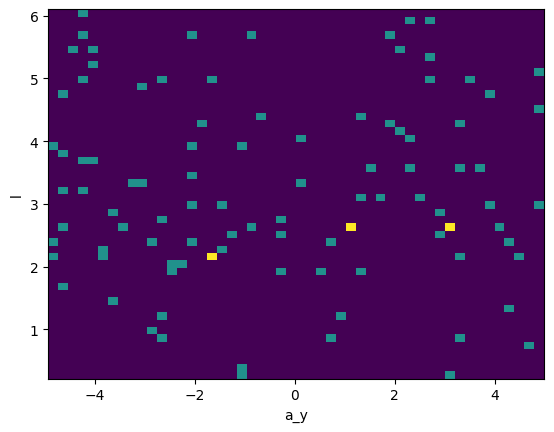

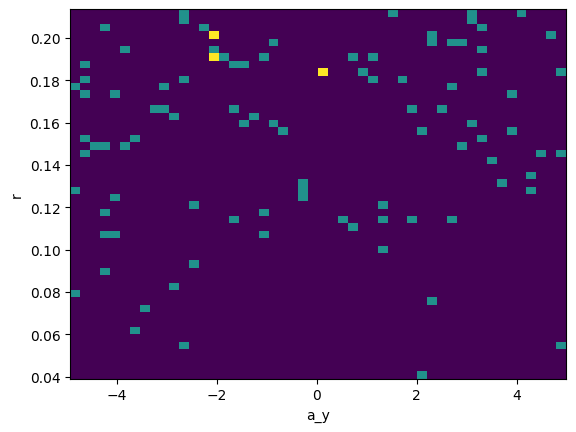

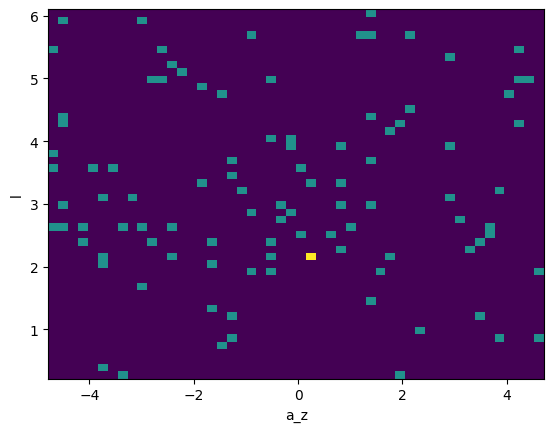

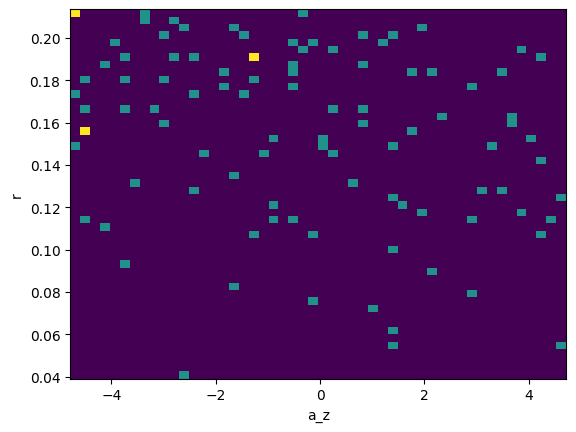

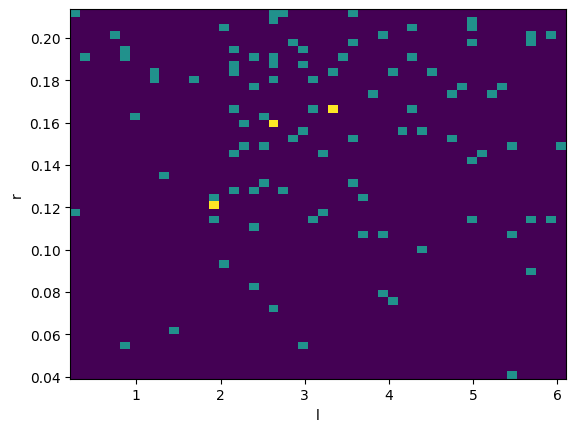

In [7]:
# plot 2d hist of all pairs
for i in range(df.shape[1]):
    for j in range(i + 1, df.shape[1]):
        plt.hist2d(df.iloc[:, i], df.iloc[:, j], bins=50)
        plt.xlabel(df.columns[i])
        plt.ylabel(df.columns[j])
        plt.show()

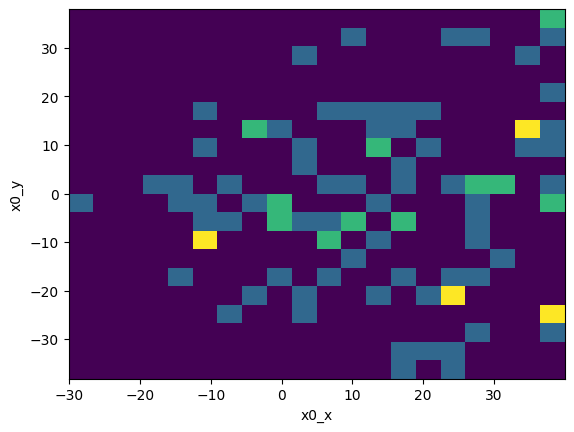

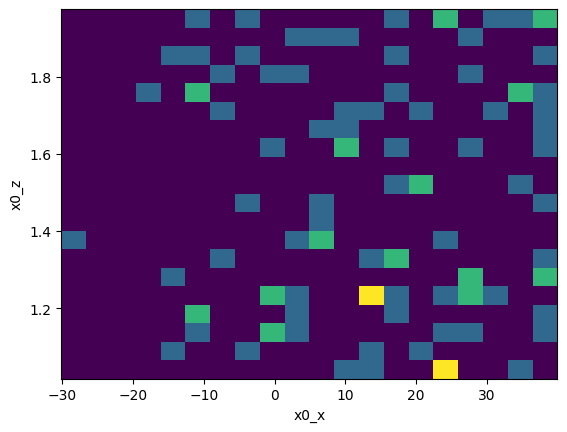

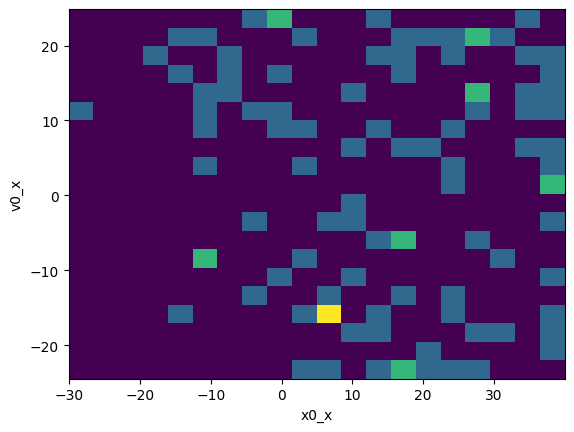

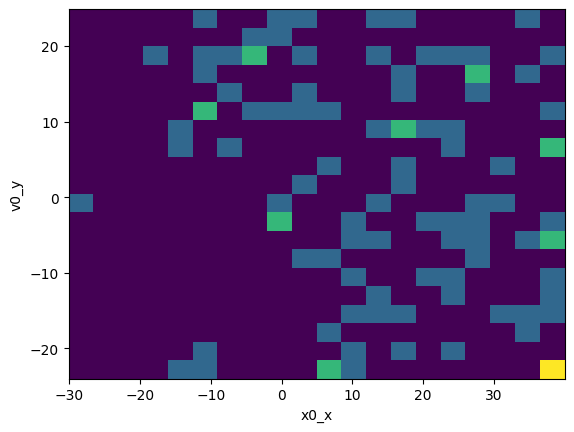

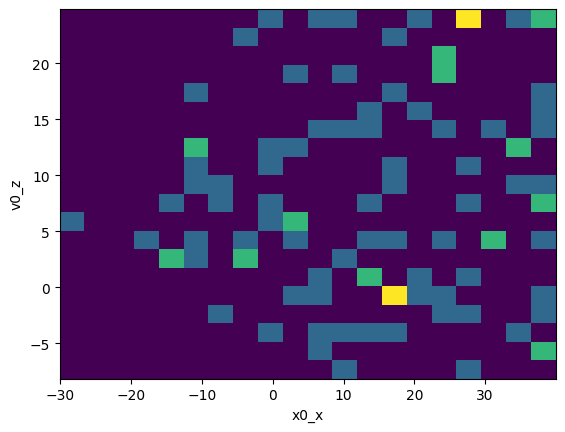

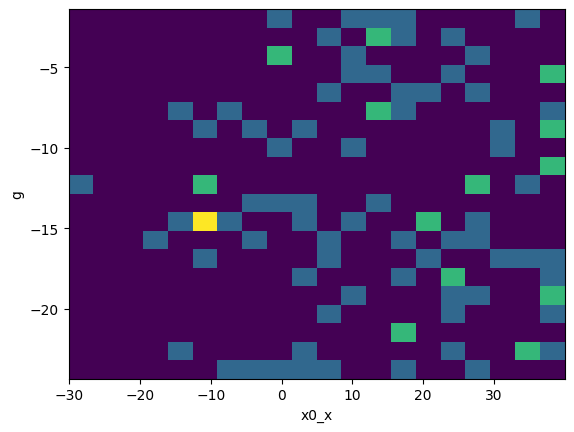

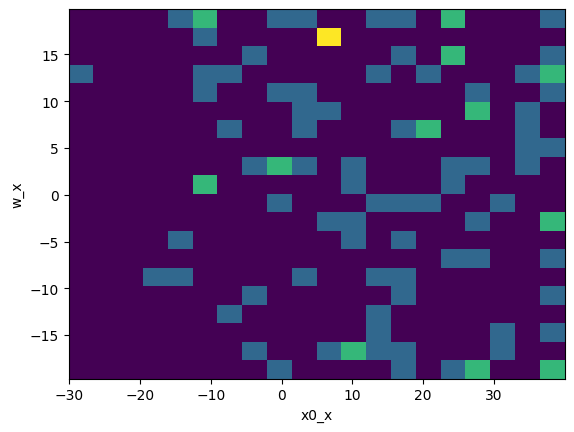

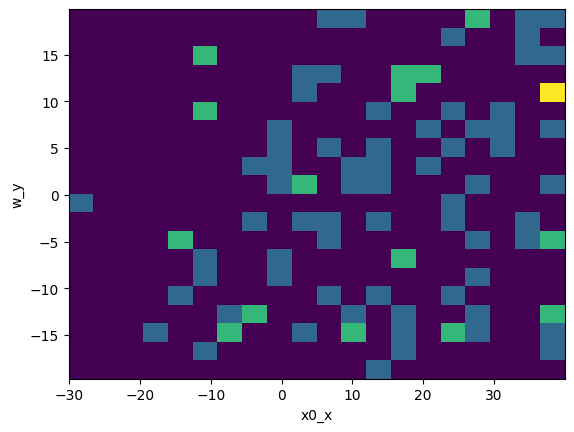

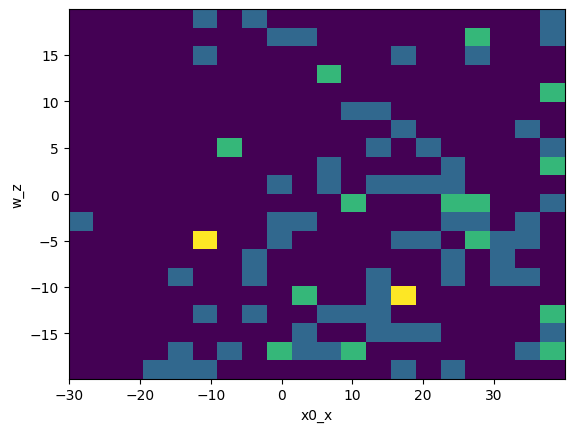

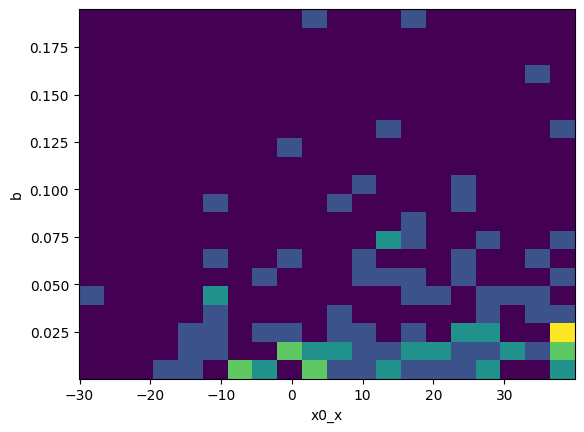

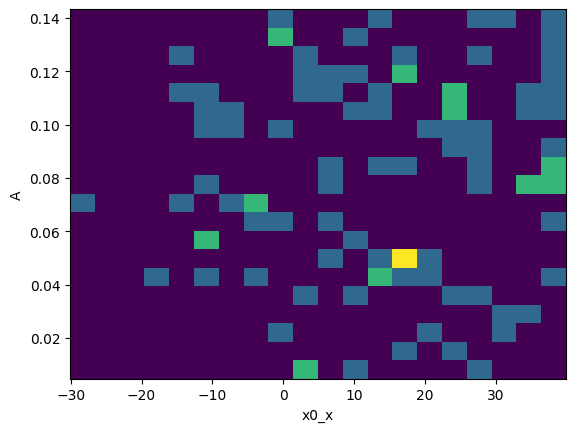

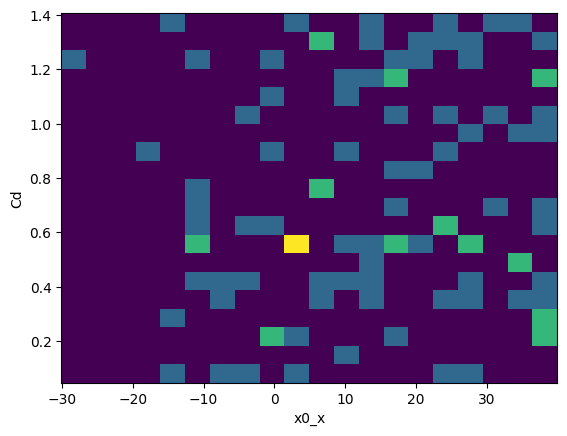

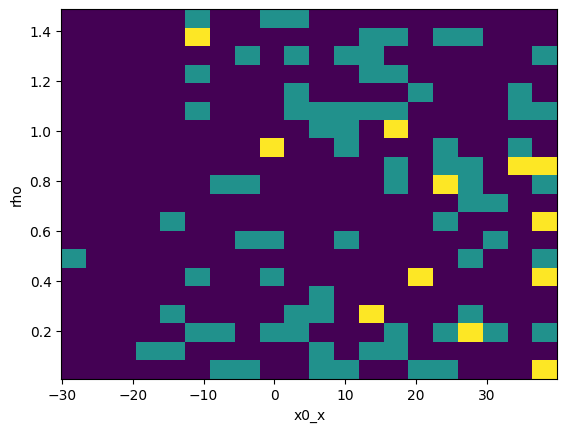

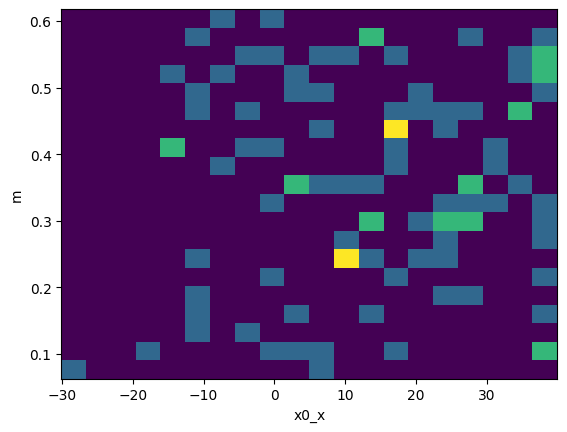

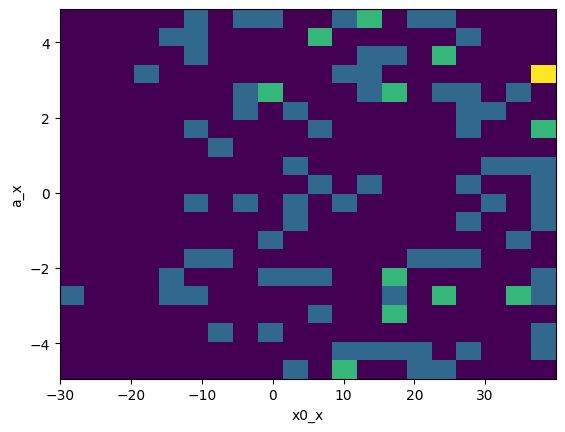

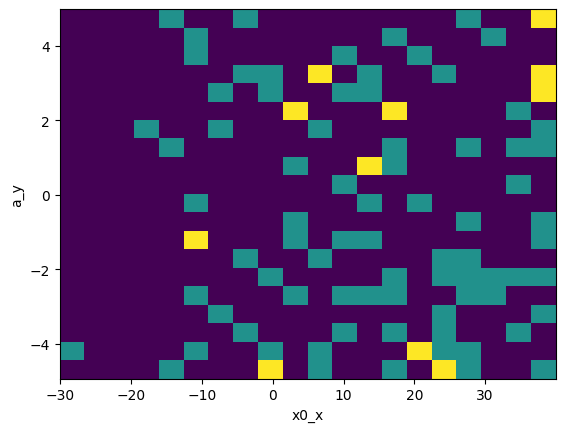

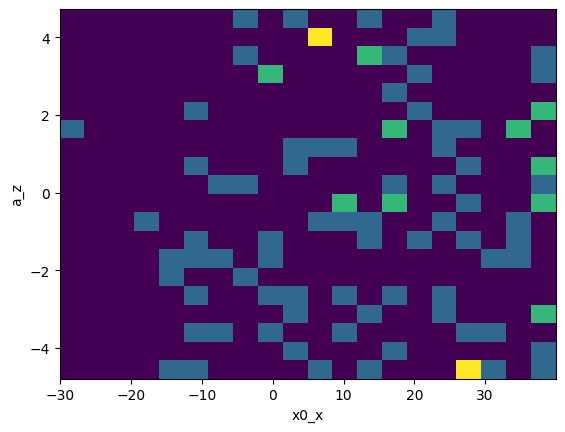

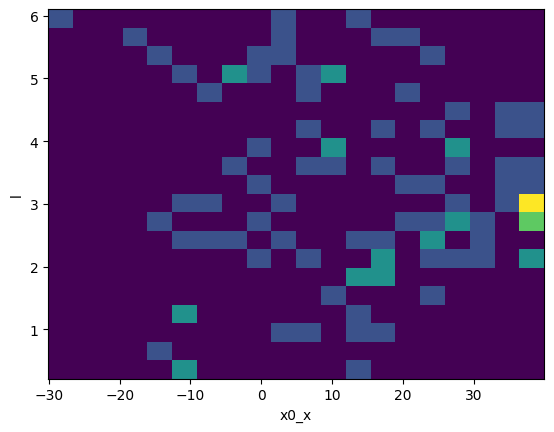

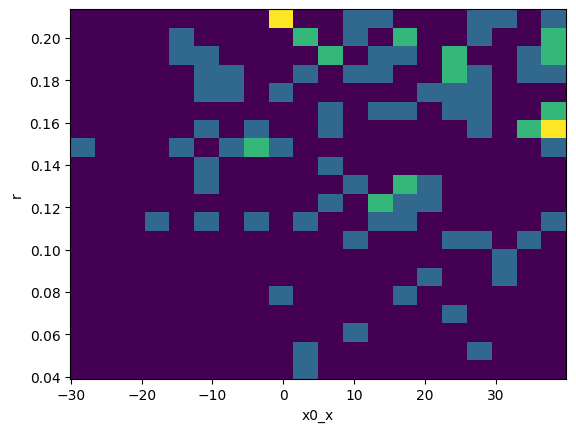

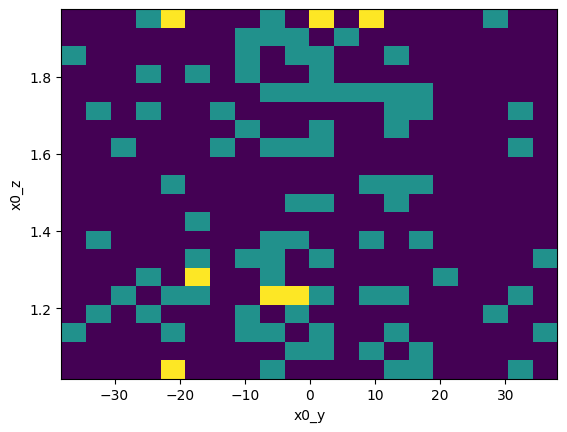

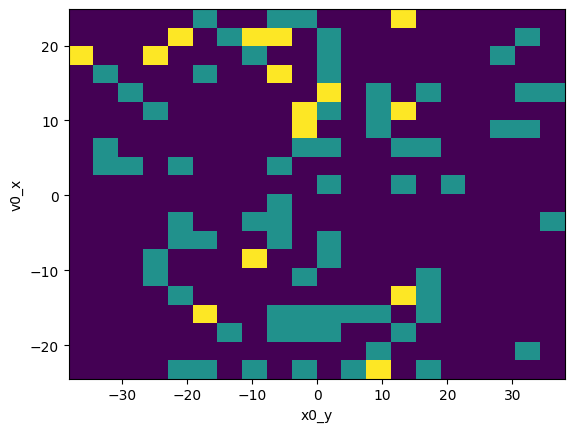

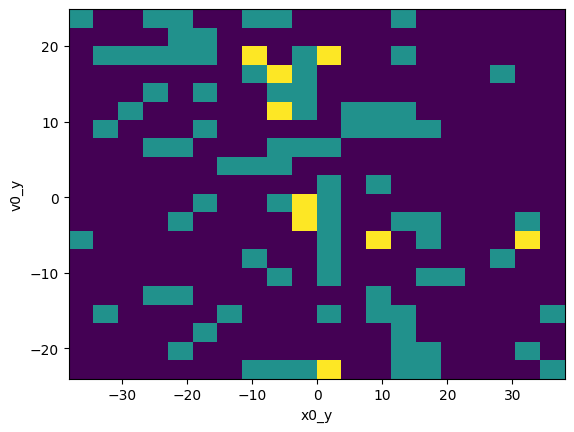

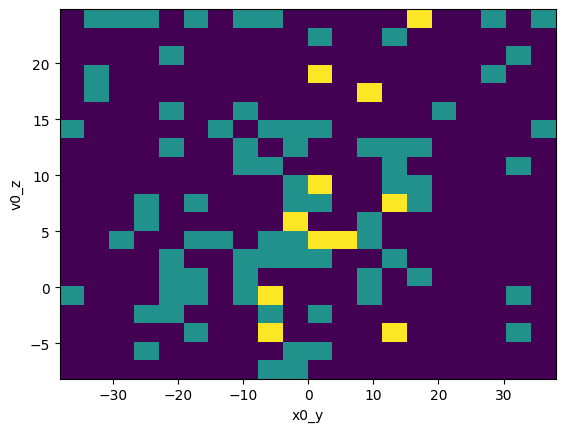

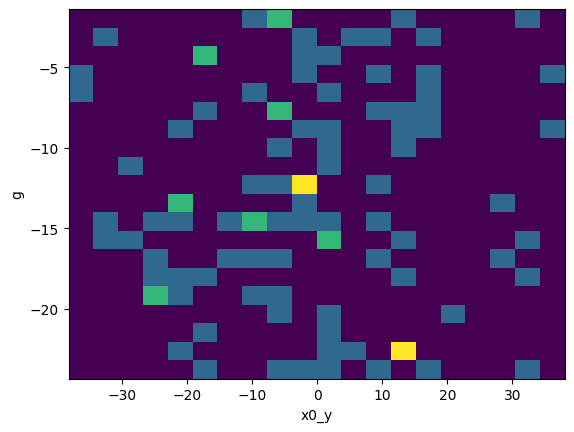

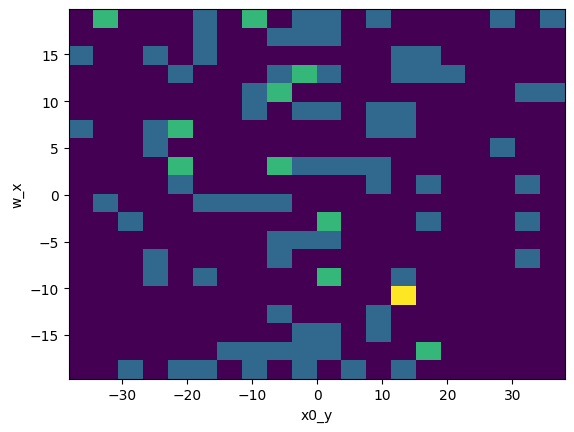

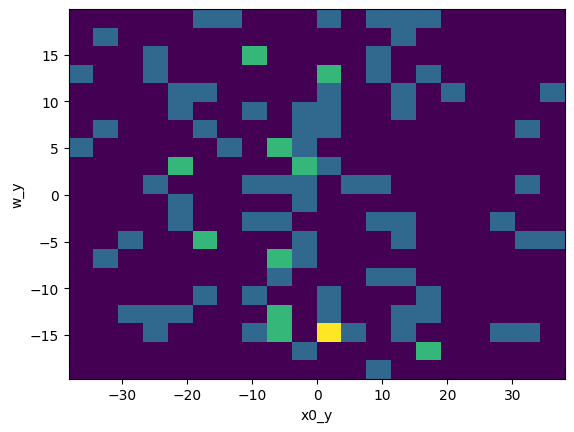

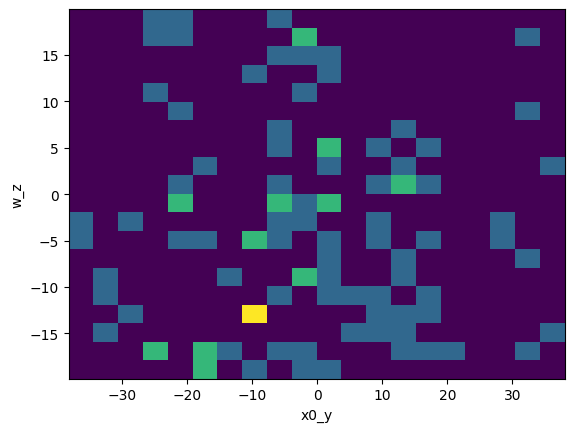

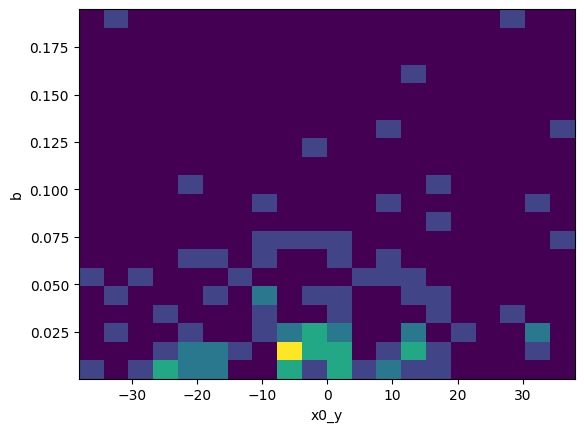

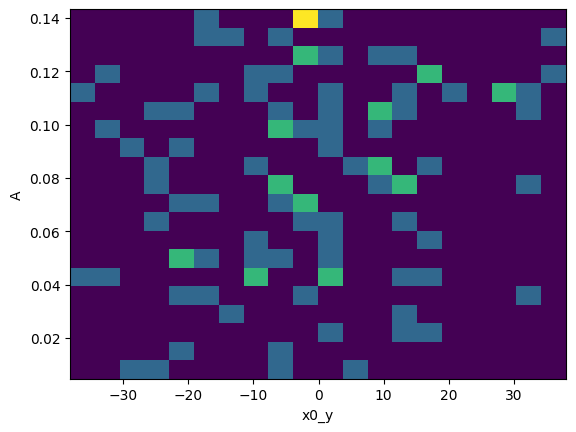

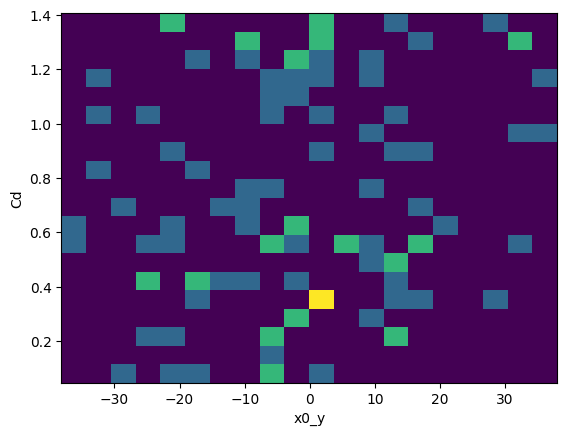

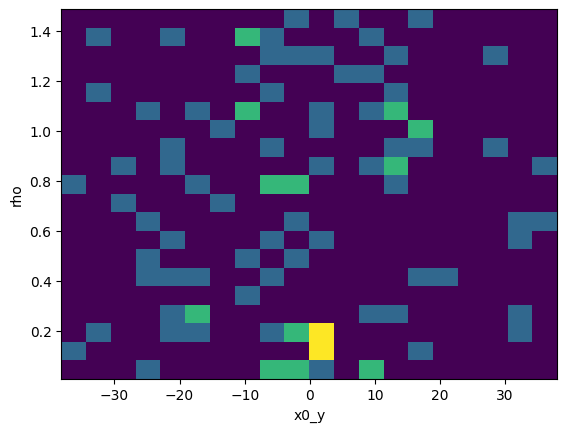

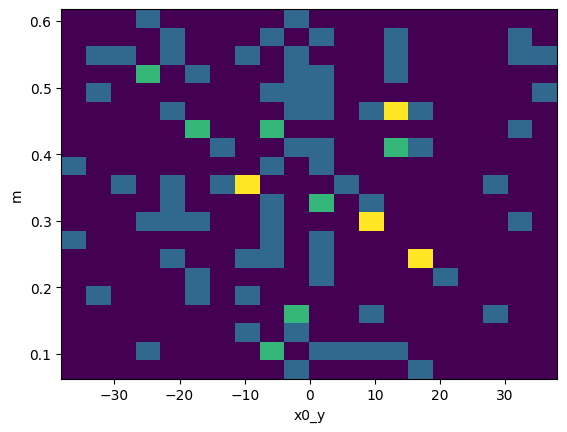

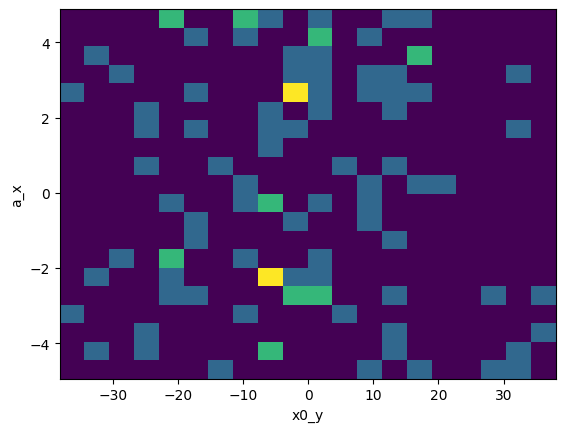

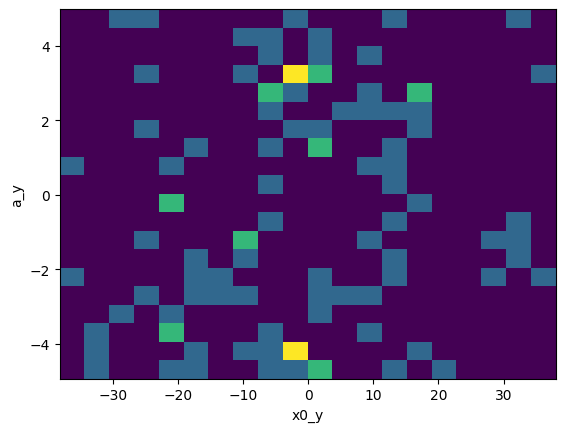

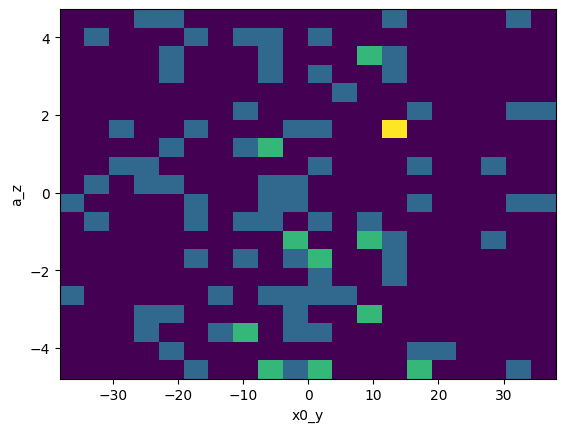

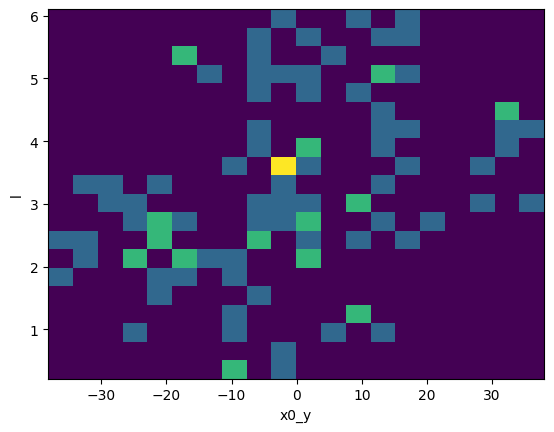

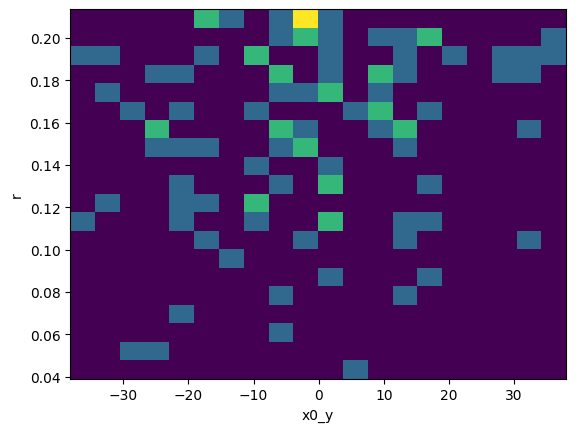

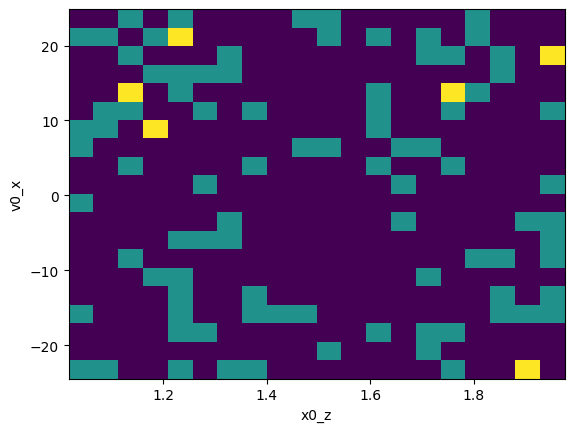

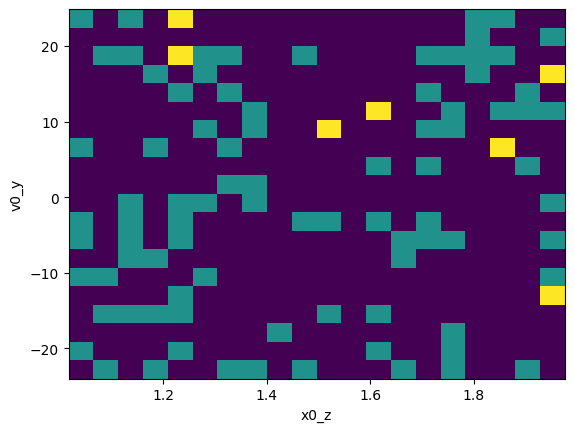

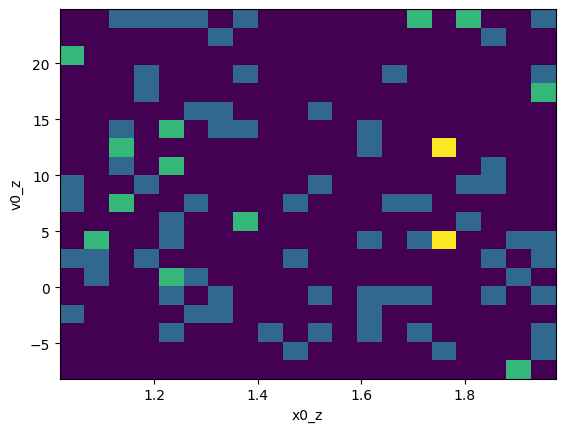

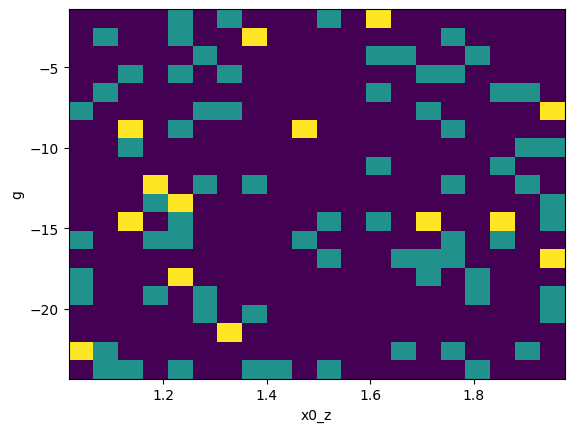

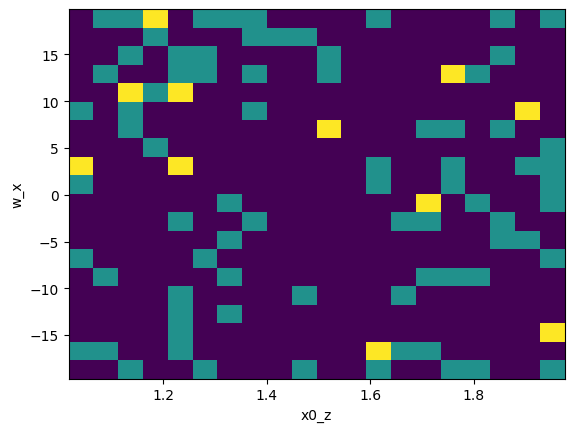

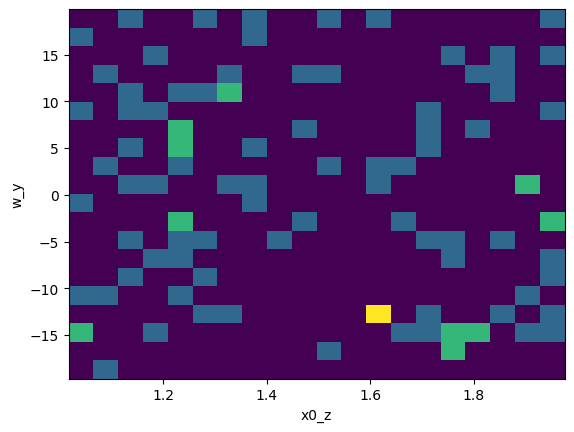

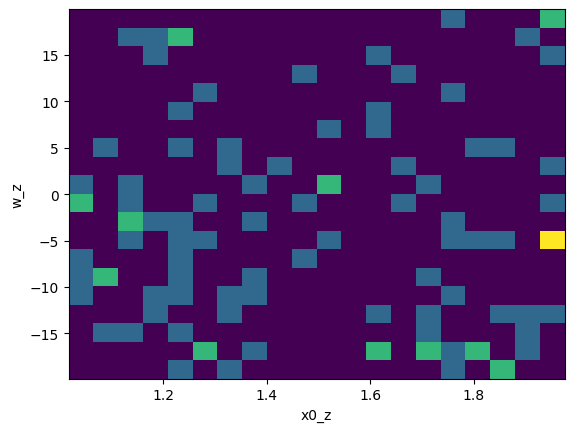

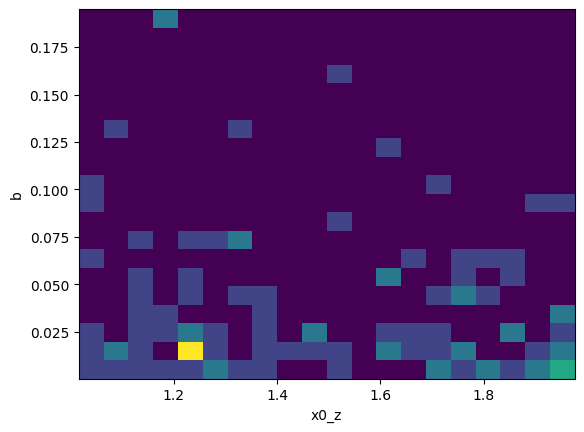

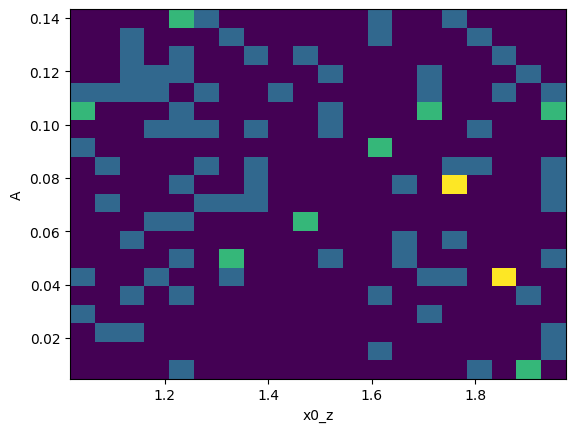

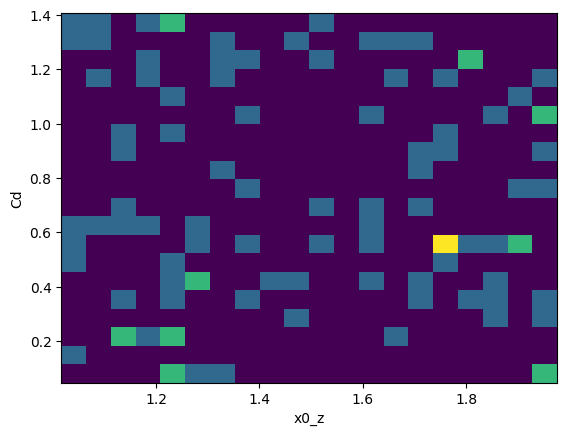

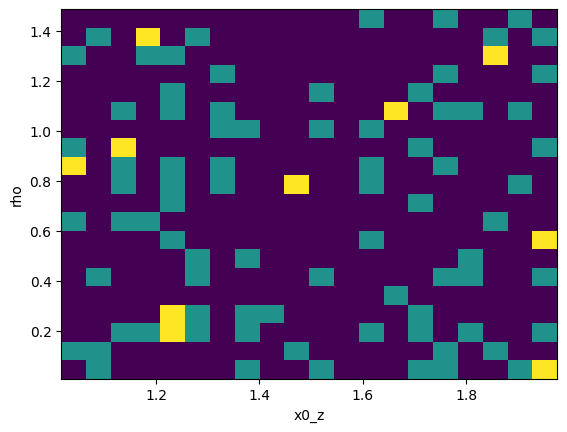

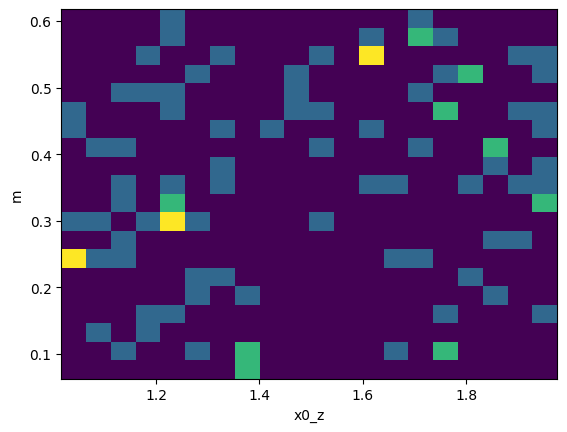

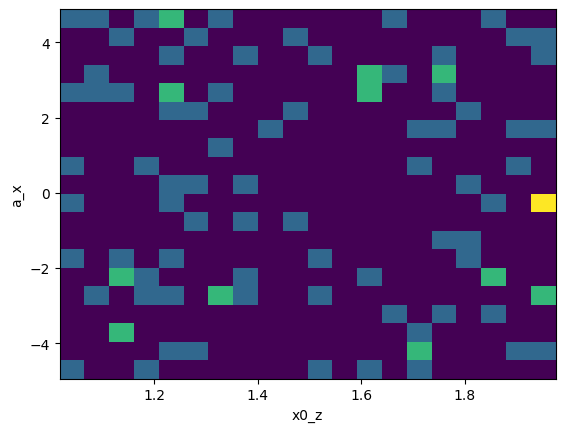

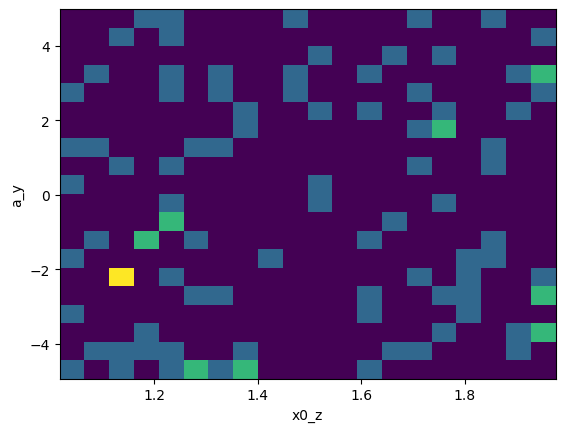

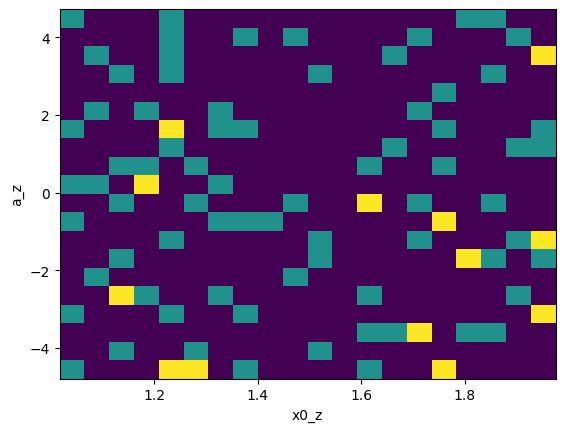

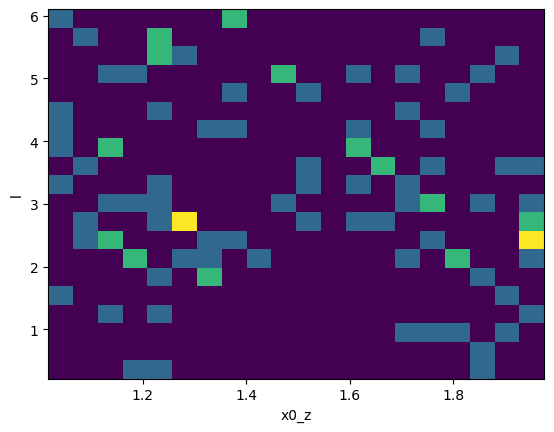

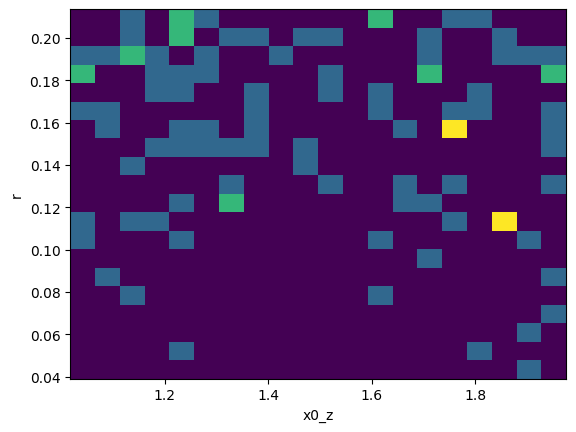

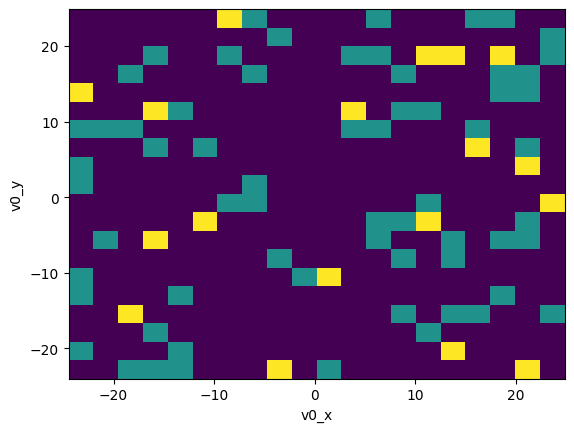

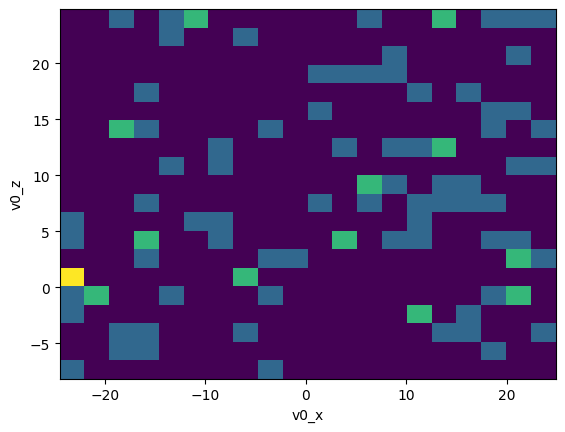

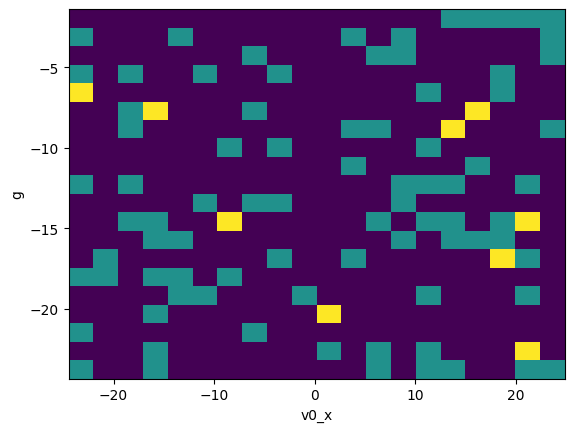

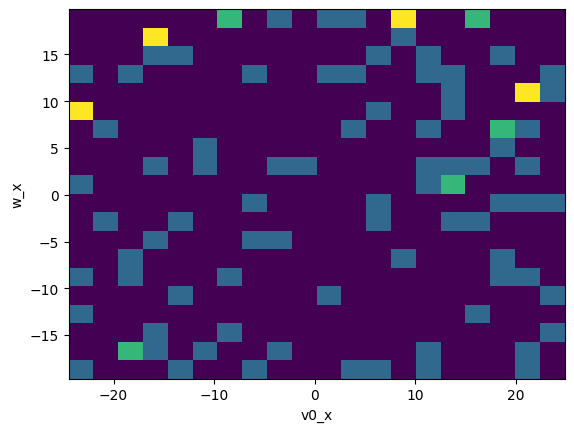

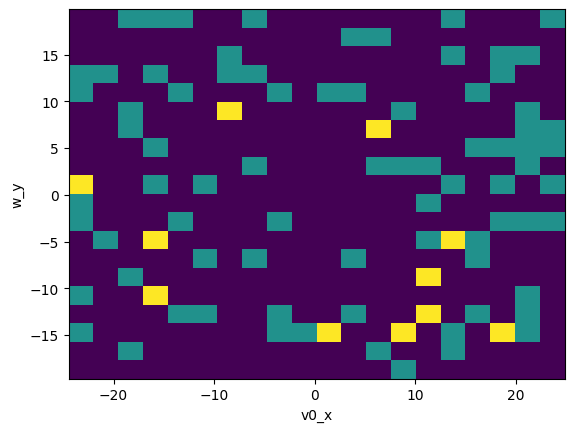

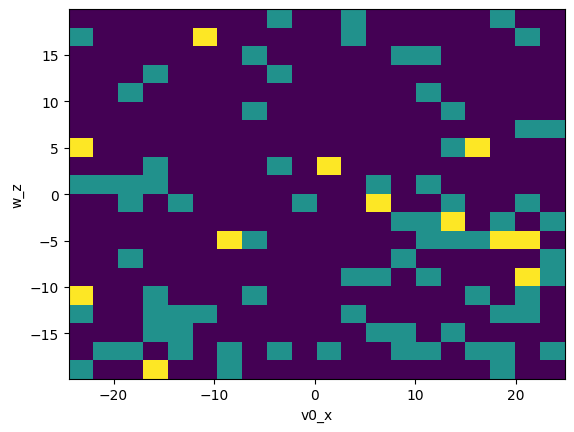

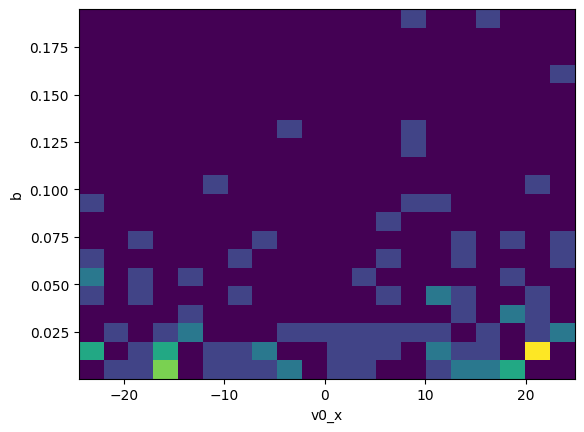

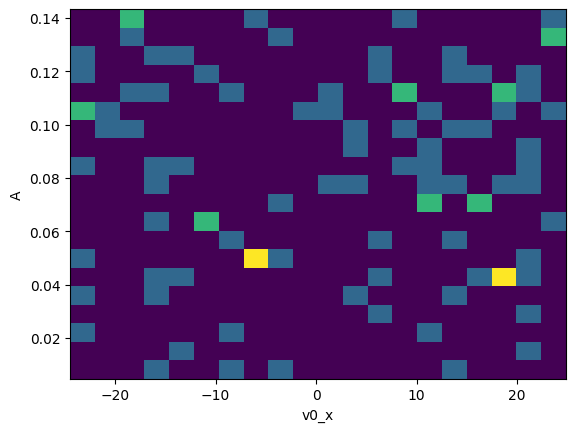

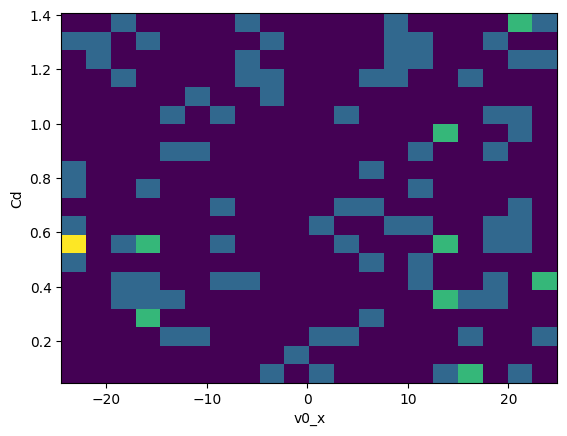

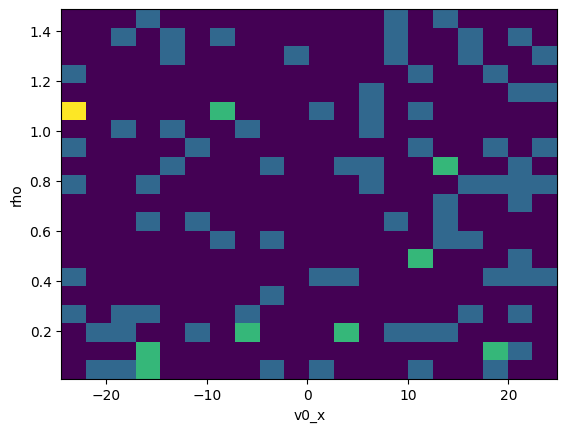

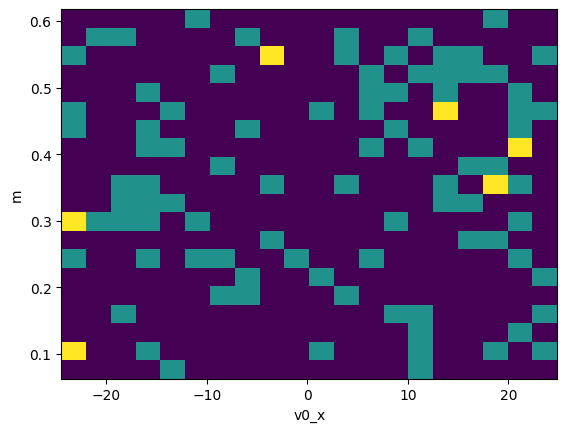

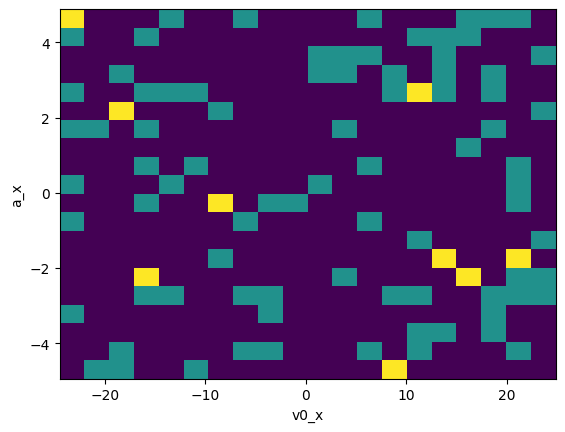

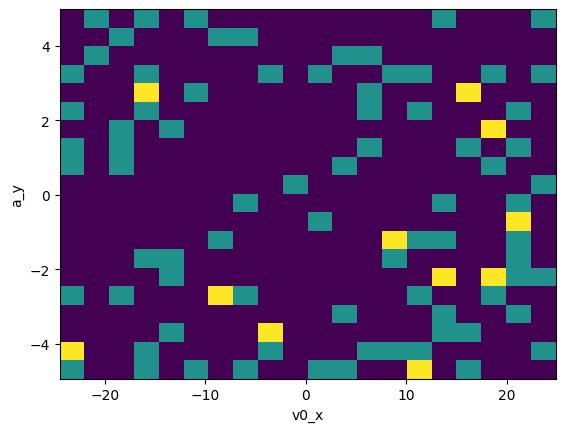

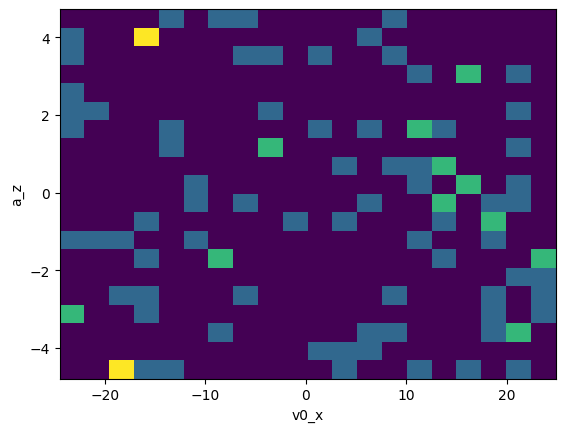

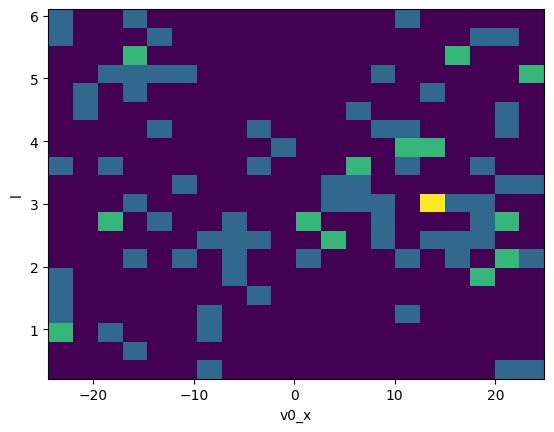

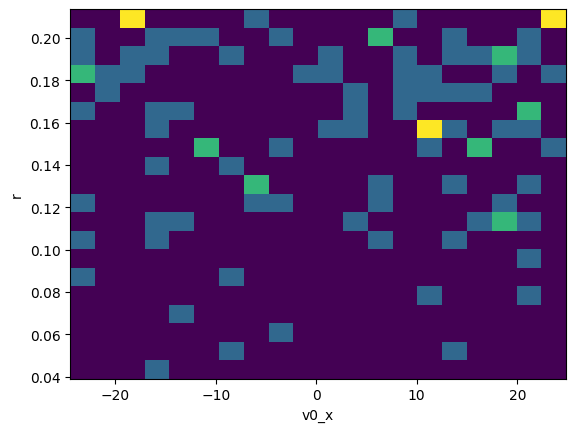

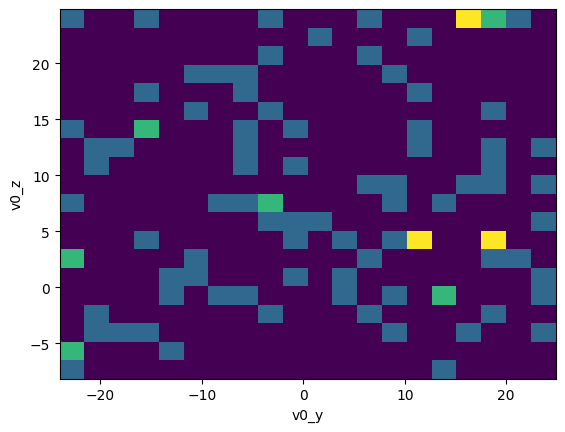

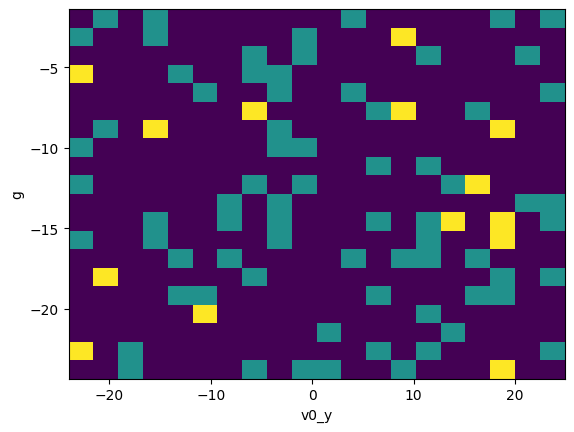

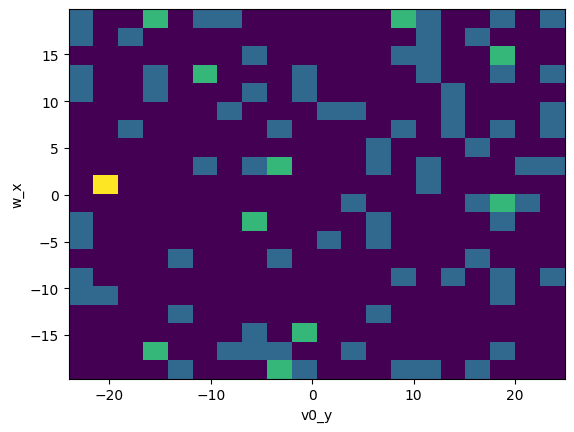

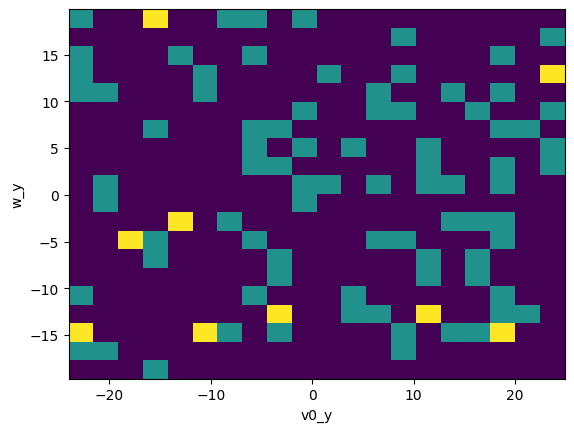

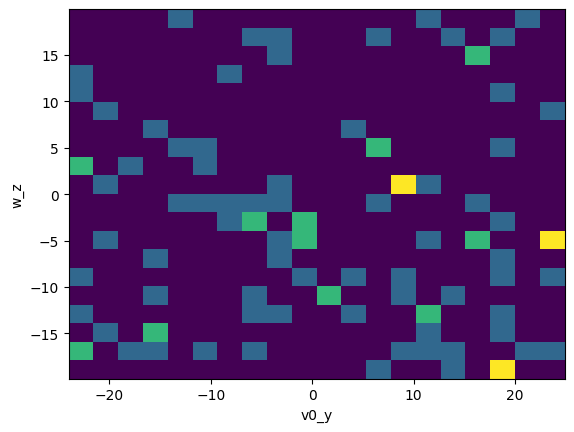

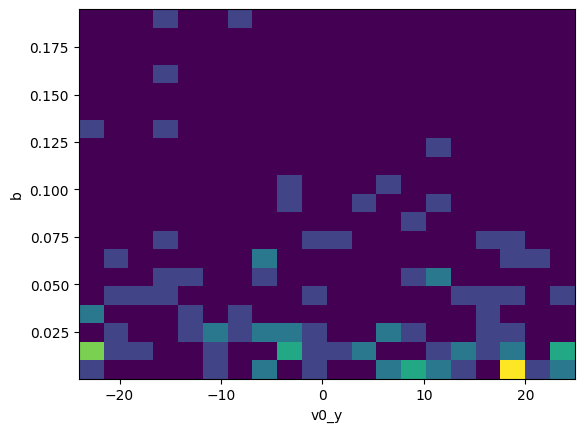

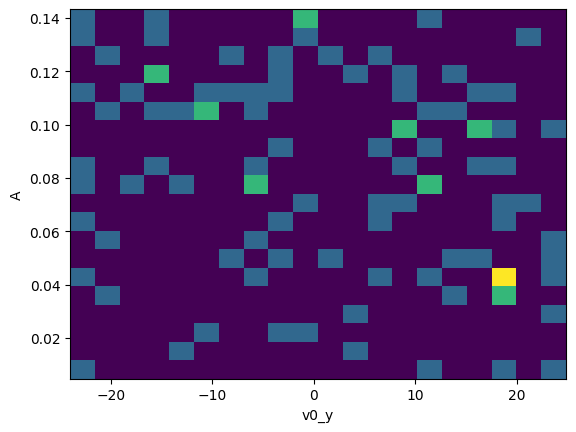

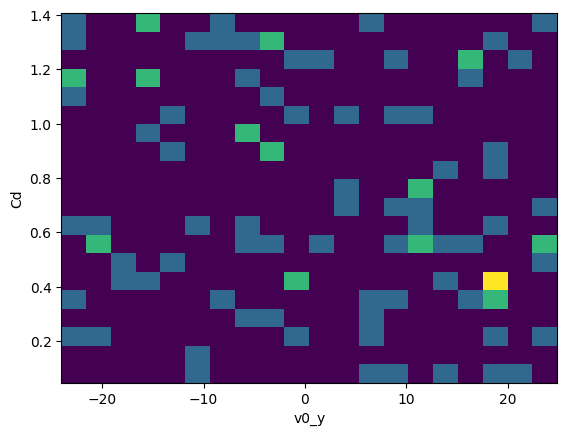

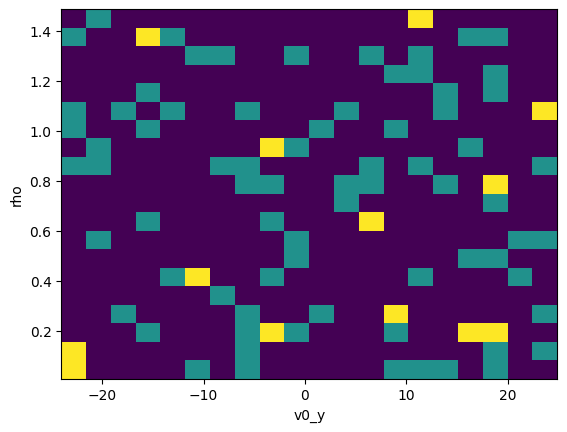

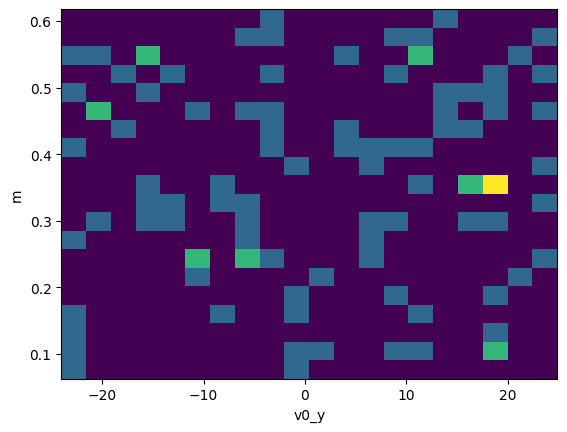

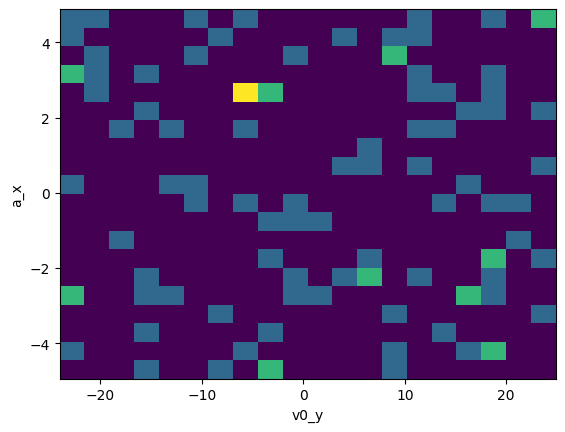

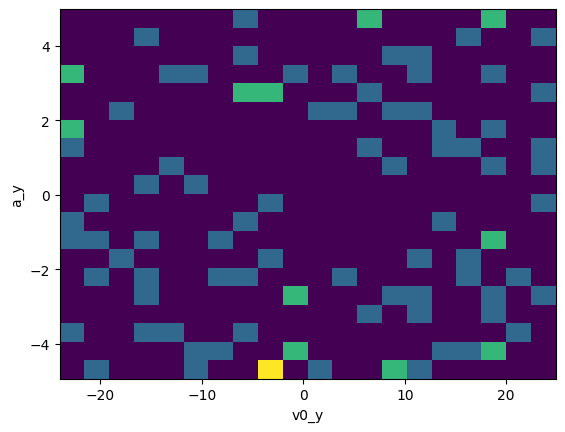

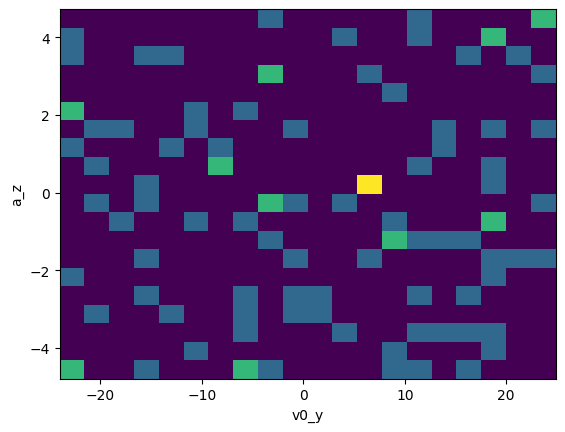

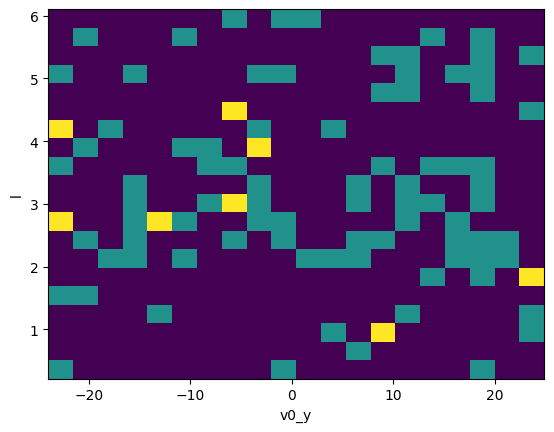

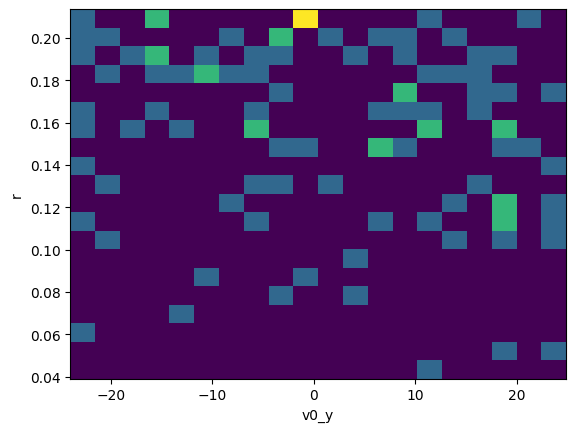

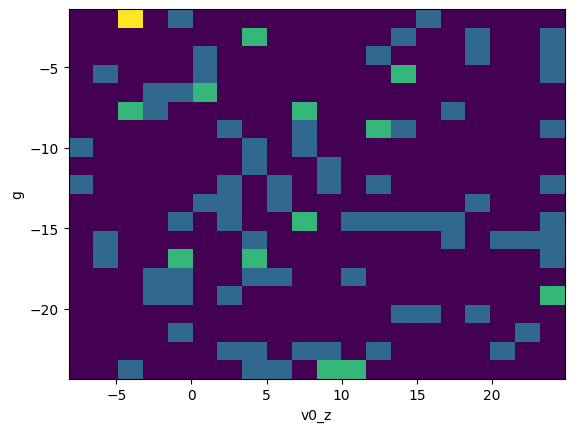

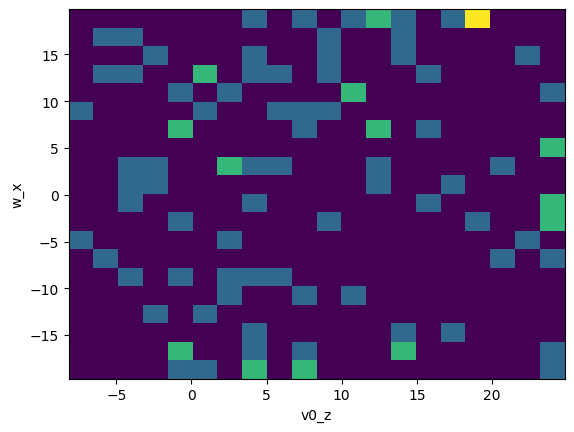

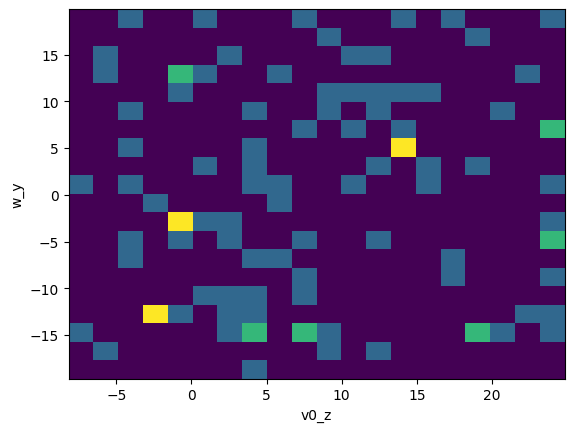

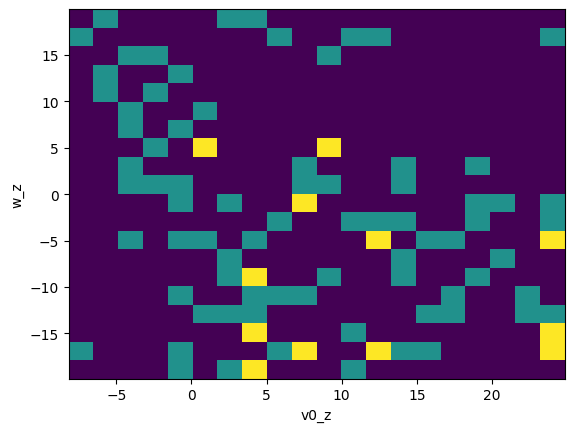

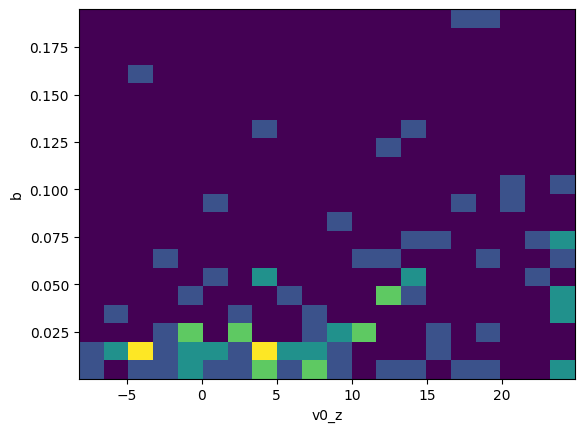

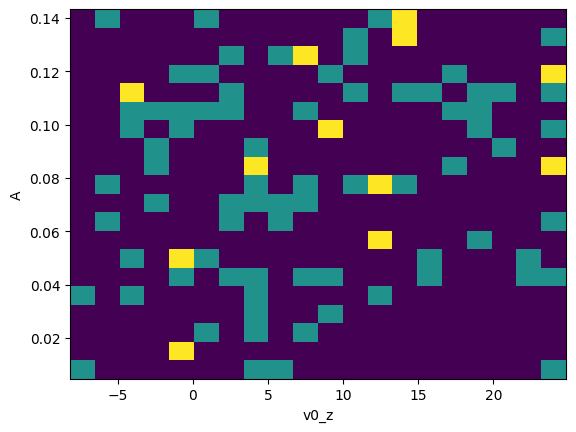

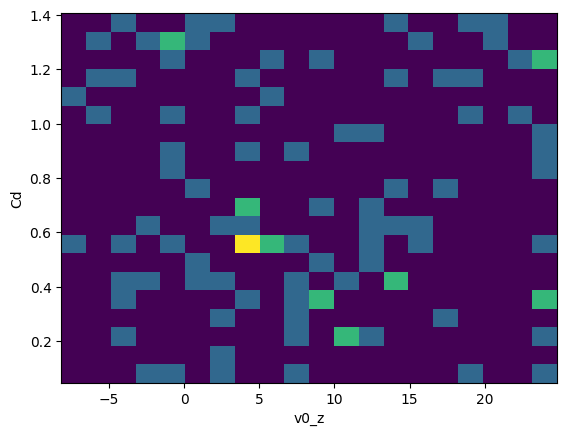

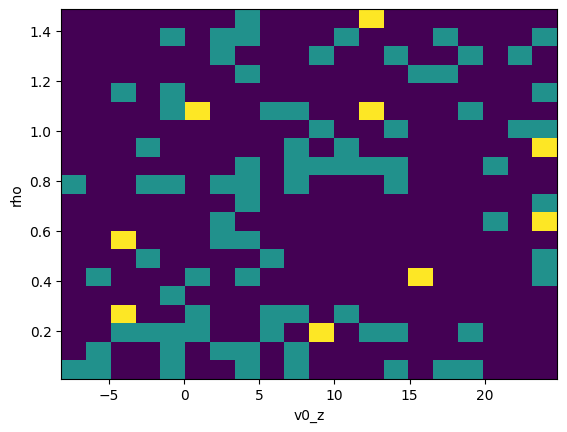

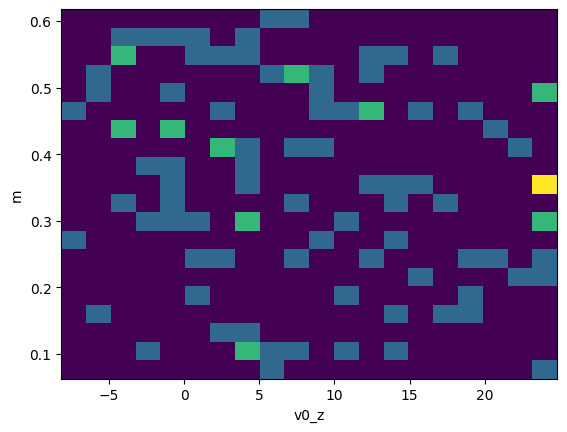

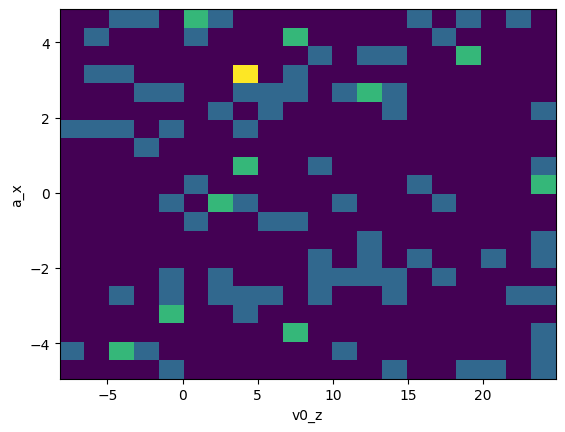

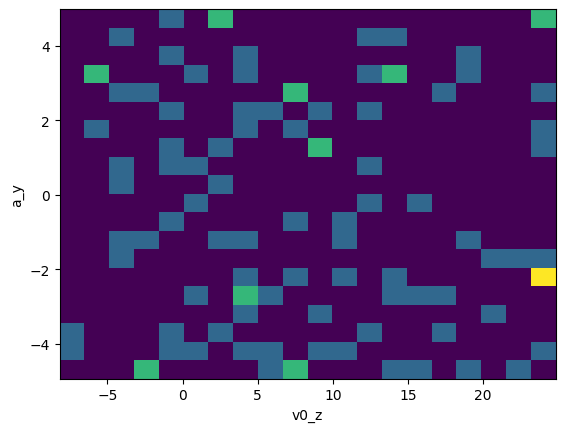

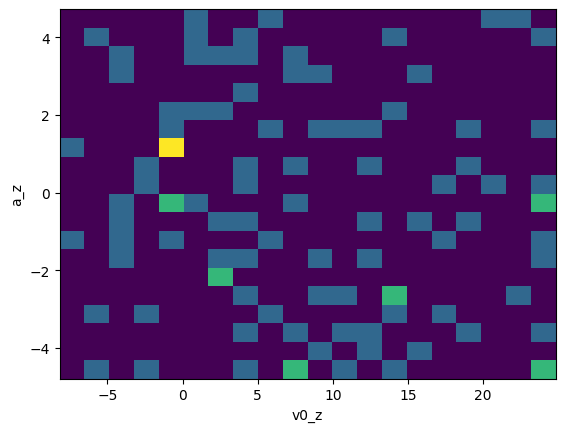

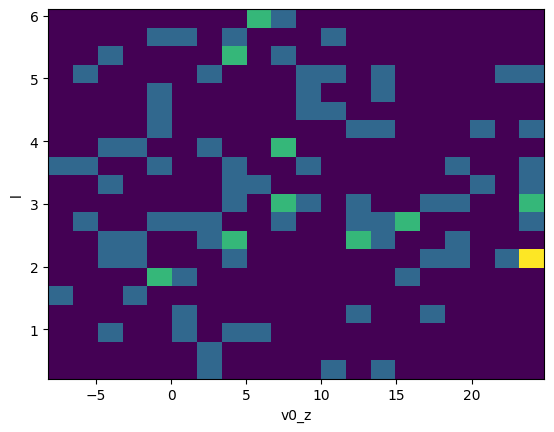

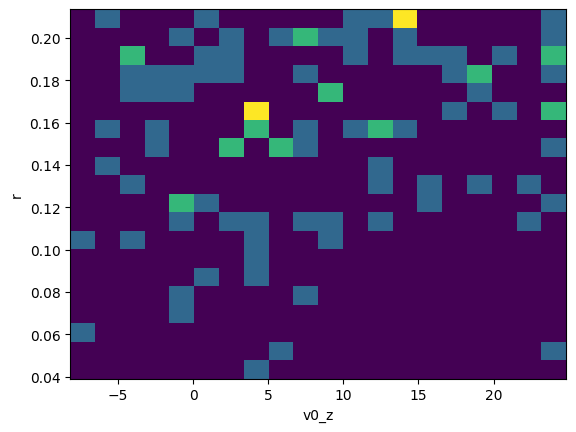

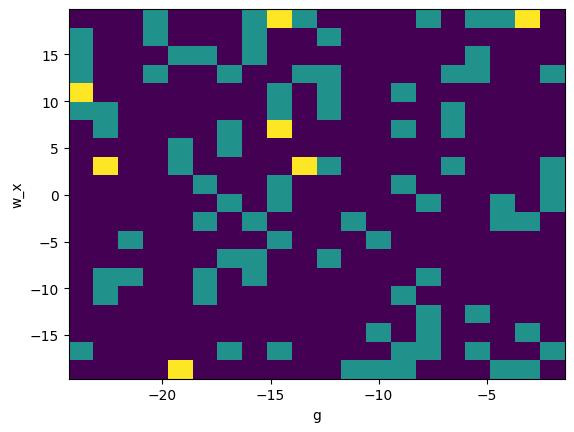

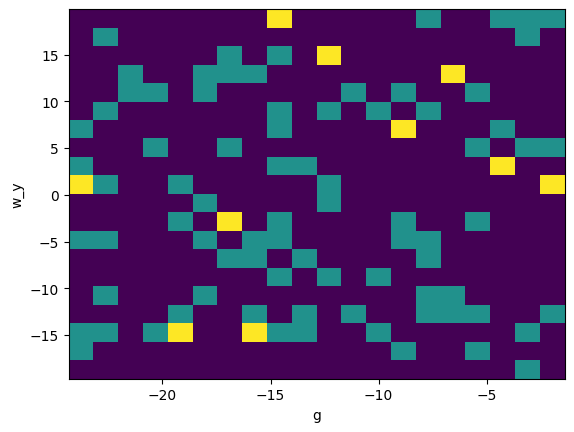

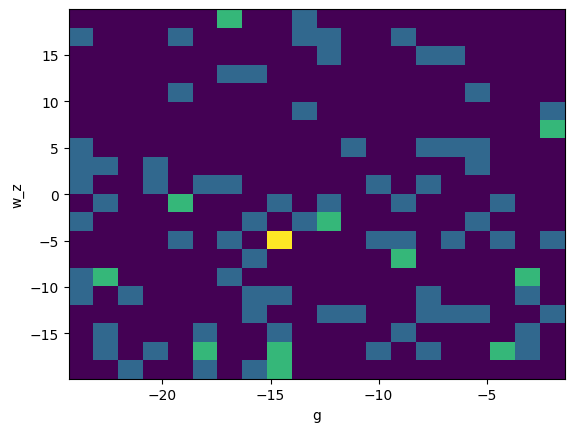

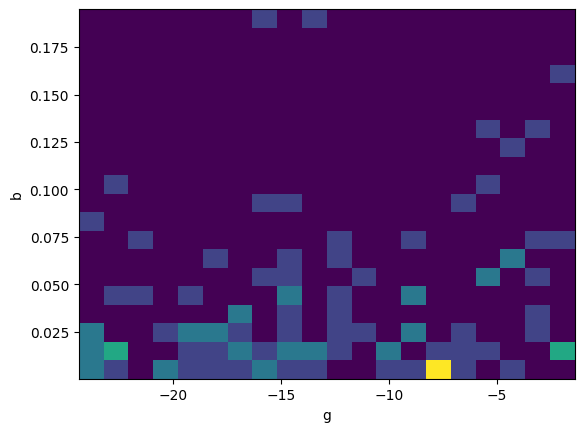

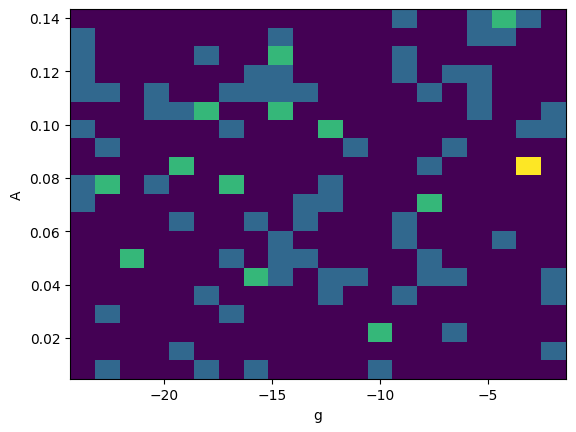

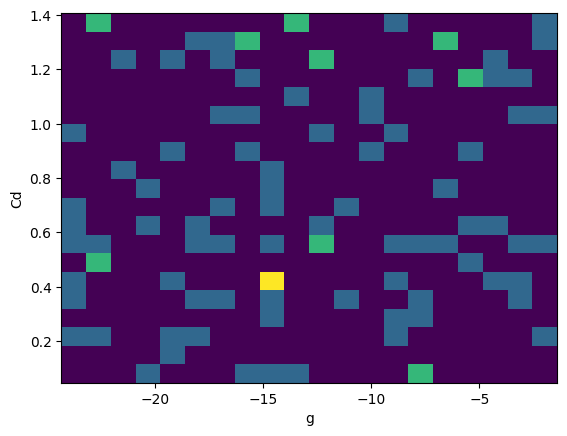

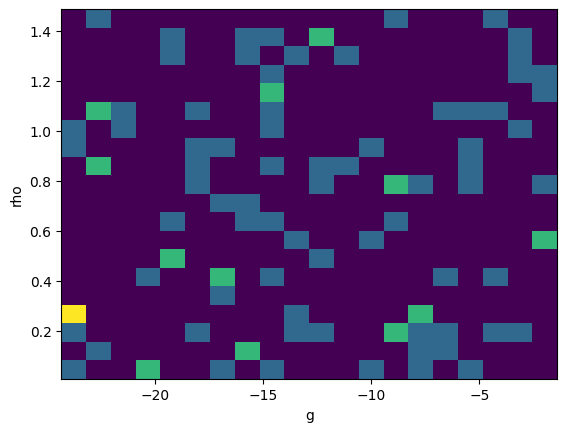

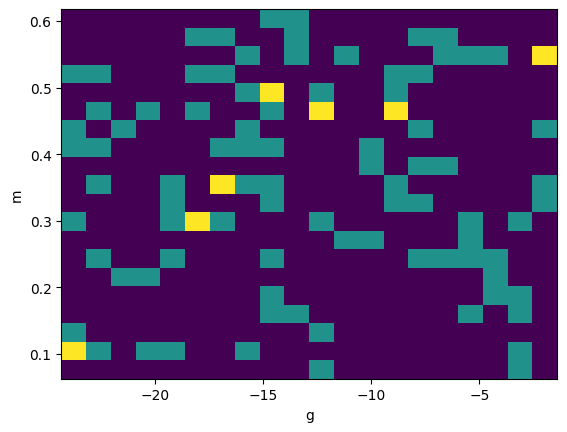

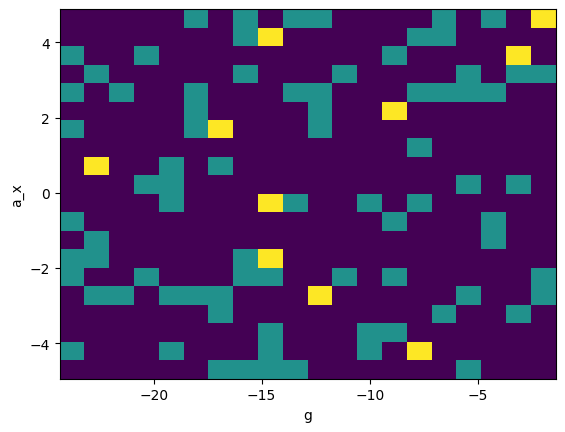

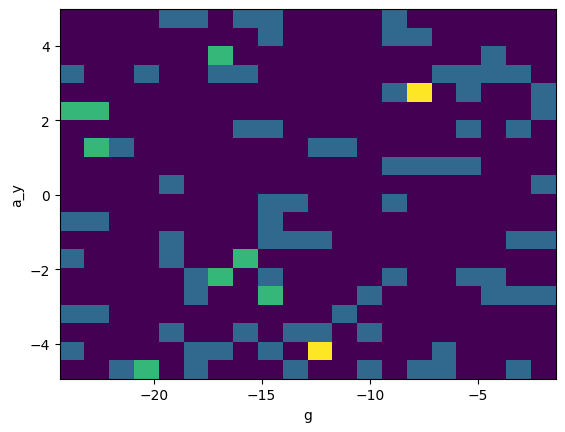

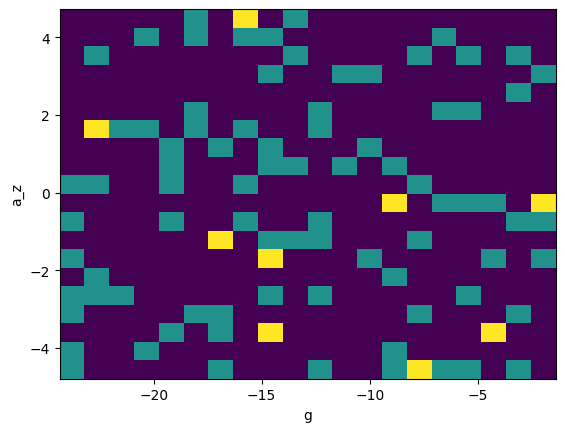

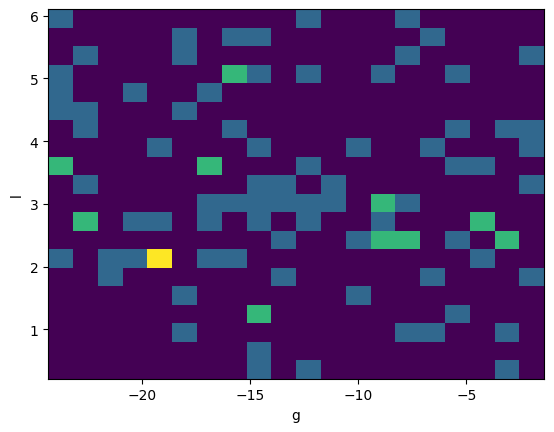

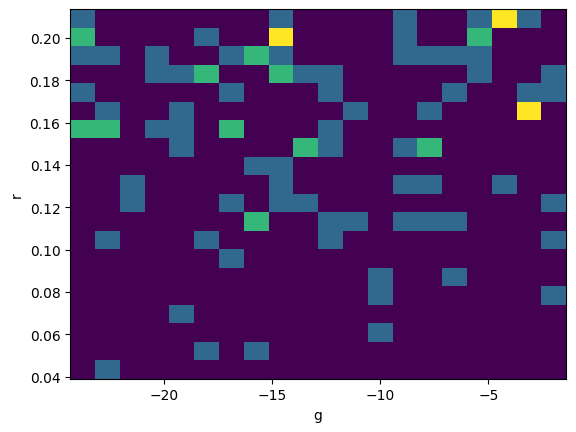

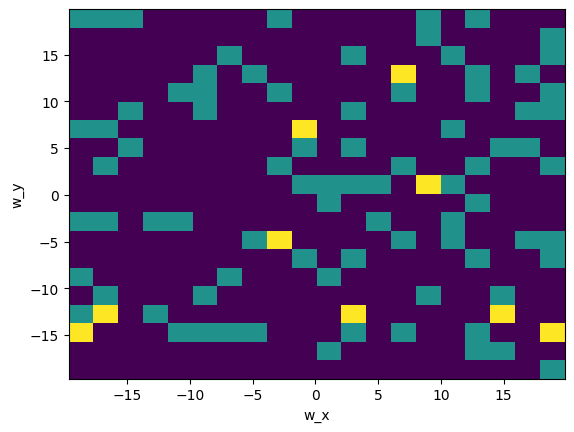

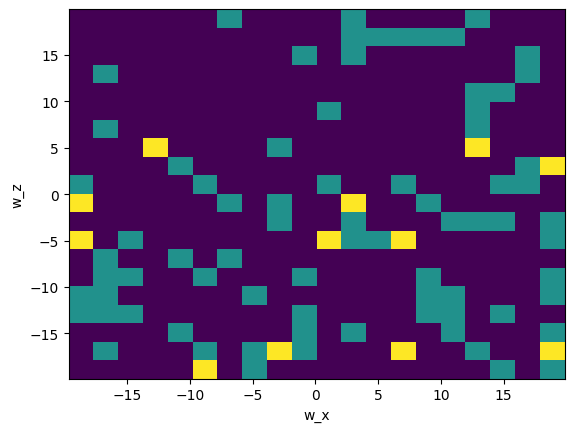

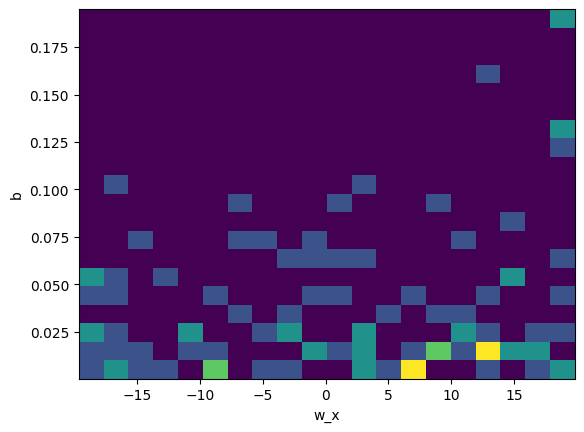

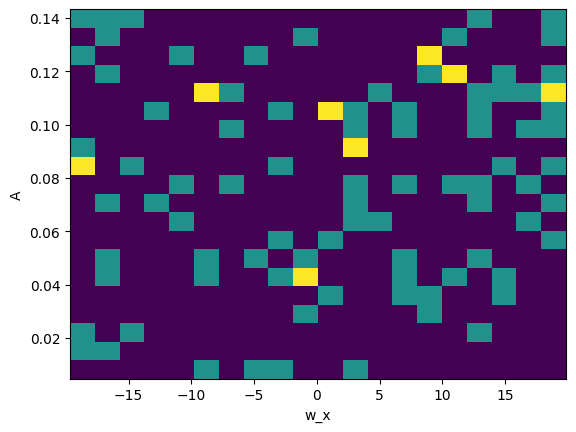

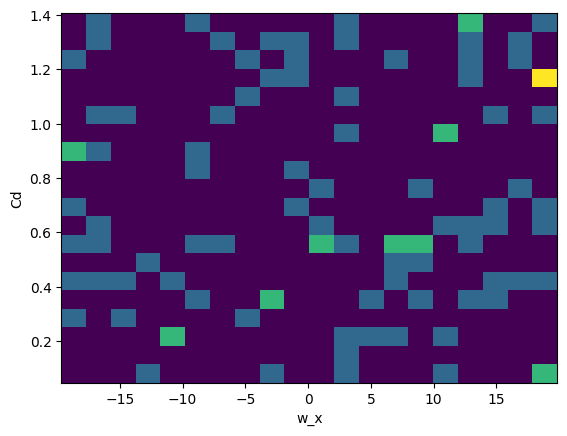

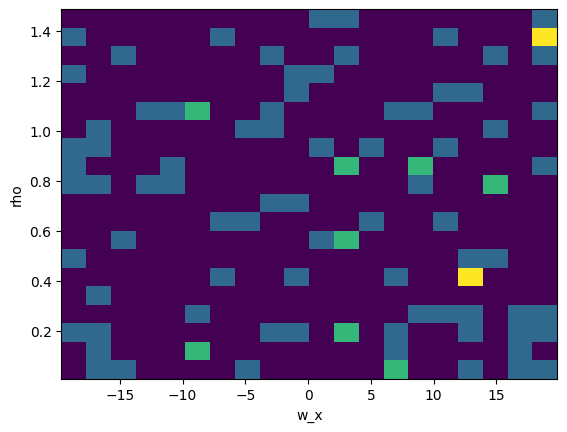

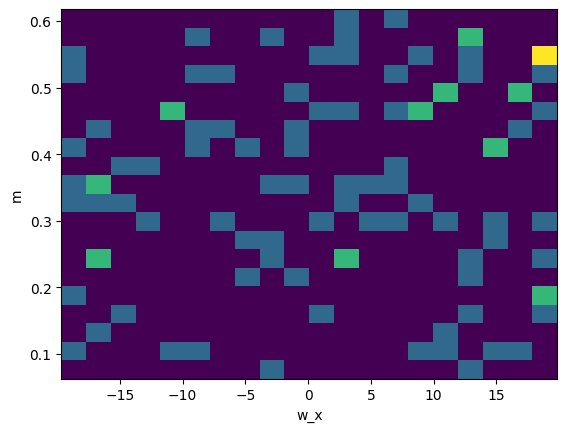

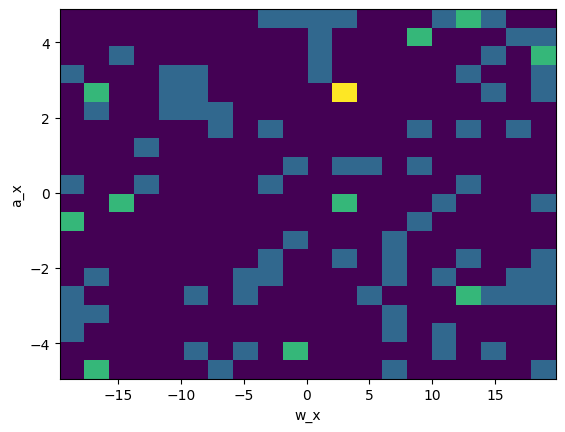

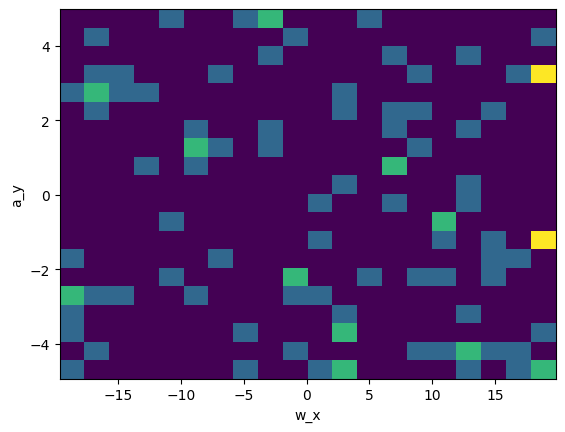

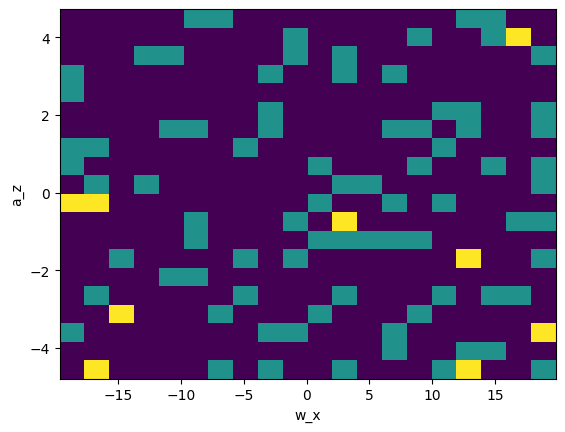

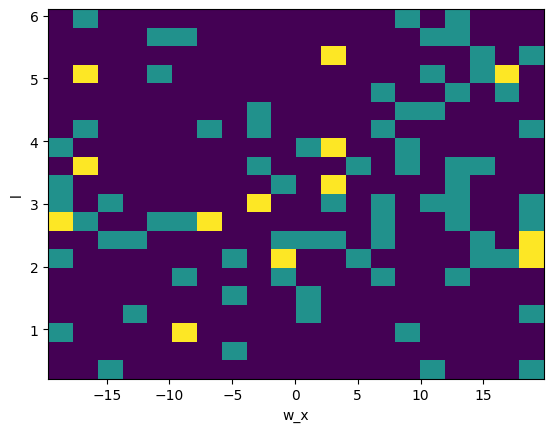

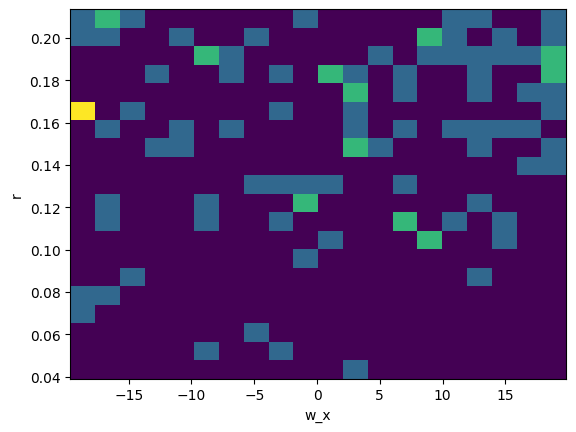

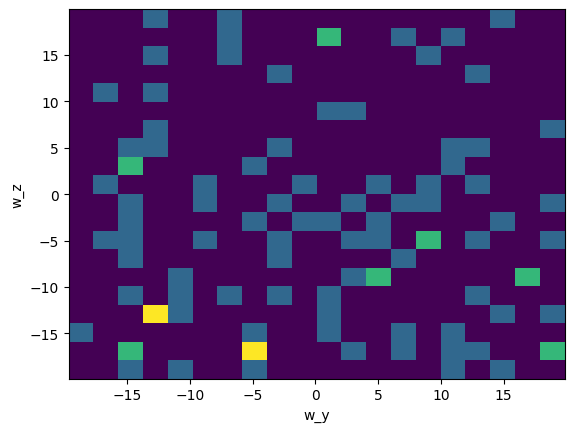

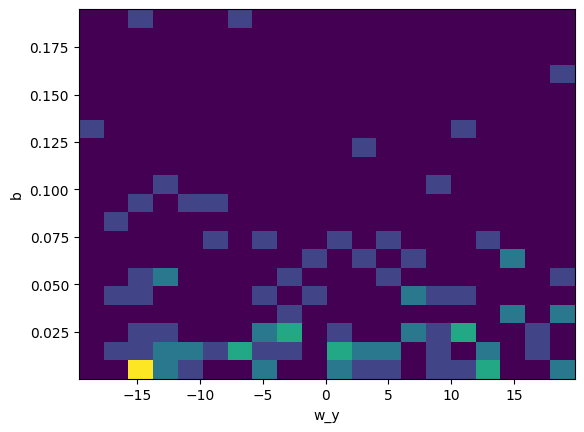

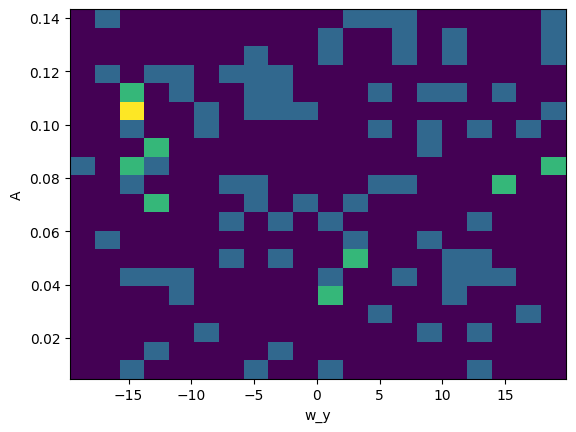

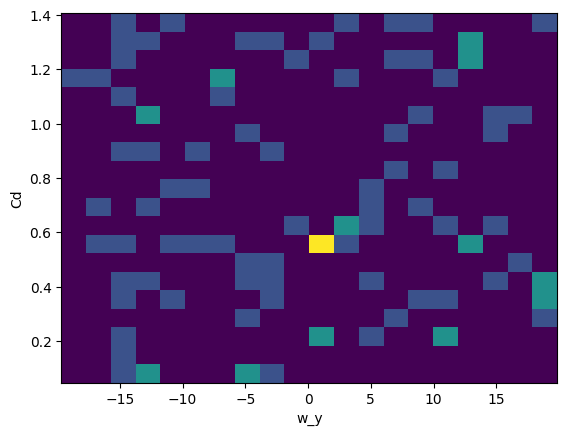

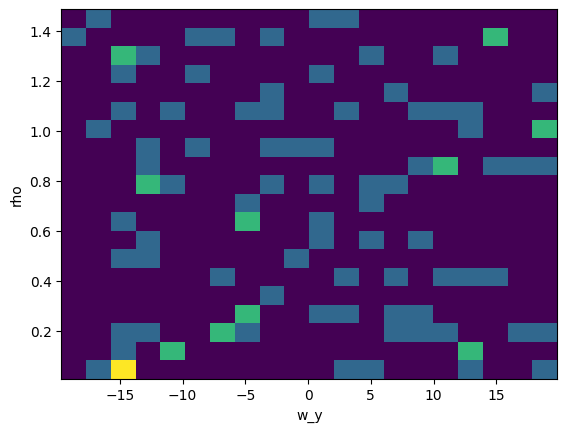

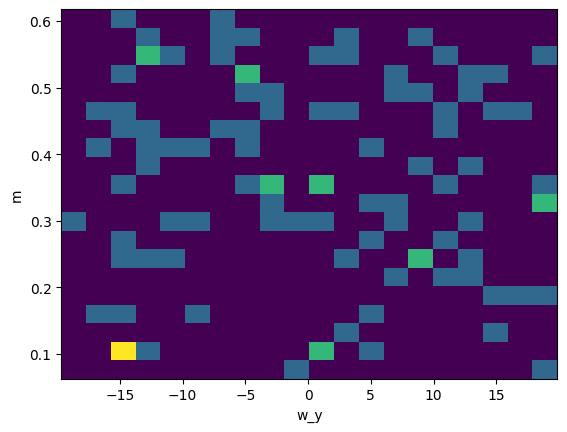

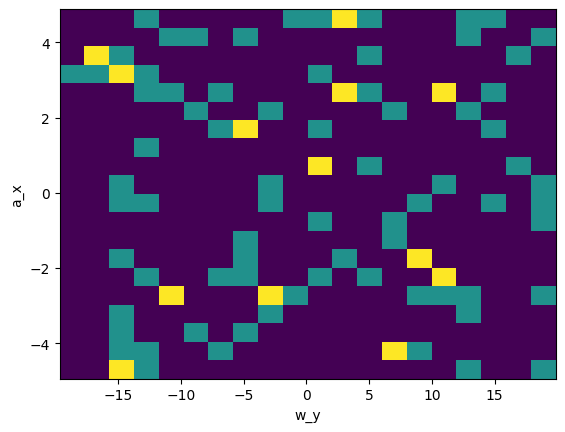

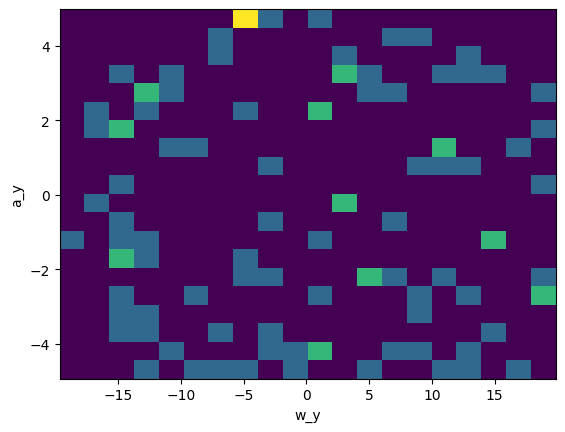

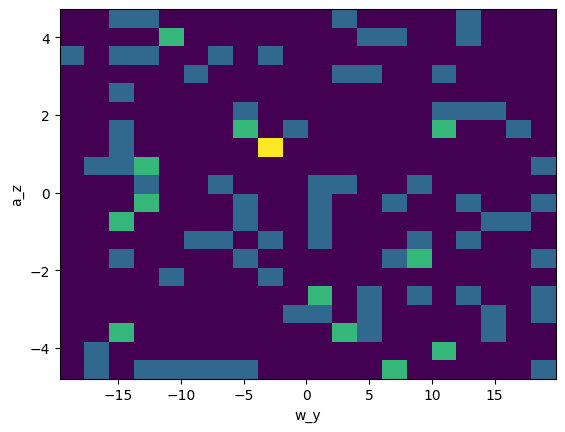

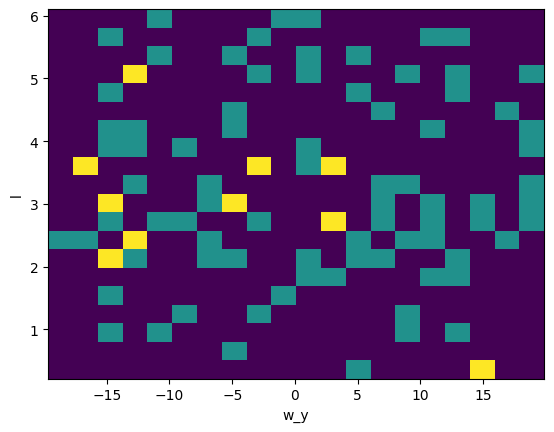

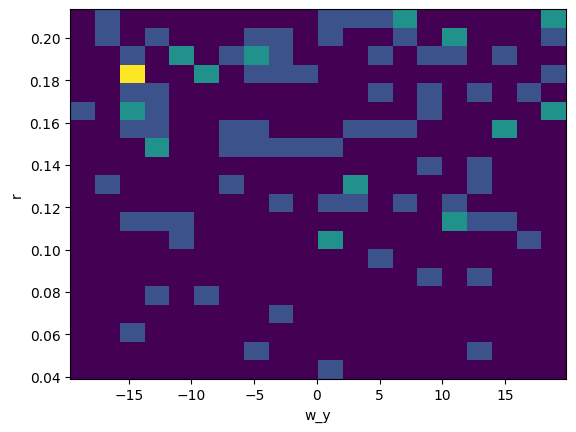

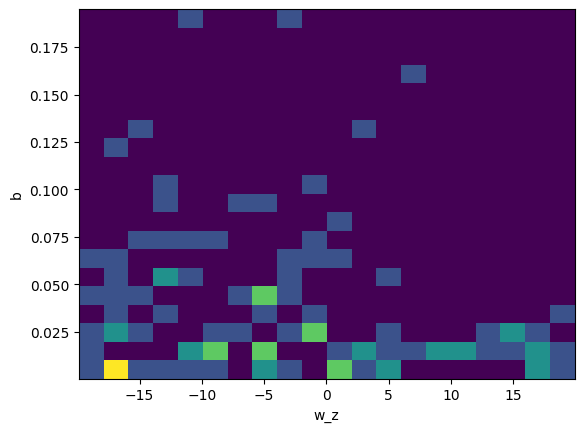

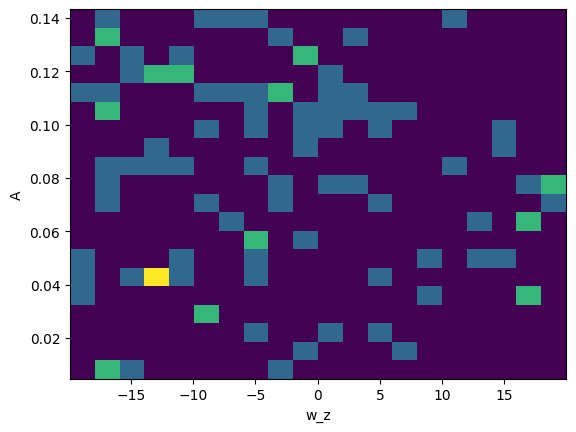

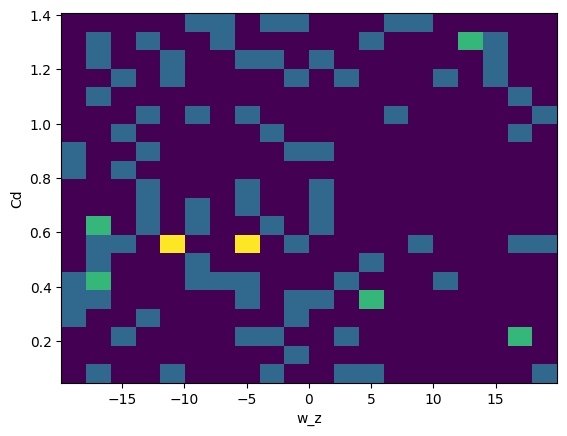

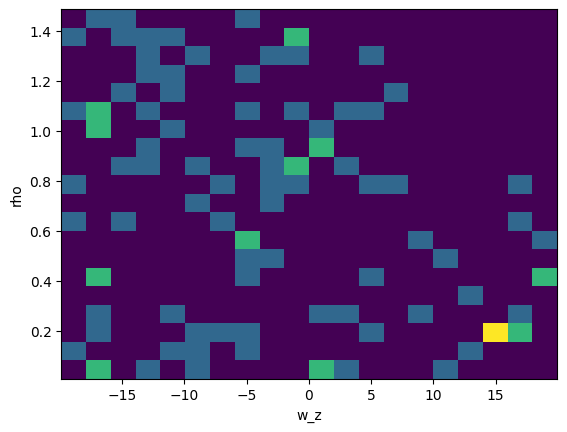

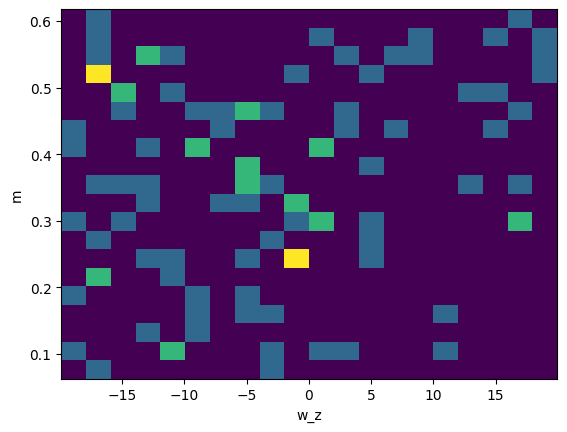

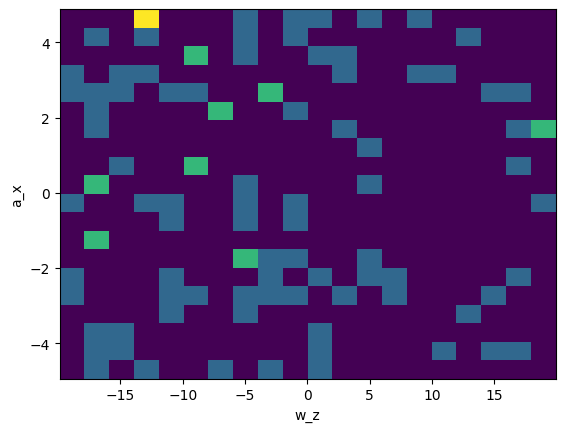

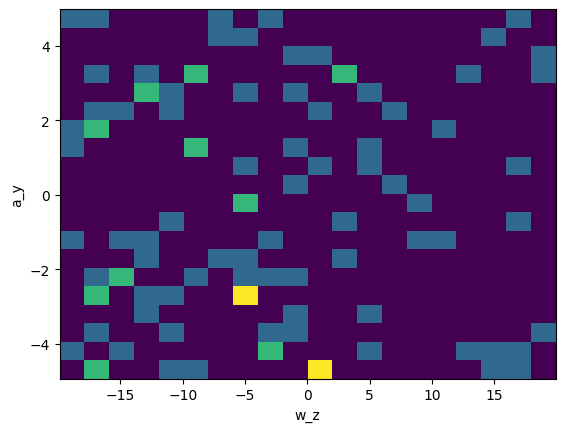

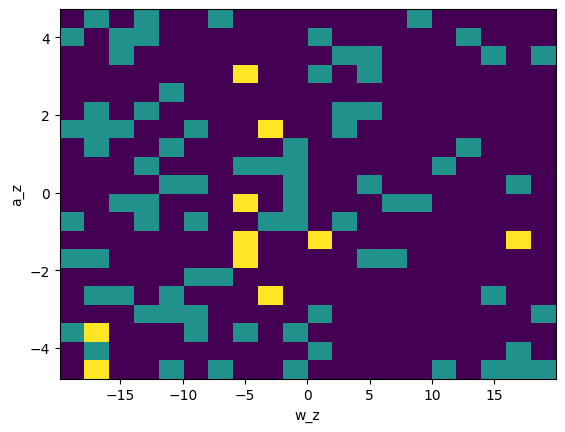

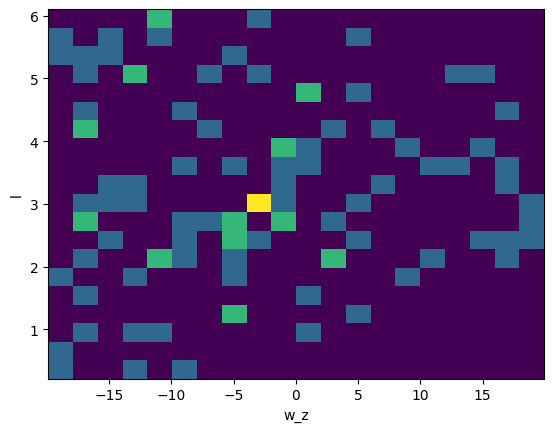

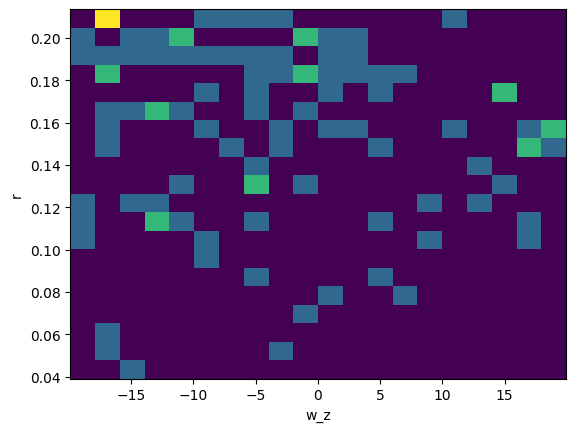

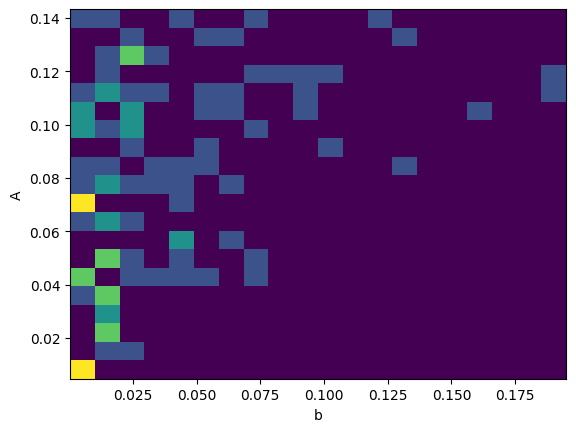

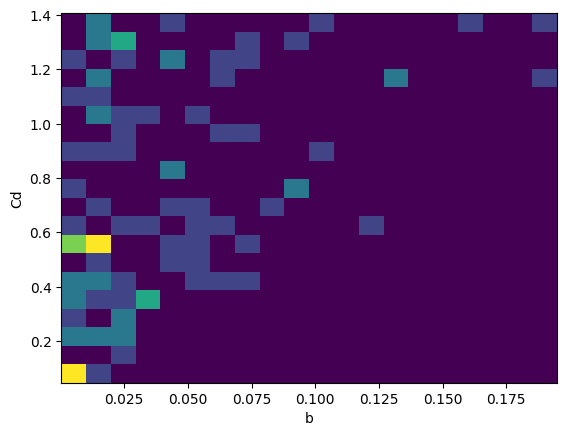

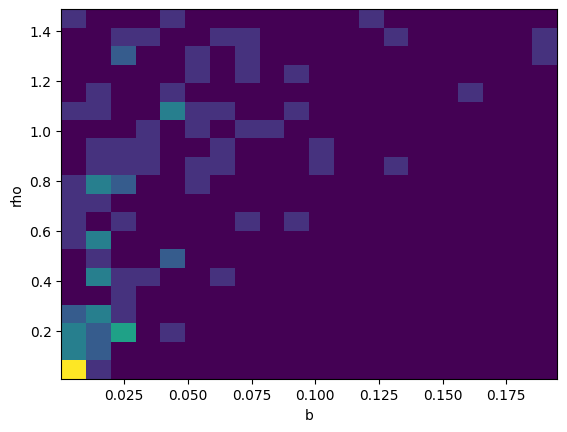

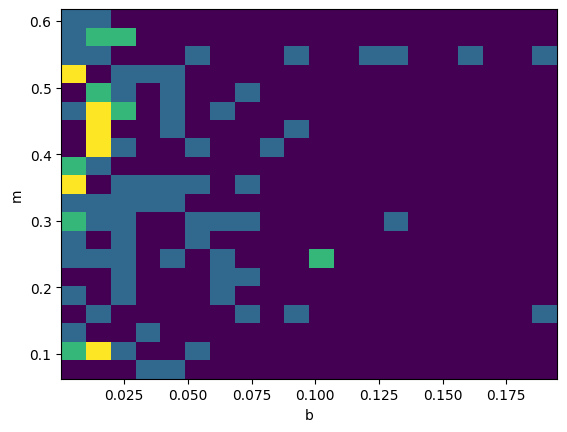

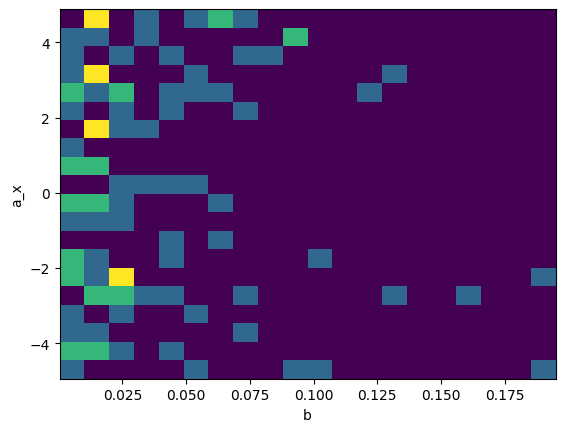

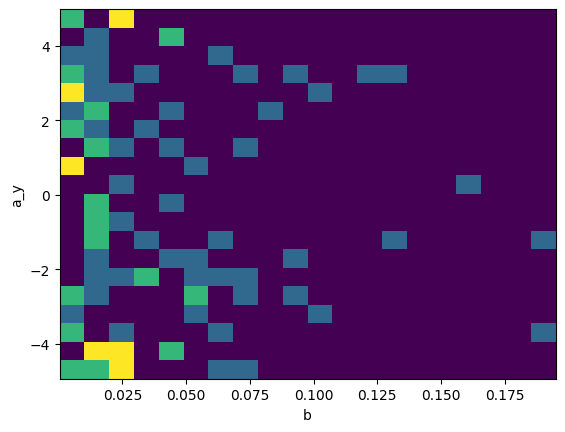

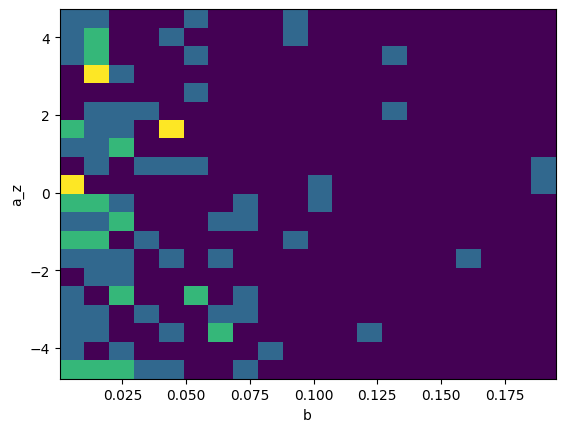

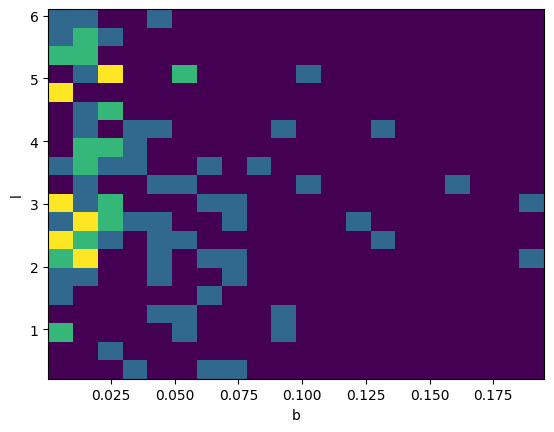

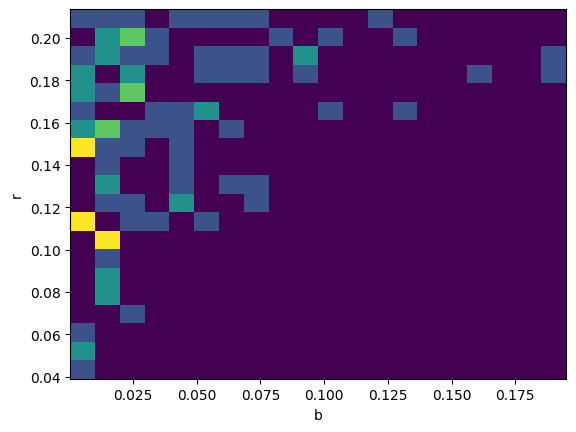

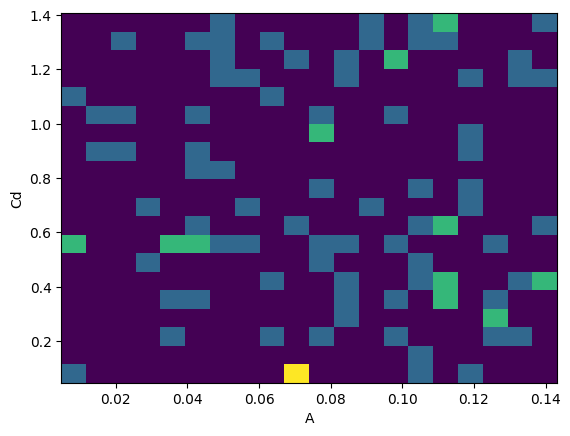

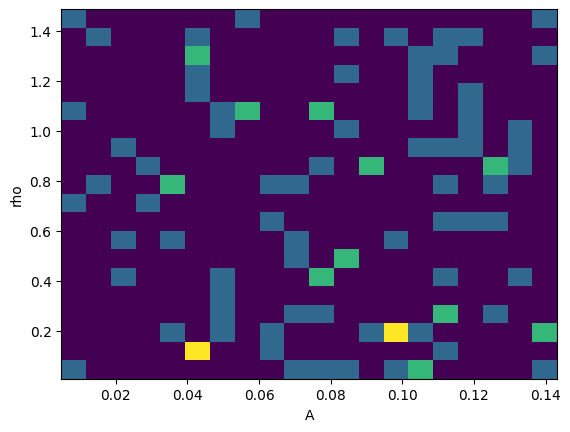

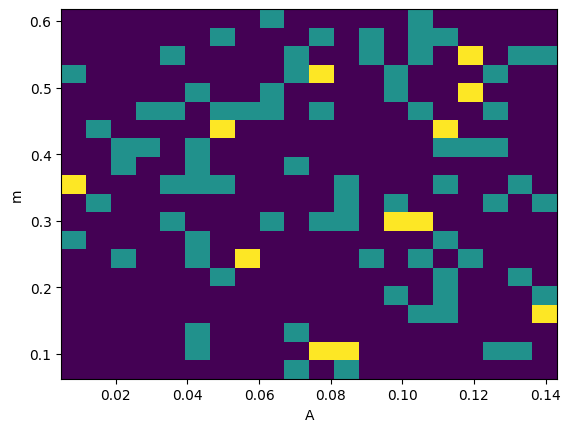

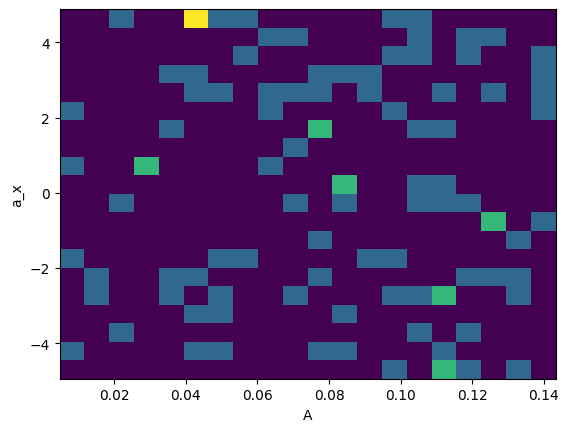

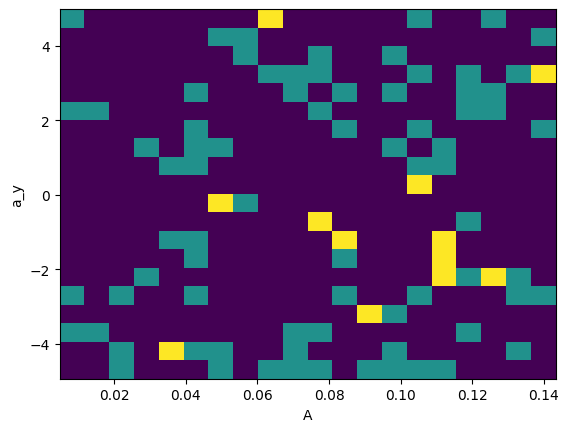

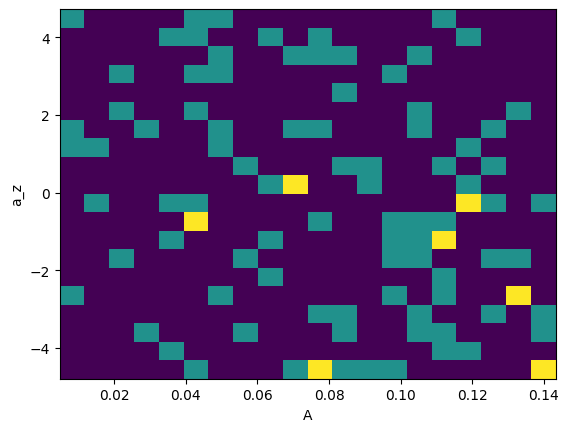

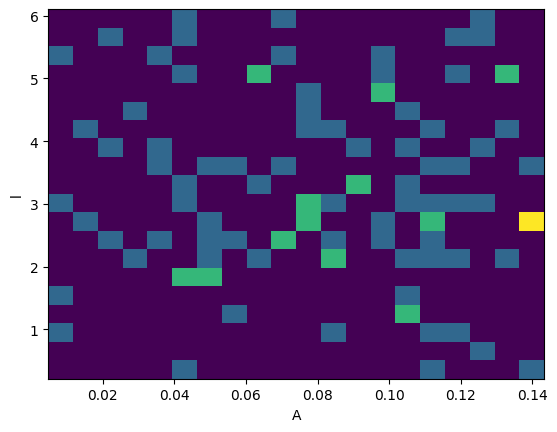

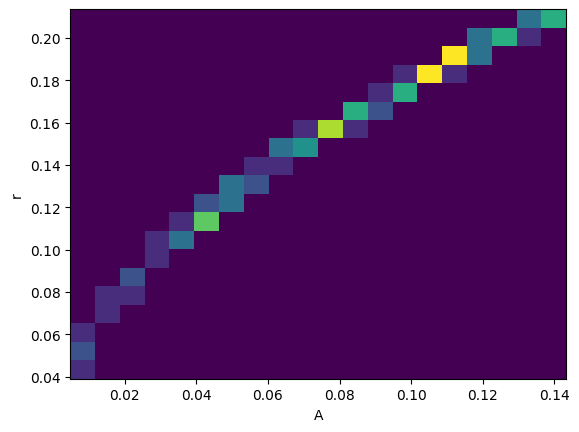

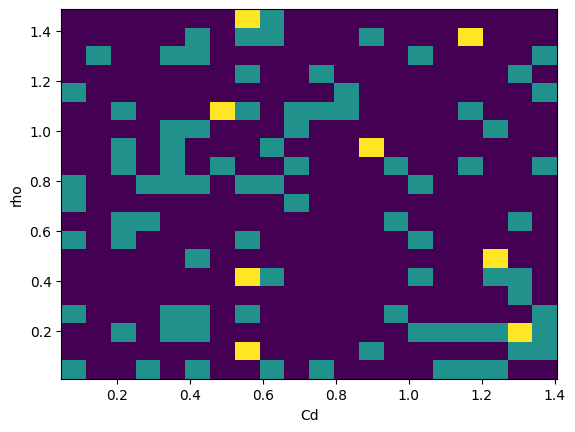

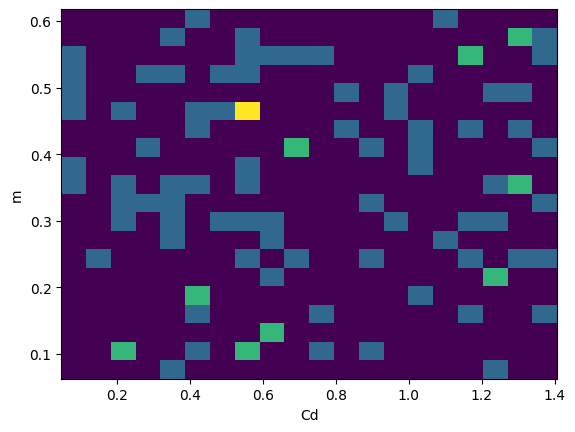

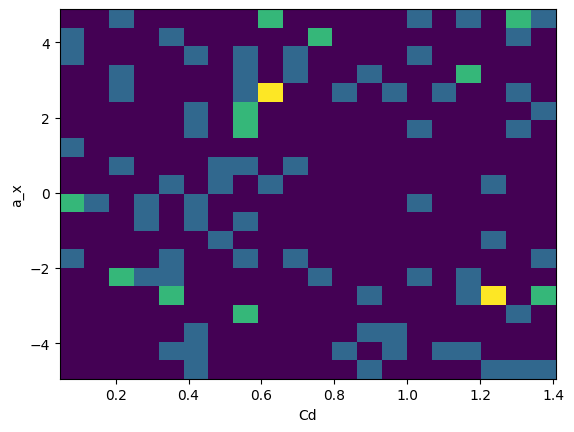

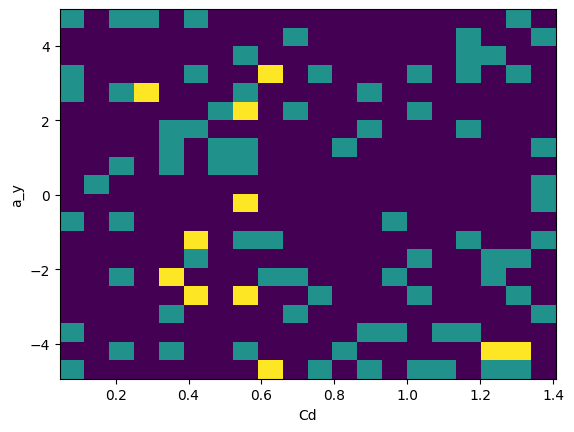

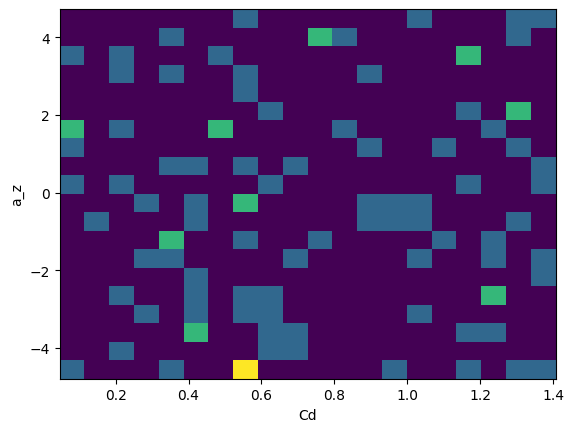

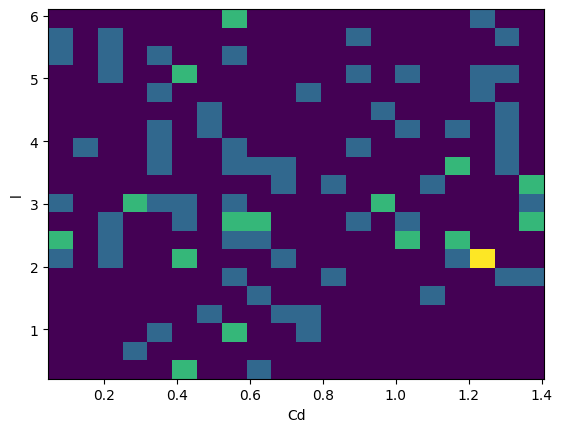

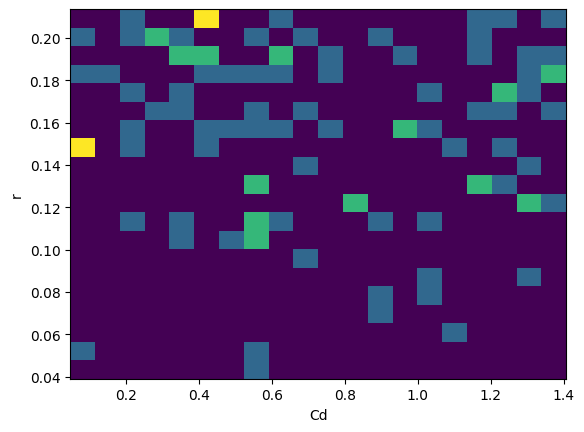

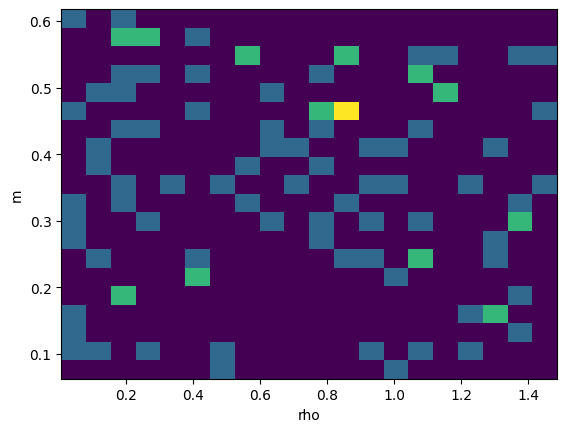

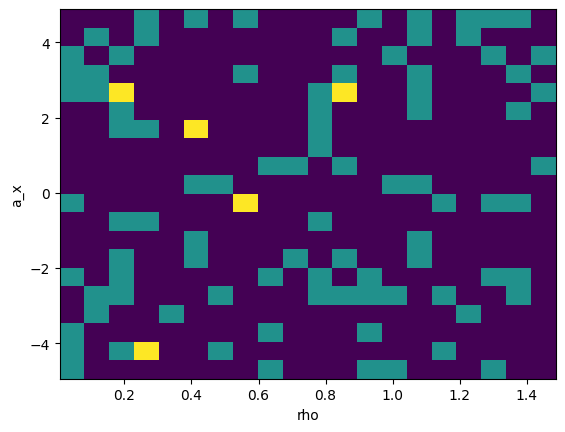

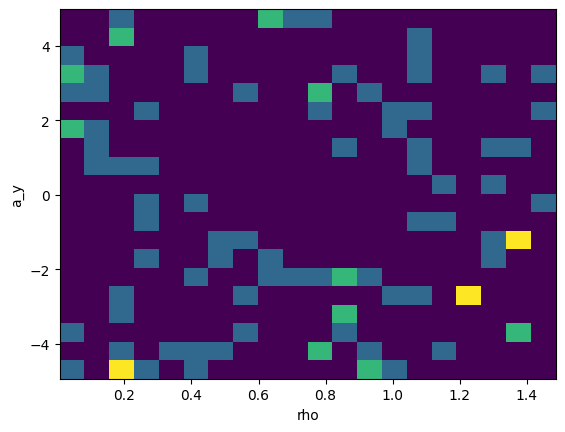

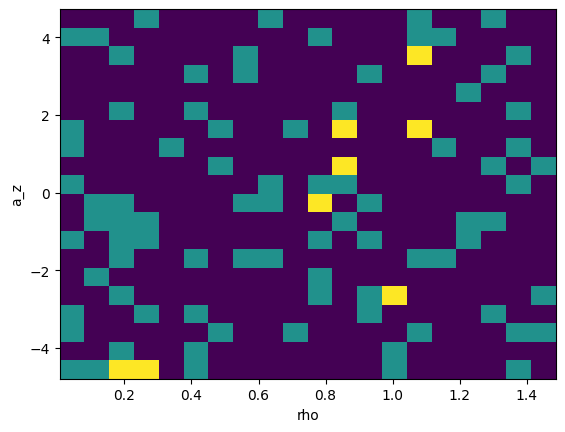

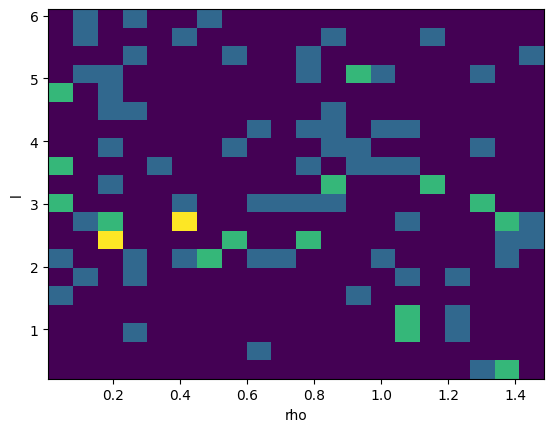

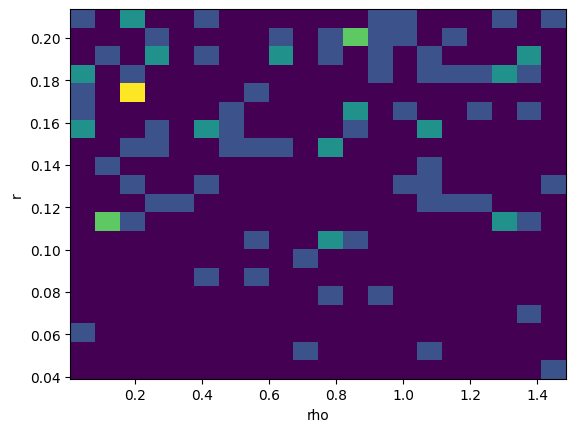

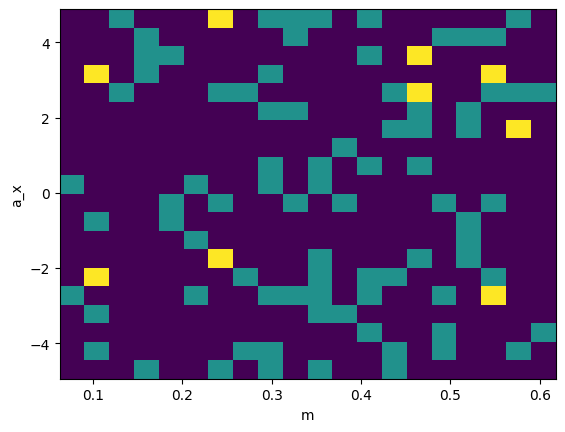

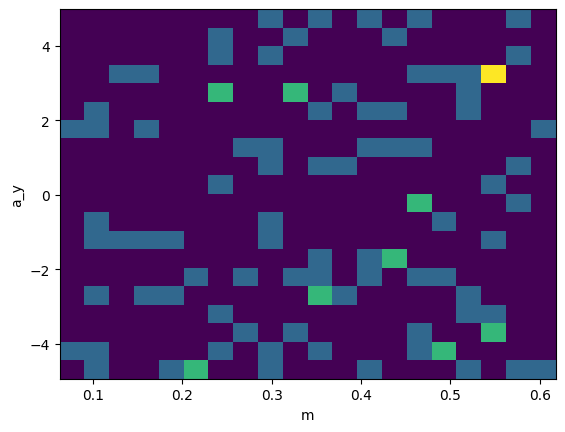

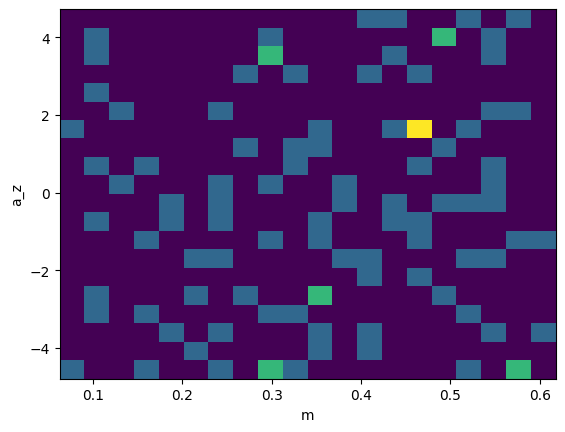

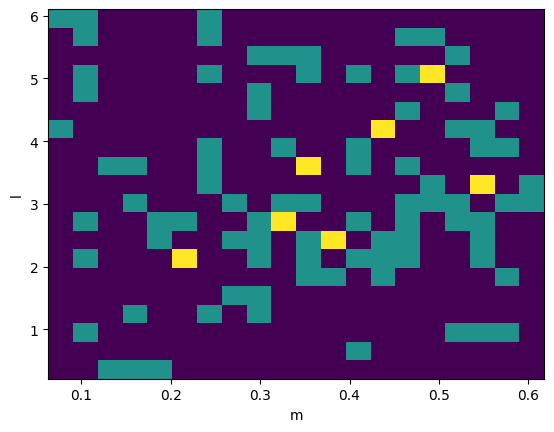

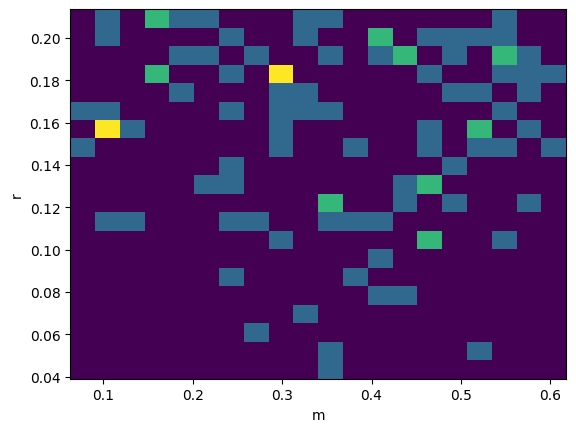

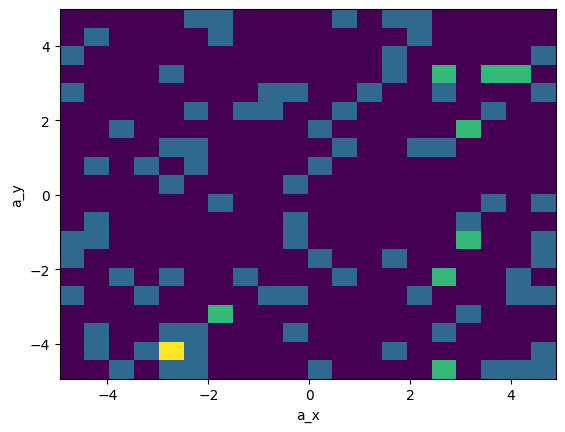

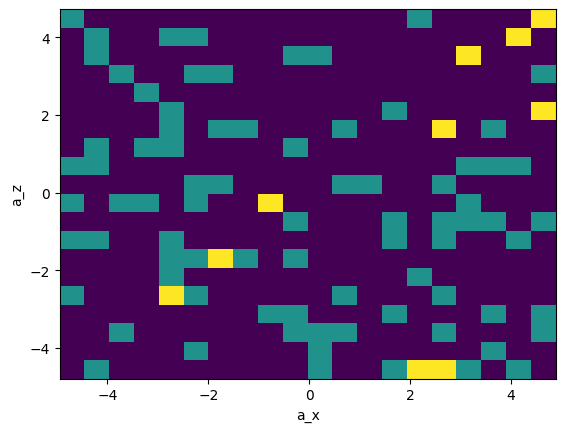

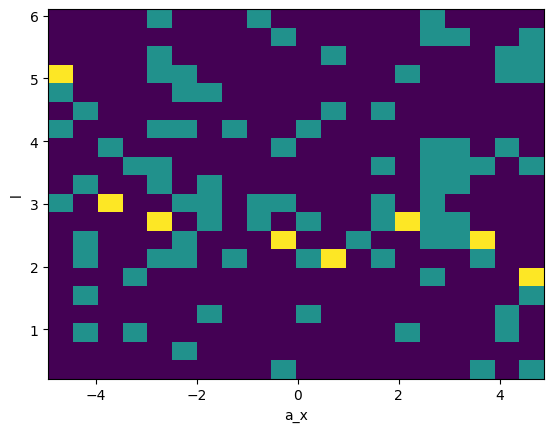

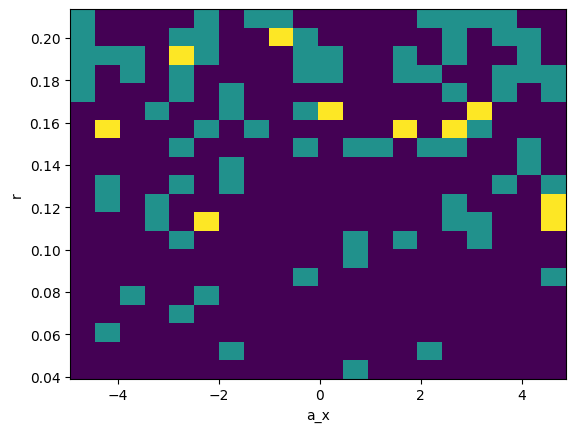

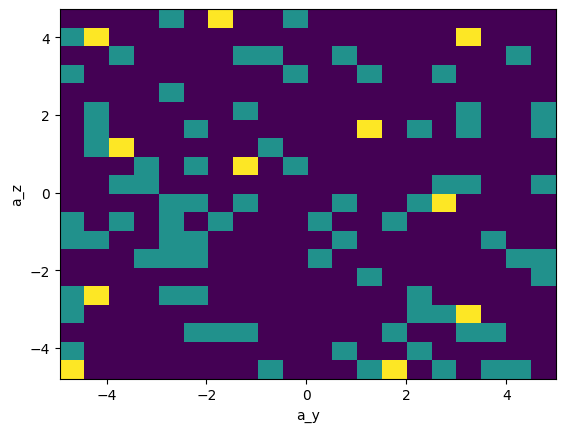

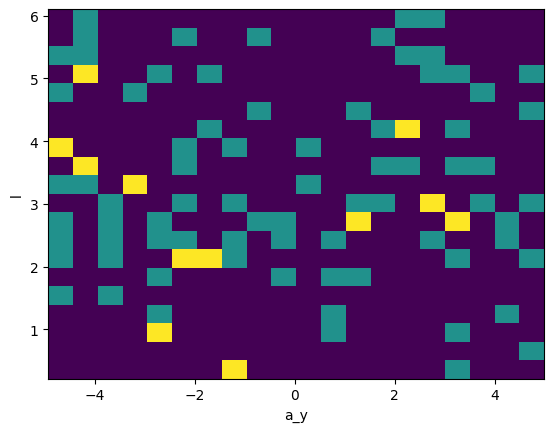

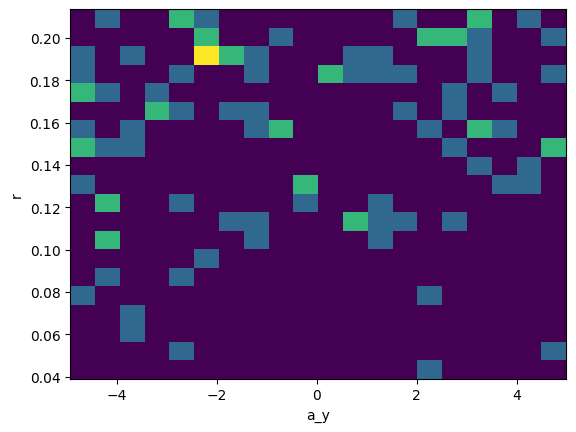

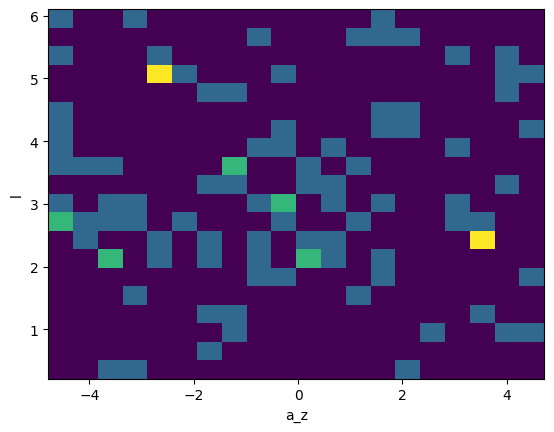

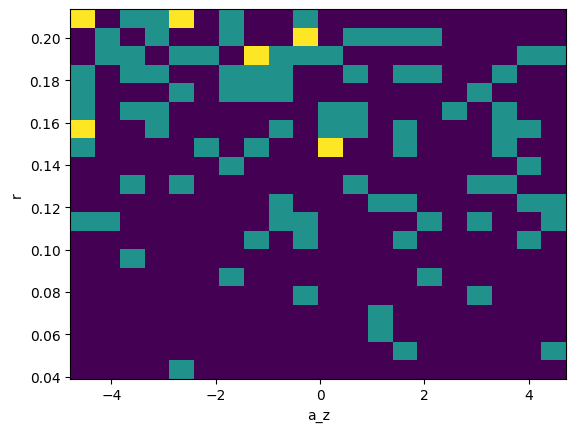

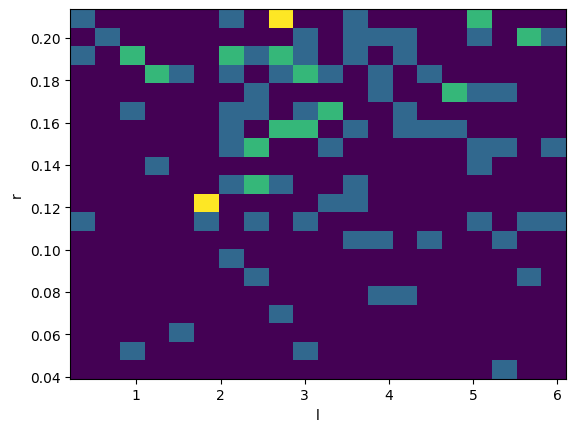

In [8]:
# plot 2d hist of all pairs
for i in range(df.shape[1]):
    for j in range(i + 1, df.shape[1]):
        plt.hist2d(df.iloc[:, i], df.iloc[:, j], bins=20)
        plt.xlabel(df.columns[i])
        plt.ylabel(df.columns[j])
        plt.show()

In [56]:
# save df
df.to_csv('ballistic_parameters.csv', index=False)